In [656]:
# import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# pre-processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans

# ml algos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# filter warning messages
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', None)


In [657]:
df = pd.read_csv('processed_data/df.csv').iloc[:, 1:]

In [658]:
df = df[df['age'] > 20]

In [659]:
# checking once again to see that the important null values are gone
df.isna().sum()

RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                                0
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                           0
index                                        0
NumberofDependents_rounded                   0
set                                          0
SeriousDlqin2yrs                        101503
dtype: int64

In [660]:
df = df.drop(columns = ['NumberOfDependents'])

# Feature Engineering

As mentioned previously, correlation analysis and other EDA generated ideas to create features that highlight overdrawing and overleveraged behaviour. We create those features here

Further, we also perform Kmeans clustering, after identifying the optimal number of clusters, to add both cluster labels, and the distance from centroid as a feature

In [661]:
df.describe()

RevolvingUtilizationOfUnsecuredLines            age  \
count                         251502.000000  251502.000000   
mean                               5.750434      52.339902   
std                              229.634436      14.774781   
min                                0.000000      21.000000   
25%                                0.029976      41.000000   
50%                                0.153571      52.000000   
75%                                0.561288      63.000000   
max                            50708.000000     109.000000   

       NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  MonthlyIncome  \
count                         251502.000000  251502.000000   2.515020e+05   
mean                               0.434243     349.563856   6.503478e+03   
std                                4.335651    1884.795635   2.304293e+04   
min                                0.000000       0.000000   0.000000e+00   
25%                                0.000000       0.174330   3.710000e+03   
50%                                0.000000       0.365611   5.422000e+03   
75%                                0.000000       0.861754   7.578000e+03   
max                               98.000000  329664.000000   7.727000e+06   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
count                    251502.000000            251502.000000   
mean                          8.453074                 0.278372   
std                           5.145202                 4.312547   
min                           0.000000                 0.000000   
25%                           5.000000                 0.000000   
50%                           8.000000                 0.000000   
75%                          11.000000                 0.000000   
max                          85.000000                98.000000   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
count                 251502.000000                         251502.000000   
mean                       1.016151                              0.252467   
std                        1.121936                              4.299212   
min                        0.000000                              0.000000   
25%                        0.000000                              0.000000   
50%                        1.000000                              0.000000   
75%                        2.000000                              0.000000   
max                       54.000000                             98.000000   

               index  NumberofDependents_rounded  SeriousDlqin2yrs  
count  251502.000000               251502.000000     149999.000000  
mean   125751.238789                    0.744885          0.066840  
std     72602.852290                    1.115198          0.249746  
min         0.000000                    0.000000          0.000000  
25%     62875.250000                    0.000000          0.000000  
50%    125751.500000                    0.000000          0.000000  
75%    188626.750000                    1.000000          0.000000  
max    251502.000000                   43.000000          1.000000

In [ ]:
#feature engineering #1 - adding aggregated features by age bins

In [662]:
df['age_bins'] = pd.cut(x=df['age'], bins=list(range(20, 115, 5)))

In [663]:
df['age_bins'].value_counts()

(45, 50]      31577
(50, 55]      29968
(55, 60]      28293
(60, 65]      27596
(40, 45]      27292
(35, 40]      22733
(65, 70]      18497
(30, 35]      17966
(25, 30]      12773
(70, 75]      12547
(75, 80]       8833
(20, 25]       5063
(80, 85]       4930
(85, 90]       2631
(90, 95]        705
(95, 100]        82
(100, 105]       13
(105, 110]        3
Name: age_bins, dtype: int64

In [664]:
med_by_age_bins = pd.DataFrame(df.groupby('age_bins')[['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberRealEstateLoansOrLines', 'DebtRatio', 'MonthlyIncome', 'NumberofDependents_rounded']].median()).reset_index()
med_by_age_bins.columns = ['age_bins', 'med_utilization_unsecured_by_age', 'med_noTime30-59dayspastdue_by_age', 'med_NumberRealEstateLoansOrLines_by_age', 'med_DebtRatio_by_age', 'med_monthlyincome', 'med_no_dependents']

In [665]:
df2 = df.merge(med_by_age_bins, on = 'age_bins', how = 'left')

In [ ]:
# feature engineering #2 - adding aggregated features by monthly income

In [669]:
df2['monthly_income_bins'] = pd.qcut(df['MonthlyIncome'], 5, labels = ['v_low_income', 'low_income', 'med_income', 'high_income', 'v_high_income'])

In [670]:
med_by_income = pd.DataFrame(df2.groupby('monthly_income_bins')[['NumberRealEstateLoansOrLines', 'DebtRatio' ]].median()).reset_index()
med_by_income.columns = ['monthly_income_bins','med_NumberRealEstateLoansOrLines_by_income', 'med_DebtRatio_by_income']


In [671]:
ave_by_income = pd.DataFrame(df2.groupby('monthly_income_bins')[['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse']].mean()).reset_index()
ave_by_income.columns = ['monthly_income_bins','ave_RevolvingUtilizationOfUnsecuredLines_by_income', 'ave_NumberOfTime30-59DaysPastDueNotWorse_by_income']

In [672]:
df2 = df2.merge(med_by_income, on = 'monthly_income_bins', how = 'left').merge(ave_by_income, on = 'monthly_income_bins', how = 'left')

In [ ]:
#feature engineering #3 - adding features that normalise due and late events by number of loans

In [666]:
df2['ratio_PastDue_to_no_loans'] = (df2['NumberOfTime30-59DaysPastDueNotWorse'] + df2['NumberOfTime60-89DaysPastDueNotWorse'])/(df2['NumberOfOpenCreditLinesAndLoans'] + df2['NumberRealEstateLoansOrLines'])
df2['ratio_late_to_no_loans'] = df2['NumberOfTimes90DaysLate']/(df2['NumberOfOpenCreditLinesAndLoans'] + df2['NumberRealEstateLoansOrLines'])

In [674]:
# checking for 'inf' values, so we replace it with a nan, and impute a value for that value
df2.replace([np.inf, -np.inf], np.nan, inplace=True)

In [675]:
df2.isna().sum()

RevolvingUtilizationOfUnsecuredLines                       0
age                                                        0
NumberOfTime30-59DaysPastDueNotWorse                       0
DebtRatio                                                  0
MonthlyIncome                                              0
NumberOfOpenCreditLinesAndLoans                            0
NumberOfTimes90DaysLate                                    0
NumberRealEstateLoansOrLines                               0
NumberOfTime60-89DaysPastDueNotWorse                       0
index                                                      0
NumberofDependents_rounded                                 0
set                                                        0
SeriousDlqin2yrs                                      101503
age_bins                                                   0
med_utilization_unsecured_by_age                           0
med_noTime30-59dayspastdue_by_age                          0
med_NumberRealEstateLoan

In [676]:
df2['ratio_PastDue_to_no_loans'] = df2['ratio_PastDue_to_no_loans'].fillna(0)
df2['ratio_late_to_no_loans'] = df2['ratio_late_to_no_loans'].fillna(0)

In [678]:
# for some reason, one observation stubbornly appears as having nan values. I have no choice but to delete.
df2[df2['med_DebtRatio_by_income'].isna()].index
df2 = df2.drop(labels=65695, axis=0)

Int64Index([65695], dtype='int64')

In [682]:
# feature engineering #4 - clustering
df3 = df2.drop(columns = ['index', 'set', 'SeriousDlqin2yrs', 'age_bins', 'monthly_income_bins'])

# kmeans clustering works on euclidean distance, so we must scale the dataset
sc = StandardScaler()
X = sc.fit_transform(df3)

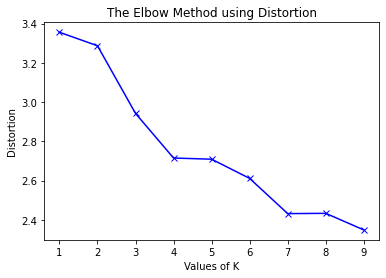

In [683]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


the optimal k value is 4

In [684]:
km = KMeans(n_clusters=4, random_state = 42).fit(X)

In [685]:
# adding cluster labels as a feature 
df2['clusters'] = km.labels_

In [686]:
# adding distance_from_centroid using KMeans.transform(), which returns an array of distances of each sample to the each cluster center.
distances_to_centroid = km.fit_transform(X)

In [688]:
df2['distance_to_centroid'] = [i.min() for i in distances_to_centroid]

In [702]:
# Feature Engineering #5: One hot encoding for our single categorical variable
df2 = pd.get_dummies(df2, columns = ['age_bins', 'monthly_income_bins'])

In [700]:
import re
def remove_special_char(column_names):
    cleaned_list =[]
    for i in column_names:
        i = re.sub('[^A-Za-z0-9]+', '_', i)
        if i[-1] == '_': 
            i = i [:-1]
        cleaned_list.append(i)

    return cleaned_list

In [701]:
df3.columns = remove_special_char(df3.columns)

Feature engineering is nearly complete and now we can safely separate the original Kaggle train and test sets, scale them, and prepare for feature selection

In [703]:
# feature engineering #7A - scaling train set
train_set = df2[df2['set'] == 'train'].drop(columns = ['index', 'set'])
train_set2 = train_set.drop(columns = ['SeriousDlqin2yrs'])
train_set2.columns = remove_special_char(train_set2.columns)
orig_cols = train_set2.columns
X = sc.fit_transform(train_set2)
y = train_set['SeriousDlqin2yrs']
X2 = pd.DataFrame(X, columns = orig_cols)

In [709]:
for i in train_set2.columns: 
    if i not in test_set2.columns:
        print(i)

In [713]:
# feature engineering #7B - scaling test set
test_set = df2[df2['set'] == 'test'].drop(columns = ['index', 'set'])
test_set2 =test_set.drop(columns = ['SeriousDlqin2yrs'])
test_set_orig_cols = test_set2.columns
kaggle_X_test = sc.transform(test_set2)
kaggle_X_test2 = pd.DataFrame(kaggle_X_test, columns = test_set_orig_cols)
kaggle_y_test = test_set['SeriousDlqin2yrs']

In [715]:
train_set.shape, test_set.shape

((149998, 48), (101503, 48))

# Feature Selection

Feature engineer has grown our total feature set from 11 to 48. Modern ML methods have less problem dealing with a large number of features, but it is still preferable to optimise the number of features so that (a) we reduce computation time (b) we reduce the chance of overfitting (c) we make the model more generalizable (d) potentially make performance gains 

In [716]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42 , stratify = y)

In [717]:
# I use the SelectFromModel package to iteratively check the model's performance over a range of X features
# generating various scores to assess impact on performance

from numpy import sort
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectFromModel
predictions_list = [] 
accuracy_list = []
roc_list = []

lgb = LGBMClassifier(scale_pos_weight = 13)
lgb.fit(X_train,y_train)
thresholds = sort(lgb.feature_importances_)

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(lgb, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = LGBMClassifier(scale_pos_weight = 13)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    predict_proba = selection_model.predict_proba(select_X_test)[:, 1]
    
    #metrics
    accuracy = accuracy_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test,predict_proba)
    
    
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    print("Thresh=%.3f, n=%d, roc_auc: %.2f%%" % (thresh, select_X_train.shape[1], roc_auc))
    predictions_list.append(predictions)
    accuracy_list.append(accuracy)
    roc_list.append(roc_auc)

Thresh=0.000, n=47, Accuracy: 81.55%
Thresh=0.000, n=47, roc_auc: 0.87%
Thresh=0.000, n=47, Accuracy: 81.55%
Thresh=0.000, n=47, roc_auc: 0.87%
Thresh=0.000, n=47, Accuracy: 81.55%
Thresh=0.000, n=47, roc_auc: 0.87%
Thresh=0.000, n=47, Accuracy: 81.55%
Thresh=0.000, n=47, roc_auc: 0.87%
Thresh=0.000, n=47, Accuracy: 81.55%
Thresh=0.000, n=47, roc_auc: 0.87%
Thresh=0.000, n=47, Accuracy: 81.55%
Thresh=0.000, n=47, roc_auc: 0.87%
Thresh=0.000, n=47, Accuracy: 81.55%
Thresh=0.000, n=47, roc_auc: 0.87%
Thresh=0.000, n=47, Accuracy: 81.55%
Thresh=0.000, n=47, roc_auc: 0.87%
Thresh=0.000, n=47, Accuracy: 81.55%
Thresh=0.000, n=47, roc_auc: 0.87%
Thresh=0.000, n=47, Accuracy: 81.55%
Thresh=0.000, n=47, roc_auc: 0.87%
Thresh=0.000, n=47, Accuracy: 81.55%
Thresh=0.000, n=47, roc_auc: 0.87%
Thresh=0.000, n=47, Accuracy: 81.55%
Thresh=0.000, n=47, roc_auc: 0.87%
Thresh=1.000, n=35, Accuracy: 81.55%
Thresh=1.000, n=35, roc_auc: 0.87%
Thresh=1.000, n=35, Accuracy: 81.55%
Thresh=1.000, n=35, roc_auc

[437 272  55 436 436 247  74  94  56  66   2   0   1  38  19   6 129  43
   0  39  39  35   4 366   0   8   3   6  13  11  20   0  12  13   0   1
   5   2   5   0   0   0   0   7   0   0   0]


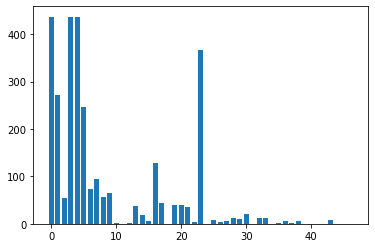

In [718]:
# feature importance
print(lgb.feature_importances_)
# plot
import matplotlib.pyplot as plt
plt.bar(range(len(lgb.feature_importances_)), lgb.feature_importances_)
plt.show()

In [719]:
# the results show that putting a cut off of >=74 for feature importance, results in the best ROC AUC score

pd.DataFrame({'thresholds': sort(lgb.feature_importances_), 
             'accuracy': accuracy_list,
             'roc_auc':roc_list}).sort_values(by = 'roc_auc', ascending = False).head()

thresholds  accuracy   roc_auc
38          74  0.813933  0.869527
34          43  0.816933  0.869401
18           5  0.815433  0.869194
19           5  0.815433  0.869194
36          56  0.816000  0.868969

In [720]:
impt_features = pd.DataFrame(list(zip(X2.columns, lgb.feature_importances_)),columns = ['feature','feature_importance']).sort_values(by = 'feature_importance', ascending = False)

In [721]:
impt_features

feature  feature_importance
0                RevolvingUtilizationOfUnsecuredLines                 437
3                                           DebtRatio                 436
4                                       MonthlyIncome                 436
23                               distance_to_centroid                 366
1                                                 age                 272
5                     NumberOfOpenCreditLinesAndLoans                 247
16                          ratio_PastDue_to_no_loans                 129
7                        NumberRealEstateLoansOrLines                  94
6                             NumberOfTimes90DaysLate                  74
9                          NumberofDependents_rounded                  66
8                NumberOfTime60_89DaysPastDueNotWorse                  56
2                NumberOfTime30_59DaysPastDueNotWorse                  55
17                             ratio_late_to_no_loans                  43
19                            med_DebtRatio_by_income                  39
20  ave_RevolvingUtilizationOfUnsecuredLines_by_in...                  39
13                               med_DebtRatio_by_age                  38
21  ave_NumberOfTime30_59DaysPastDueNotWorse_by_in...                  35
30                                     age_bins_50_55                  20
14                                  med_monthlyincome                  19
33                                     age_bins_65_70                  13
28                                     age_bins_40_45                  13
32                                     age_bins_60_65                  12
29                                     age_bins_45_50                  11
25                                     age_bins_25_30                   8
43                     monthly_income_bins_low_income                   7
27                                     age_bins_35_40                   6
15                                  med_no_dependents                   6
36                                     age_bins_80_85                   5
38                                     age_bins_90_95                   5
22                                           clusters                   4
26                                     age_bins_30_35                   3
10                   med_utilization_unsecured_by_age                   2
37                                     age_bins_85_90                   2
35                                     age_bins_75_80                   1
12            med_NumberRealEstateLoansOrLines_by_age                   1
40                                   age_bins_100_105                   0
45                    monthly_income_bins_high_income                   0
44                     monthly_income_bins_med_income                   0
42                   monthly_income_bins_v_low_income                   0
41                                   age_bins_105_110                   0
24                                     age_bins_20_25                   0
39                                    age_bins_95_100                   0
34                                     age_bins_70_75                   0
11                  med_noTime30_59dayspastdue_by_age                   0
31                                     age_bins_55_60                   0
18         med_NumberRealEstateLoansOrLines_by_income                   0
46                  monthly_income_bins_v_high_income                   0

Important to note that two of our engineered features are in the top 10 in terms of feature importance

In [725]:
selected_features = list(impt_features[impt_features['feature_importance'] >=43]['feature'])

In [726]:
X3 = X2[selected_features]
kaggle_X_test3 = kaggle_X_test2[selected_features]

In [744]:
len(selected_features)

13

We complete feature selection and reduce our initial 45 features (exclusing indexing columns and the y target) to 13 features

# Over and Undersampling for Imbalanced Dataset

Now, as we are dealing with an unbalanced data set, we'll standardize and resample the training set with RandomUnderSampler

Initially I had experimented with different combinations of over and under sampling and different sampling_strategy values. However, while over-sampling improved results on the train set, it had marginal impact on the test set. Oversampling has a higher risk of creating variance error than undersampling with unseen test sets as it produces synthetic data points which may not recur in real life. 

Therefore, I elected to proceed only with undersampling. 

In [727]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
under = RandomUnderSampler(sampling_strategy=0.1)

In [728]:
from imblearn.pipeline import Pipeline
steps = [('u', under)]
pipeline = Pipeline(steps=steps)

# Defining a second train-test set with undersampled negative cases. 
# For later comparison of model performance between the natural and undersampled test sets
X_undersampled, y_undersampled = pipeline.fit_resample(X3, y)

In [729]:
y.value_counts(), y_undersampled.value_counts()

(0.0    139972
 1.0     10026
 Name: SeriousDlqin2yrs, dtype: int64,
 0.0    100260
 1.0     10026
 Name: SeriousDlqin2yrs, dtype: int64)

# Model Selection

We will use cross-validation to assist us in model selection. Instead of simply splitting the data into a train and test set, the cross_validate method splits our training data into k number of Folds, making better use of the data. In our case, we'll perform 5-fold cross-validation, as we let the default k value.

Our eventual decision will be based on the performance on several metrics - F1, Precision, Recall, and ROC-AUC. If performance is uneven, we must later make a choice about which metric to prioritise. 

I wanted to assess at the outset whether a single classifier, or some combination, might give better performance. So, I generate an ensemble using the stacking classifier. However, as the results show, single classifiers seem to perform better.

In [230]:
from sklearn.ensemble import StackingClassifier
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('xgb', XGBClassifier(eval_metric = 'logloss', scale_pos_weight = 13)))
    level0.append(('lgb', LGBMClassifier(scale_pos_weight = 13)))
    level0.append(('cat', CatBoostClassifier(scale_pos_weight = 13)))
    level0.append(('easy', EasyEnsembleClassifier()))
    level0.append(('balanced_rf',  BalancedRandomForestClassifier()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    
    
    return model

In [231]:
stacked_model = get_stacking()

In [232]:
# define the function val_model
def val_model(X, y, clf):
    """
    Apply cross-validation on the training set.

    # Arguments
        X: DataFrame containing the independent variables.
        y: Series containing the target vector.
        clf: Scikit-learn estimator instance.
        
    # Returns
        float, mean value of the cross-validation scores.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    f1_scores = cross_val_score(pipeline, X, y, scoring='f1')
    precision = cross_val_score(pipeline, X, y, scoring='precision')
    recall = cross_val_score(pipeline, X, y, scoring='recall')
    auc = cross_val_score(pipeline, X, y, scoring='roc_auc')

    #if show == True:
    #    print(f'Recall: {scores.mean()}, {scores.std()}')
    
    return f1_scores.mean(), precision.mean(), recall.mean(), auc.mean()

stack_f1, stack_precision, stack_recall, stack_auc = val_model(X2, y, stacked_model)

In [732]:
stack_f1, stack_precision, stack_recall, stack_auc

(0.2711935153470123,
 0.5798061500675482,
 0.17822256585610213,
 0.8356940159072634)

In [ ]:
# I picked a range of classifiers (including versions of randomforest from the imbalanced-ml package)
# Ranging from the simple LogisticRegression to powerful classifiers like XGboost and CatBoost

def evaluate_models(X,y):
    
    """
    Evaluate the performance of various classifiers on the input dataset

    # Arguments
        X: DataFrame containing independent X variables
        y: Series containing y target variable
        
    # Returns
        results: DataFrame with each model's performance in f1-score, precision, recall, and roc_auc
    """
    xgb = XGBClassifier(eval_metric = 'mlogloss', scale_pos_weight = 13)
    lgb = LGBMClassifier(scale_pos_weight = 13)
    cb = CatBoostClassifier(scale_pos_weight = 13)
    easy = EasyEnsembleClassifier()
    log = LogisticRegression()
    balanced_rf = BalancedRandomForestClassifier()
    class_weighting_rf = RandomForestClassifier(class_weight = 'balanced')
    bootstrap_rf = RandomForestClassifier(class_weight = 'balanced_subsample')
    stack_model = get_stacking()
    
    rf =  RandomForestClassifier()
    xgb = XGBClassifier()
    lgb = LGBMClassifier()
    cb = CatBoostClassifier()
    
    model_names = ['easy', 'balanced', 'class_weighting_rf', 'bootstrap_rf', 'log', 'rf', 'xgb', 'lgb', 'cb']
    model_list = []
    f1_scores_list = []
    precision_list = []
    recall_list = [] 
    roc_auc_list = []

    for clf in (easy, balanced_rf, class_weighting_rf, bootstrap_rf, log, rf, xgb, lgb, cb):
        print(clf)
        model_list.append(clf.__class__.__name__)
        f1_scores, precision, recall, auc = val_model(X, y, clf)
        f1_scores_list.append(f1_scores)
        precision_list.append(precision)
        recall_list.append(recall)
        roc_auc_list.append(auc)
        
        print(f1_scores)
        print(precision)
    
    results = pd.DataFrame({'model_list': model_list,
              'model_names': model_names,
             'f1_scores': f1_scores_list, 
             'precision': precision_list, 
             'recall' :recall_list, 
             'roc_auc_list': roc_auc_list})
    
    return results

In [300]:
original_data_results = evaluate_models(X3, y)

EasyEnsembleClassifier()
0.3421506231995361
0.22254337391443596
BalancedRandomForestClassifier()
0.33016830867817754
0.21098708994404625
RandomForestClassifier(class_weight='balanced')
0.24546246843319133
0.5613310418565123
RandomForestClassifier(class_weight='balanced_subsample')
0.24373082691561504
0.5575210232089893
LogisticRegression()
0.13489313744402978
0.5092173231801136
RandomForestClassifier()
0.2805340903581306
0.5500025955804205
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.079554
0:	learn: 0.5783040	total: 33.9ms	remaining: 33.8s
1:	learn: 0.4970261	total: 67ms	remaining: 33.4s
2:	learn: 0.4343473	total: 100ms	remaining: 33.3s
3:	learn: 0.3804003	total: 137ms	remaining: 34.1s
4:	learn: 0.3412553	total: 172ms	remaining: 34.3s
5:	learn: 0.3083752	total: 211ms	remaining: 35s
6:	learn: 0.2870029	total: 248ms	remaining: 35.1s
7:	learn: 0.2672697	total: 283ms	remaining: 35.1s
8:	learn: 0.2516926	total: 318ms	remaining: 35.1s
9:	learn: 0.2389039	total: 353ms	remaining: 34.9s
10:	learn: 0.2300360	total: 384ms	remaining: 34.5s
11:	learn: 0.2231923	total: 419ms	remaining: 34.5s
12:	learn: 0.2163672	total: 456ms	remaining: 34.6s
13:	learn: 0.2099273	total: 490ms	remaining: 34.5s
14:	learn: 0.2048884	total: 528ms	remaining: 34.6s
15:	learn: 0.2006877	total: 565ms	remaining: 34.7s
16:	learn: 0.1973617	total: 600ms	remaining: 34.7s
17:	learn: 0.1952839	total: 636ms	remaining: 34.7s
18:	learn: 0.1925047	total: 672ms	remaining: 34.7s
19:	learn: 0.

161:	learn: 0.1712508	total: 6.36s	remaining: 32.9s
162:	learn: 0.1712229	total: 6.4s	remaining: 32.9s
163:	learn: 0.1711756	total: 6.46s	remaining: 32.9s
164:	learn: 0.1711430	total: 6.5s	remaining: 32.9s
165:	learn: 0.1710983	total: 6.54s	remaining: 32.9s
166:	learn: 0.1710680	total: 6.59s	remaining: 32.9s
167:	learn: 0.1710381	total: 6.63s	remaining: 32.8s
168:	learn: 0.1709890	total: 6.67s	remaining: 32.8s
169:	learn: 0.1709533	total: 6.72s	remaining: 32.8s
170:	learn: 0.1709264	total: 6.76s	remaining: 32.8s
171:	learn: 0.1708768	total: 6.81s	remaining: 32.8s
172:	learn: 0.1708391	total: 6.85s	remaining: 32.7s
173:	learn: 0.1707885	total: 6.89s	remaining: 32.7s
174:	learn: 0.1707624	total: 6.94s	remaining: 32.7s
175:	learn: 0.1707109	total: 6.98s	remaining: 32.7s
176:	learn: 0.1706586	total: 7.03s	remaining: 32.7s
177:	learn: 0.1705952	total: 7.07s	remaining: 32.7s
178:	learn: 0.1705590	total: 7.12s	remaining: 32.6s
179:	learn: 0.1705340	total: 7.16s	remaining: 32.6s
180:	learn: 0.

322:	learn: 0.1659090	total: 13.1s	remaining: 27.5s
323:	learn: 0.1658796	total: 13.2s	remaining: 27.5s
324:	learn: 0.1658349	total: 13.2s	remaining: 27.4s
325:	learn: 0.1658119	total: 13.2s	remaining: 27.4s
326:	learn: 0.1657825	total: 13.3s	remaining: 27.3s
327:	learn: 0.1657443	total: 13.3s	remaining: 27.3s
328:	learn: 0.1657195	total: 13.4s	remaining: 27.2s
329:	learn: 0.1656970	total: 13.4s	remaining: 27.2s
330:	learn: 0.1656750	total: 13.4s	remaining: 27.1s
331:	learn: 0.1656346	total: 13.5s	remaining: 27.1s
332:	learn: 0.1656091	total: 13.5s	remaining: 27s
333:	learn: 0.1655878	total: 13.5s	remaining: 27s
334:	learn: 0.1655558	total: 13.6s	remaining: 26.9s
335:	learn: 0.1655373	total: 13.6s	remaining: 26.9s
336:	learn: 0.1655000	total: 13.6s	remaining: 26.8s
337:	learn: 0.1654754	total: 13.7s	remaining: 26.8s
338:	learn: 0.1654557	total: 13.7s	remaining: 26.7s
339:	learn: 0.1654165	total: 13.7s	remaining: 26.7s
340:	learn: 0.1653791	total: 13.8s	remaining: 26.6s
341:	learn: 0.16

481:	learn: 0.1615924	total: 18.9s	remaining: 20.3s
482:	learn: 0.1615475	total: 18.9s	remaining: 20.3s
483:	learn: 0.1615183	total: 19s	remaining: 20.2s
484:	learn: 0.1615006	total: 19s	remaining: 20.2s
485:	learn: 0.1614674	total: 19s	remaining: 20.1s
486:	learn: 0.1614433	total: 19.1s	remaining: 20.1s
487:	learn: 0.1614123	total: 19.1s	remaining: 20.1s
488:	learn: 0.1613794	total: 19.2s	remaining: 20s
489:	learn: 0.1613476	total: 19.2s	remaining: 20s
490:	learn: 0.1613273	total: 19.2s	remaining: 19.9s
491:	learn: 0.1613091	total: 19.3s	remaining: 19.9s
492:	learn: 0.1612874	total: 19.3s	remaining: 19.8s
493:	learn: 0.1612530	total: 19.3s	remaining: 19.8s
494:	learn: 0.1612262	total: 19.4s	remaining: 19.8s
495:	learn: 0.1612020	total: 19.4s	remaining: 19.7s
496:	learn: 0.1611786	total: 19.4s	remaining: 19.7s
497:	learn: 0.1611584	total: 19.5s	remaining: 19.6s
498:	learn: 0.1611300	total: 19.5s	remaining: 19.6s
499:	learn: 0.1611022	total: 19.6s	remaining: 19.6s
500:	learn: 0.1610847	

643:	learn: 0.1576529	total: 25.2s	remaining: 13.9s
644:	learn: 0.1576318	total: 25.2s	remaining: 13.9s
645:	learn: 0.1576094	total: 25.3s	remaining: 13.9s
646:	learn: 0.1575966	total: 25.3s	remaining: 13.8s
647:	learn: 0.1575784	total: 25.3s	remaining: 13.8s
648:	learn: 0.1575591	total: 25.4s	remaining: 13.7s
649:	learn: 0.1575423	total: 25.4s	remaining: 13.7s
650:	learn: 0.1575191	total: 25.5s	remaining: 13.6s
651:	learn: 0.1574997	total: 25.5s	remaining: 13.6s
652:	learn: 0.1574705	total: 25.5s	remaining: 13.6s
653:	learn: 0.1574488	total: 25.6s	remaining: 13.5s
654:	learn: 0.1574247	total: 25.6s	remaining: 13.5s
655:	learn: 0.1573966	total: 25.6s	remaining: 13.4s
656:	learn: 0.1573846	total: 25.7s	remaining: 13.4s
657:	learn: 0.1573599	total: 25.7s	remaining: 13.4s
658:	learn: 0.1573490	total: 25.7s	remaining: 13.3s
659:	learn: 0.1573301	total: 25.8s	remaining: 13.3s
660:	learn: 0.1573031	total: 25.8s	remaining: 13.2s
661:	learn: 0.1572821	total: 25.8s	remaining: 13.2s
662:	learn: 

805:	learn: 0.1540248	total: 31s	remaining: 7.47s
806:	learn: 0.1540103	total: 31.1s	remaining: 7.43s
807:	learn: 0.1539883	total: 31.1s	remaining: 7.39s
808:	learn: 0.1539682	total: 31.1s	remaining: 7.35s
809:	learn: 0.1539380	total: 31.2s	remaining: 7.31s
810:	learn: 0.1538910	total: 31.2s	remaining: 7.28s
811:	learn: 0.1538563	total: 31.3s	remaining: 7.24s
812:	learn: 0.1538324	total: 31.3s	remaining: 7.2s
813:	learn: 0.1538071	total: 31.3s	remaining: 7.16s
814:	learn: 0.1537918	total: 31.4s	remaining: 7.12s
815:	learn: 0.1537689	total: 31.4s	remaining: 7.08s
816:	learn: 0.1537255	total: 31.4s	remaining: 7.04s
817:	learn: 0.1536927	total: 31.5s	remaining: 7s
818:	learn: 0.1536805	total: 31.5s	remaining: 6.97s
819:	learn: 0.1536437	total: 31.6s	remaining: 6.93s
820:	learn: 0.1536239	total: 31.6s	remaining: 6.89s
821:	learn: 0.1535864	total: 31.6s	remaining: 6.85s
822:	learn: 0.1535736	total: 31.7s	remaining: 6.81s
823:	learn: 0.1535561	total: 31.7s	remaining: 6.77s
824:	learn: 0.1535

964:	learn: 0.1506815	total: 36.9s	remaining: 1.34s
965:	learn: 0.1506574	total: 37s	remaining: 1.3s
966:	learn: 0.1506461	total: 37s	remaining: 1.26s
967:	learn: 0.1506204	total: 37s	remaining: 1.22s
968:	learn: 0.1506063	total: 37.1s	remaining: 1.19s
969:	learn: 0.1505909	total: 37.1s	remaining: 1.15s
970:	learn: 0.1505640	total: 37.2s	remaining: 1.11s
971:	learn: 0.1505467	total: 37.2s	remaining: 1.07s
972:	learn: 0.1505235	total: 37.2s	remaining: 1.03s
973:	learn: 0.1505069	total: 37.3s	remaining: 995ms
974:	learn: 0.1504852	total: 37.3s	remaining: 957ms
975:	learn: 0.1504629	total: 37.3s	remaining: 918ms
976:	learn: 0.1504503	total: 37.4s	remaining: 880ms
977:	learn: 0.1504279	total: 37.4s	remaining: 842ms
978:	learn: 0.1504123	total: 37.5s	remaining: 804ms
979:	learn: 0.1503932	total: 37.5s	remaining: 765ms
980:	learn: 0.1503656	total: 37.5s	remaining: 727ms
981:	learn: 0.1503387	total: 37.6s	remaining: 689ms
982:	learn: 0.1503184	total: 37.6s	remaining: 650ms
983:	learn: 0.15030

124:	learn: 0.1725907	total: 4.54s	remaining: 31.8s
125:	learn: 0.1725394	total: 4.57s	remaining: 31.7s
126:	learn: 0.1724952	total: 4.6s	remaining: 31.6s
127:	learn: 0.1724609	total: 4.64s	remaining: 31.6s
128:	learn: 0.1724054	total: 4.67s	remaining: 31.5s
129:	learn: 0.1723773	total: 4.7s	remaining: 31.5s
130:	learn: 0.1723309	total: 4.73s	remaining: 31.4s
131:	learn: 0.1723063	total: 4.77s	remaining: 31.4s
132:	learn: 0.1722557	total: 4.81s	remaining: 31.4s
133:	learn: 0.1722040	total: 4.85s	remaining: 31.3s
134:	learn: 0.1721592	total: 4.88s	remaining: 31.3s
135:	learn: 0.1721167	total: 4.91s	remaining: 31.2s
136:	learn: 0.1720652	total: 4.95s	remaining: 31.2s
137:	learn: 0.1720251	total: 4.99s	remaining: 31.1s
138:	learn: 0.1719875	total: 5.02s	remaining: 31.1s
139:	learn: 0.1719765	total: 5.05s	remaining: 31s
140:	learn: 0.1719306	total: 5.09s	remaining: 31s
141:	learn: 0.1718858	total: 5.12s	remaining: 30.9s
142:	learn: 0.1718554	total: 5.16s	remaining: 30.9s
143:	learn: 0.1718

287:	learn: 0.1668442	total: 10.4s	remaining: 25.7s
288:	learn: 0.1668175	total: 10.4s	remaining: 25.7s
289:	learn: 0.1668074	total: 10.5s	remaining: 25.7s
290:	learn: 0.1667714	total: 10.5s	remaining: 25.6s
291:	learn: 0.1667467	total: 10.5s	remaining: 25.6s
292:	learn: 0.1667185	total: 10.6s	remaining: 25.5s
293:	learn: 0.1666880	total: 10.6s	remaining: 25.5s
294:	learn: 0.1666802	total: 10.6s	remaining: 25.4s
295:	learn: 0.1666422	total: 10.7s	remaining: 25.4s
296:	learn: 0.1666186	total: 10.7s	remaining: 25.4s
297:	learn: 0.1665705	total: 10.8s	remaining: 25.3s
298:	learn: 0.1665421	total: 10.8s	remaining: 25.3s
299:	learn: 0.1664960	total: 10.8s	remaining: 25.2s
300:	learn: 0.1664621	total: 10.9s	remaining: 25.2s
301:	learn: 0.1664129	total: 10.9s	remaining: 25.2s
302:	learn: 0.1663802	total: 10.9s	remaining: 25.1s
303:	learn: 0.1663349	total: 11s	remaining: 25.1s
304:	learn: 0.1663105	total: 11s	remaining: 25.1s
305:	learn: 0.1662824	total: 11s	remaining: 25s
306:	learn: 0.166258

446:	learn: 0.1622849	total: 17.3s	remaining: 21.4s
447:	learn: 0.1622604	total: 17.3s	remaining: 21.4s
448:	learn: 0.1622310	total: 17.4s	remaining: 21.3s
449:	learn: 0.1621922	total: 17.4s	remaining: 21.3s
450:	learn: 0.1621619	total: 17.4s	remaining: 21.2s
451:	learn: 0.1621331	total: 17.5s	remaining: 21.2s
452:	learn: 0.1621205	total: 17.5s	remaining: 21.1s
453:	learn: 0.1620950	total: 17.6s	remaining: 21.1s
454:	learn: 0.1620621	total: 17.6s	remaining: 21.1s
455:	learn: 0.1620473	total: 17.6s	remaining: 21s
456:	learn: 0.1620257	total: 17.7s	remaining: 21s
457:	learn: 0.1619962	total: 17.7s	remaining: 20.9s
458:	learn: 0.1619811	total: 17.7s	remaining: 20.9s
459:	learn: 0.1619566	total: 17.8s	remaining: 20.9s
460:	learn: 0.1619276	total: 17.8s	remaining: 20.8s
461:	learn: 0.1618917	total: 17.8s	remaining: 20.8s
462:	learn: 0.1618721	total: 17.9s	remaining: 20.7s
463:	learn: 0.1618423	total: 17.9s	remaining: 20.7s
464:	learn: 0.1618278	total: 17.9s	remaining: 20.6s
465:	learn: 0.16

607:	learn: 0.1586169	total: 22.9s	remaining: 14.8s
608:	learn: 0.1585994	total: 23s	remaining: 14.7s
609:	learn: 0.1585752	total: 23s	remaining: 14.7s
610:	learn: 0.1585715	total: 23s	remaining: 14.7s
611:	learn: 0.1585377	total: 23.1s	remaining: 14.6s
612:	learn: 0.1585105	total: 23.1s	remaining: 14.6s
613:	learn: 0.1584941	total: 23.1s	remaining: 14.5s
614:	learn: 0.1584602	total: 23.2s	remaining: 14.5s
615:	learn: 0.1584372	total: 23.2s	remaining: 14.5s
616:	learn: 0.1584241	total: 23.2s	remaining: 14.4s
617:	learn: 0.1583952	total: 23.3s	remaining: 14.4s
618:	learn: 0.1583703	total: 23.3s	remaining: 14.3s
619:	learn: 0.1583562	total: 23.3s	remaining: 14.3s
620:	learn: 0.1583334	total: 23.4s	remaining: 14.3s
621:	learn: 0.1583131	total: 23.4s	remaining: 14.2s
622:	learn: 0.1583037	total: 23.4s	remaining: 14.2s
623:	learn: 0.1582802	total: 23.5s	remaining: 14.1s
624:	learn: 0.1582551	total: 23.5s	remaining: 14.1s
625:	learn: 0.1582289	total: 23.5s	remaining: 14.1s
626:	learn: 0.1582

767:	learn: 0.1551642	total: 28.4s	remaining: 8.58s
768:	learn: 0.1551385	total: 28.4s	remaining: 8.54s
769:	learn: 0.1551342	total: 28.5s	remaining: 8.5s
770:	learn: 0.1551156	total: 28.5s	remaining: 8.46s
771:	learn: 0.1550935	total: 28.5s	remaining: 8.43s
772:	learn: 0.1550784	total: 28.6s	remaining: 8.39s
773:	learn: 0.1550520	total: 28.6s	remaining: 8.35s
774:	learn: 0.1550191	total: 28.6s	remaining: 8.31s
775:	learn: 0.1550004	total: 28.7s	remaining: 8.28s
776:	learn: 0.1549766	total: 28.7s	remaining: 8.24s
777:	learn: 0.1549529	total: 28.7s	remaining: 8.2s
778:	learn: 0.1549482	total: 28.8s	remaining: 8.16s
779:	learn: 0.1549345	total: 28.8s	remaining: 8.12s
780:	learn: 0.1549057	total: 28.8s	remaining: 8.09s
781:	learn: 0.1548845	total: 28.9s	remaining: 8.05s
782:	learn: 0.1548655	total: 28.9s	remaining: 8.01s
783:	learn: 0.1548430	total: 28.9s	remaining: 7.97s
784:	learn: 0.1548284	total: 29s	remaining: 7.93s
785:	learn: 0.1548073	total: 29s	remaining: 7.9s
786:	learn: 0.15477

929:	learn: 0.1520938	total: 34.5s	remaining: 2.59s
930:	learn: 0.1520772	total: 34.5s	remaining: 2.56s
931:	learn: 0.1520619	total: 34.5s	remaining: 2.52s
932:	learn: 0.1520415	total: 34.6s	remaining: 2.48s
933:	learn: 0.1520303	total: 34.6s	remaining: 2.44s
934:	learn: 0.1520169	total: 34.6s	remaining: 2.41s
935:	learn: 0.1520025	total: 34.7s	remaining: 2.37s
936:	learn: 0.1519832	total: 34.7s	remaining: 2.33s
937:	learn: 0.1519694	total: 34.7s	remaining: 2.3s
938:	learn: 0.1519538	total: 34.8s	remaining: 2.26s
939:	learn: 0.1519300	total: 34.8s	remaining: 2.22s
940:	learn: 0.1519164	total: 34.9s	remaining: 2.19s
941:	learn: 0.1519007	total: 34.9s	remaining: 2.15s
942:	learn: 0.1518844	total: 34.9s	remaining: 2.11s
943:	learn: 0.1518705	total: 35s	remaining: 2.07s
944:	learn: 0.1518560	total: 35s	remaining: 2.04s
945:	learn: 0.1518419	total: 35s	remaining: 2s
946:	learn: 0.1518394	total: 35.1s	remaining: 1.96s
947:	learn: 0.1518251	total: 35.1s	remaining: 1.93s
948:	learn: 0.1518133	

94:	learn: 0.1738588	total: 3.81s	remaining: 36.3s
95:	learn: 0.1738362	total: 3.84s	remaining: 36.2s
96:	learn: 0.1738030	total: 3.88s	remaining: 36.1s
97:	learn: 0.1737704	total: 3.91s	remaining: 36s
98:	learn: 0.1737293	total: 3.95s	remaining: 35.9s
99:	learn: 0.1736945	total: 3.98s	remaining: 35.8s
100:	learn: 0.1736420	total: 4.01s	remaining: 35.7s
101:	learn: 0.1735815	total: 4.05s	remaining: 35.7s
102:	learn: 0.1735490	total: 4.09s	remaining: 35.6s
103:	learn: 0.1734963	total: 4.12s	remaining: 35.5s
104:	learn: 0.1734494	total: 4.16s	remaining: 35.4s
105:	learn: 0.1734225	total: 4.19s	remaining: 35.3s
106:	learn: 0.1733751	total: 4.22s	remaining: 35.3s
107:	learn: 0.1733466	total: 4.25s	remaining: 35.1s
108:	learn: 0.1733056	total: 4.29s	remaining: 35s
109:	learn: 0.1732645	total: 4.32s	remaining: 35s
110:	learn: 0.1732258	total: 4.36s	remaining: 34.9s
111:	learn: 0.1731973	total: 4.39s	remaining: 34.8s
112:	learn: 0.1731653	total: 4.42s	remaining: 34.7s
113:	learn: 0.1731257	to

256:	learn: 0.1679833	total: 10s	remaining: 29s
257:	learn: 0.1679458	total: 10.1s	remaining: 29s
258:	learn: 0.1679101	total: 10.1s	remaining: 29s
259:	learn: 0.1678894	total: 10.2s	remaining: 29s
260:	learn: 0.1678389	total: 10.3s	remaining: 29s
261:	learn: 0.1678263	total: 10.3s	remaining: 29s
262:	learn: 0.1677855	total: 10.3s	remaining: 29s
263:	learn: 0.1677532	total: 10.4s	remaining: 29s
264:	learn: 0.1677304	total: 10.4s	remaining: 28.9s
265:	learn: 0.1677068	total: 10.5s	remaining: 28.9s
266:	learn: 0.1676806	total: 10.5s	remaining: 28.8s
267:	learn: 0.1676446	total: 10.5s	remaining: 28.8s
268:	learn: 0.1676085	total: 10.6s	remaining: 28.7s
269:	learn: 0.1675713	total: 10.6s	remaining: 28.7s
270:	learn: 0.1675415	total: 10.6s	remaining: 28.6s
271:	learn: 0.1675069	total: 10.7s	remaining: 28.6s
272:	learn: 0.1674821	total: 10.7s	remaining: 28.6s
273:	learn: 0.1674528	total: 10.8s	remaining: 28.5s
274:	learn: 0.1674118	total: 10.8s	remaining: 28.4s
275:	learn: 0.1673873	total: 1

415:	learn: 0.1634354	total: 16.2s	remaining: 22.7s
416:	learn: 0.1634075	total: 16.2s	remaining: 22.7s
417:	learn: 0.1633806	total: 16.2s	remaining: 22.6s
418:	learn: 0.1633400	total: 16.3s	remaining: 22.6s
419:	learn: 0.1633187	total: 16.3s	remaining: 22.5s
420:	learn: 0.1632964	total: 16.4s	remaining: 22.5s
421:	learn: 0.1632742	total: 16.4s	remaining: 22.4s
422:	learn: 0.1632572	total: 16.4s	remaining: 22.4s
423:	learn: 0.1632294	total: 16.5s	remaining: 22.4s
424:	learn: 0.1632048	total: 16.5s	remaining: 22.3s
425:	learn: 0.1631826	total: 16.5s	remaining: 22.3s
426:	learn: 0.1631632	total: 16.6s	remaining: 22.2s
427:	learn: 0.1631277	total: 16.6s	remaining: 22.2s
428:	learn: 0.1631020	total: 16.6s	remaining: 22.1s
429:	learn: 0.1630699	total: 16.7s	remaining: 22.1s
430:	learn: 0.1630311	total: 16.7s	remaining: 22s
431:	learn: 0.1629896	total: 16.7s	remaining: 22s
432:	learn: 0.1629610	total: 16.8s	remaining: 22s
433:	learn: 0.1629536	total: 16.8s	remaining: 21.9s
434:	learn: 0.1629

576:	learn: 0.1594515	total: 22.6s	remaining: 16.6s
577:	learn: 0.1594354	total: 22.7s	remaining: 16.5s
578:	learn: 0.1594126	total: 22.7s	remaining: 16.5s
579:	learn: 0.1593873	total: 22.7s	remaining: 16.5s
580:	learn: 0.1593613	total: 22.8s	remaining: 16.4s
581:	learn: 0.1593359	total: 22.8s	remaining: 16.4s
582:	learn: 0.1593035	total: 22.8s	remaining: 16.3s
583:	learn: 0.1592762	total: 22.9s	remaining: 16.3s
584:	learn: 0.1592574	total: 22.9s	remaining: 16.3s
585:	learn: 0.1592374	total: 22.9s	remaining: 16.2s
586:	learn: 0.1592207	total: 23s	remaining: 16.2s
587:	learn: 0.1592090	total: 23s	remaining: 16.1s
588:	learn: 0.1591931	total: 23.1s	remaining: 16.1s
589:	learn: 0.1591714	total: 23.1s	remaining: 16s
590:	learn: 0.1591385	total: 23.1s	remaining: 16s
591:	learn: 0.1591190	total: 23.2s	remaining: 16s
592:	learn: 0.1590964	total: 23.2s	remaining: 15.9s
593:	learn: 0.1590663	total: 23.2s	remaining: 15.9s
594:	learn: 0.1590298	total: 23.3s	remaining: 15.8s
595:	learn: 0.1590117	

738:	learn: 0.1557745	total: 29.1s	remaining: 10.3s
739:	learn: 0.1557653	total: 29.2s	remaining: 10.3s
740:	learn: 0.1557414	total: 29.2s	remaining: 10.2s
741:	learn: 0.1557215	total: 29.3s	remaining: 10.2s
742:	learn: 0.1556862	total: 29.3s	remaining: 10.1s
743:	learn: 0.1556609	total: 29.4s	remaining: 10.1s
744:	learn: 0.1556341	total: 29.4s	remaining: 10.1s
745:	learn: 0.1556127	total: 29.5s	remaining: 10s
746:	learn: 0.1555887	total: 29.5s	remaining: 10s
747:	learn: 0.1555747	total: 29.6s	remaining: 9.96s
748:	learn: 0.1555571	total: 29.6s	remaining: 9.93s
749:	learn: 0.1555314	total: 29.7s	remaining: 9.89s
750:	learn: 0.1555131	total: 29.7s	remaining: 9.85s
751:	learn: 0.1554876	total: 29.8s	remaining: 9.82s
752:	learn: 0.1554650	total: 29.8s	remaining: 9.78s
753:	learn: 0.1554468	total: 29.9s	remaining: 9.75s
754:	learn: 0.1554208	total: 29.9s	remaining: 9.71s
755:	learn: 0.1553949	total: 30s	remaining: 9.67s
756:	learn: 0.1553812	total: 30s	remaining: 9.64s
757:	learn: 0.155362

898:	learn: 0.1524622	total: 35.3s	remaining: 3.96s
899:	learn: 0.1524406	total: 35.3s	remaining: 3.92s
900:	learn: 0.1524253	total: 35.3s	remaining: 3.88s
901:	learn: 0.1524031	total: 35.4s	remaining: 3.84s
902:	learn: 0.1523816	total: 35.4s	remaining: 3.8s
903:	learn: 0.1523653	total: 35.4s	remaining: 3.76s
904:	learn: 0.1523415	total: 35.5s	remaining: 3.72s
905:	learn: 0.1523243	total: 35.5s	remaining: 3.68s
906:	learn: 0.1523042	total: 35.5s	remaining: 3.64s
907:	learn: 0.1522874	total: 35.6s	remaining: 3.6s
908:	learn: 0.1522578	total: 35.6s	remaining: 3.56s
909:	learn: 0.1522437	total: 35.6s	remaining: 3.52s
910:	learn: 0.1522280	total: 35.7s	remaining: 3.48s
911:	learn: 0.1522130	total: 35.7s	remaining: 3.45s
912:	learn: 0.1521820	total: 35.7s	remaining: 3.41s
913:	learn: 0.1521557	total: 35.8s	remaining: 3.37s
914:	learn: 0.1521348	total: 35.8s	remaining: 3.33s
915:	learn: 0.1521131	total: 35.8s	remaining: 3.29s
916:	learn: 0.1520891	total: 35.9s	remaining: 3.25s
917:	learn: 0.

62:	learn: 0.1762060	total: 2.86s	remaining: 42.5s
63:	learn: 0.1761400	total: 2.9s	remaining: 42.4s
64:	learn: 0.1760863	total: 2.94s	remaining: 42.3s
65:	learn: 0.1760185	total: 2.97s	remaining: 42.1s
66:	learn: 0.1759302	total: 3.01s	remaining: 41.9s
67:	learn: 0.1758757	total: 3.04s	remaining: 41.7s
68:	learn: 0.1758102	total: 3.08s	remaining: 41.6s
69:	learn: 0.1757178	total: 3.12s	remaining: 41.5s
70:	learn: 0.1756577	total: 3.15s	remaining: 41.3s
71:	learn: 0.1755781	total: 3.19s	remaining: 41.1s
72:	learn: 0.1755304	total: 3.23s	remaining: 41s
73:	learn: 0.1754507	total: 3.27s	remaining: 40.9s
74:	learn: 0.1753982	total: 3.3s	remaining: 40.8s
75:	learn: 0.1753331	total: 3.34s	remaining: 40.6s
76:	learn: 0.1752891	total: 3.38s	remaining: 40.5s
77:	learn: 0.1752373	total: 3.41s	remaining: 40.3s
78:	learn: 0.1751780	total: 3.44s	remaining: 40.1s
79:	learn: 0.1751487	total: 3.47s	remaining: 40s
80:	learn: 0.1750689	total: 3.51s	remaining: 39.8s
81:	learn: 0.1750355	total: 3.55s	rem

227:	learn: 0.1696682	total: 8.89s	remaining: 30.1s
228:	learn: 0.1696400	total: 8.93s	remaining: 30.1s
229:	learn: 0.1696075	total: 8.96s	remaining: 30s
230:	learn: 0.1695558	total: 9s	remaining: 30s
231:	learn: 0.1695270	total: 9.03s	remaining: 29.9s
232:	learn: 0.1694995	total: 9.06s	remaining: 29.8s
233:	learn: 0.1694549	total: 9.1s	remaining: 29.8s
234:	learn: 0.1694386	total: 9.14s	remaining: 29.8s
235:	learn: 0.1694017	total: 9.17s	remaining: 29.7s
236:	learn: 0.1693684	total: 9.21s	remaining: 29.6s
237:	learn: 0.1693496	total: 9.24s	remaining: 29.6s
238:	learn: 0.1693130	total: 9.28s	remaining: 29.5s
239:	learn: 0.1692859	total: 9.31s	remaining: 29.5s
240:	learn: 0.1692559	total: 9.35s	remaining: 29.4s
241:	learn: 0.1692286	total: 9.38s	remaining: 29.4s
242:	learn: 0.1691791	total: 9.42s	remaining: 29.3s
243:	learn: 0.1691300	total: 9.45s	remaining: 29.3s
244:	learn: 0.1690962	total: 9.48s	remaining: 29.2s
245:	learn: 0.1690626	total: 9.52s	remaining: 29.2s
246:	learn: 0.169007

391:	learn: 0.1646155	total: 14.8s	remaining: 23s
392:	learn: 0.1645987	total: 14.9s	remaining: 22.9s
393:	learn: 0.1645603	total: 14.9s	remaining: 22.9s
394:	learn: 0.1645426	total: 15s	remaining: 22.9s
395:	learn: 0.1645227	total: 15s	remaining: 22.9s
396:	learn: 0.1645028	total: 15.1s	remaining: 22.9s
397:	learn: 0.1644847	total: 15.1s	remaining: 22.9s
398:	learn: 0.1644428	total: 15.2s	remaining: 22.8s
399:	learn: 0.1644080	total: 15.2s	remaining: 22.8s
400:	learn: 0.1643648	total: 15.3s	remaining: 22.9s
401:	learn: 0.1643366	total: 15.4s	remaining: 22.9s
402:	learn: 0.1643037	total: 15.5s	remaining: 22.9s
403:	learn: 0.1642828	total: 15.6s	remaining: 23s
404:	learn: 0.1642487	total: 15.6s	remaining: 23s
405:	learn: 0.1642365	total: 15.7s	remaining: 22.9s
406:	learn: 0.1642292	total: 15.7s	remaining: 22.9s
407:	learn: 0.1642090	total: 15.8s	remaining: 22.9s
408:	learn: 0.1641989	total: 15.8s	remaining: 22.9s
409:	learn: 0.1641721	total: 15.9s	remaining: 22.8s
410:	learn: 0.1641495	

555:	learn: 0.1605383	total: 21.8s	remaining: 17.4s
556:	learn: 0.1605290	total: 21.9s	remaining: 17.4s
557:	learn: 0.1605075	total: 21.9s	remaining: 17.3s
558:	learn: 0.1604759	total: 21.9s	remaining: 17.3s
559:	learn: 0.1604556	total: 22s	remaining: 17.3s
560:	learn: 0.1604277	total: 22s	remaining: 17.2s
561:	learn: 0.1604192	total: 22.1s	remaining: 17.2s
562:	learn: 0.1603896	total: 22.1s	remaining: 17.2s
563:	learn: 0.1603658	total: 22.2s	remaining: 17.1s
564:	learn: 0.1603411	total: 22.2s	remaining: 17.1s
565:	learn: 0.1603294	total: 22.2s	remaining: 17s
566:	learn: 0.1602968	total: 22.3s	remaining: 17s
567:	learn: 0.1602778	total: 22.4s	remaining: 17s
568:	learn: 0.1602589	total: 22.4s	remaining: 17s
569:	learn: 0.1602138	total: 22.4s	remaining: 16.9s
570:	learn: 0.1601953	total: 22.5s	remaining: 16.9s
571:	learn: 0.1601735	total: 22.5s	remaining: 16.9s
572:	learn: 0.1601561	total: 22.6s	remaining: 16.8s
573:	learn: 0.1601377	total: 22.6s	remaining: 16.8s
574:	learn: 0.1601228	to

718:	learn: 0.1570902	total: 28.2s	remaining: 11s
719:	learn: 0.1570672	total: 28.3s	remaining: 11s
720:	learn: 0.1570504	total: 28.3s	remaining: 10.9s
721:	learn: 0.1570294	total: 28.3s	remaining: 10.9s
722:	learn: 0.1570157	total: 28.4s	remaining: 10.9s
723:	learn: 0.1569942	total: 28.4s	remaining: 10.8s
724:	learn: 0.1569931	total: 28.5s	remaining: 10.8s
725:	learn: 0.1569753	total: 28.5s	remaining: 10.8s
726:	learn: 0.1569440	total: 28.5s	remaining: 10.7s
727:	learn: 0.1569272	total: 28.6s	remaining: 10.7s
728:	learn: 0.1569152	total: 28.6s	remaining: 10.6s
729:	learn: 0.1568897	total: 28.7s	remaining: 10.6s
730:	learn: 0.1568713	total: 28.7s	remaining: 10.6s
731:	learn: 0.1568344	total: 28.7s	remaining: 10.5s
732:	learn: 0.1568128	total: 28.8s	remaining: 10.5s
733:	learn: 0.1567985	total: 28.9s	remaining: 10.5s
734:	learn: 0.1567806	total: 29s	remaining: 10.5s
735:	learn: 0.1567516	total: 29.1s	remaining: 10.4s
736:	learn: 0.1567321	total: 29.2s	remaining: 10.4s
737:	learn: 0.1567

880:	learn: 0.1536849	total: 35.1s	remaining: 4.75s
881:	learn: 0.1536565	total: 35.2s	remaining: 4.7s
882:	learn: 0.1536334	total: 35.2s	remaining: 4.66s
883:	learn: 0.1536176	total: 35.2s	remaining: 4.62s
884:	learn: 0.1535968	total: 35.3s	remaining: 4.58s
885:	learn: 0.1535662	total: 35.3s	remaining: 4.54s
886:	learn: 0.1535398	total: 35.3s	remaining: 4.5s
887:	learn: 0.1535171	total: 35.4s	remaining: 4.46s
888:	learn: 0.1534959	total: 35.4s	remaining: 4.42s
889:	learn: 0.1534885	total: 35.4s	remaining: 4.38s
890:	learn: 0.1534647	total: 35.5s	remaining: 4.34s
891:	learn: 0.1534398	total: 35.5s	remaining: 4.3s
892:	learn: 0.1534303	total: 35.5s	remaining: 4.26s
893:	learn: 0.1534022	total: 35.6s	remaining: 4.22s
894:	learn: 0.1533822	total: 35.6s	remaining: 4.18s
895:	learn: 0.1533699	total: 35.7s	remaining: 4.14s
896:	learn: 0.1533402	total: 35.7s	remaining: 4.1s
897:	learn: 0.1533119	total: 35.7s	remaining: 4.06s
898:	learn: 0.1532996	total: 35.8s	remaining: 4.02s
899:	learn: 0.15

41:	learn: 0.1789040	total: 1.54s	remaining: 35s
42:	learn: 0.1787356	total: 1.59s	remaining: 35.3s
43:	learn: 0.1785966	total: 1.64s	remaining: 35.6s
44:	learn: 0.1784202	total: 1.7s	remaining: 36s
45:	learn: 0.1782732	total: 1.75s	remaining: 36.4s
46:	learn: 0.1781293	total: 1.81s	remaining: 36.7s
47:	learn: 0.1780081	total: 1.87s	remaining: 37.1s
48:	learn: 0.1778700	total: 1.91s	remaining: 37.1s
49:	learn: 0.1777836	total: 1.96s	remaining: 37.2s
50:	learn: 0.1776345	total: 2s	remaining: 37.2s
51:	learn: 0.1775273	total: 2.04s	remaining: 37.1s
52:	learn: 0.1774304	total: 2.07s	remaining: 37s
53:	learn: 0.1773151	total: 2.11s	remaining: 36.9s
54:	learn: 0.1772390	total: 2.14s	remaining: 36.8s
55:	learn: 0.1771167	total: 2.18s	remaining: 36.7s
56:	learn: 0.1770107	total: 2.22s	remaining: 36.7s
57:	learn: 0.1769312	total: 2.25s	remaining: 36.5s
58:	learn: 0.1768696	total: 2.29s	remaining: 36.5s
59:	learn: 0.1768032	total: 2.32s	remaining: 36.3s
60:	learn: 0.1767094	total: 2.35s	remaini

204:	learn: 0.1705576	total: 7.86s	remaining: 30.5s
205:	learn: 0.1705167	total: 7.9s	remaining: 30.4s
206:	learn: 0.1704755	total: 7.94s	remaining: 30.4s
207:	learn: 0.1704294	total: 7.98s	remaining: 30.4s
208:	learn: 0.1703824	total: 8.02s	remaining: 30.4s
209:	learn: 0.1703399	total: 8.06s	remaining: 30.3s
210:	learn: 0.1703063	total: 8.11s	remaining: 30.3s
211:	learn: 0.1702992	total: 8.15s	remaining: 30.3s
212:	learn: 0.1702517	total: 8.19s	remaining: 30.3s
213:	learn: 0.1702173	total: 8.23s	remaining: 30.2s
214:	learn: 0.1701732	total: 8.28s	remaining: 30.2s
215:	learn: 0.1701303	total: 8.32s	remaining: 30.2s
216:	learn: 0.1700706	total: 8.35s	remaining: 30.1s
217:	learn: 0.1700244	total: 8.39s	remaining: 30.1s
218:	learn: 0.1699855	total: 8.42s	remaining: 30s
219:	learn: 0.1699558	total: 8.45s	remaining: 30s
220:	learn: 0.1699245	total: 8.48s	remaining: 29.9s
221:	learn: 0.1698840	total: 8.52s	remaining: 29.9s
222:	learn: 0.1698500	total: 8.56s	remaining: 29.8s
223:	learn: 0.169

365:	learn: 0.1654438	total: 13.9s	remaining: 24.1s
366:	learn: 0.1654139	total: 14s	remaining: 24.1s
367:	learn: 0.1653876	total: 14s	remaining: 24s
368:	learn: 0.1653610	total: 14s	remaining: 24s
369:	learn: 0.1653206	total: 14.1s	remaining: 24s
370:	learn: 0.1652883	total: 14.1s	remaining: 23.9s
371:	learn: 0.1652714	total: 14.1s	remaining: 23.9s
372:	learn: 0.1652485	total: 14.2s	remaining: 23.8s
373:	learn: 0.1652010	total: 14.2s	remaining: 23.8s
374:	learn: 0.1651854	total: 14.2s	remaining: 23.7s
375:	learn: 0.1651564	total: 14.3s	remaining: 23.7s
376:	learn: 0.1651358	total: 14.3s	remaining: 23.6s
377:	learn: 0.1651103	total: 14.3s	remaining: 23.6s
378:	learn: 0.1650877	total: 14.4s	remaining: 23.5s
379:	learn: 0.1650699	total: 14.4s	remaining: 23.5s
380:	learn: 0.1650503	total: 14.4s	remaining: 23.4s
381:	learn: 0.1650252	total: 14.5s	remaining: 23.4s
382:	learn: 0.1649883	total: 14.5s	remaining: 23.4s
383:	learn: 0.1649563	total: 14.5s	remaining: 23.3s
384:	learn: 0.1649247	to

524:	learn: 0.1610947	total: 19.7s	remaining: 17.9s
525:	learn: 0.1610606	total: 19.8s	remaining: 17.8s
526:	learn: 0.1610345	total: 19.8s	remaining: 17.8s
527:	learn: 0.1610116	total: 19.9s	remaining: 17.7s
528:	learn: 0.1609803	total: 19.9s	remaining: 17.7s
529:	learn: 0.1609616	total: 19.9s	remaining: 17.7s
530:	learn: 0.1609461	total: 20s	remaining: 17.6s
531:	learn: 0.1609264	total: 20s	remaining: 17.6s
532:	learn: 0.1609024	total: 20s	remaining: 17.6s
533:	learn: 0.1608708	total: 20.1s	remaining: 17.5s
534:	learn: 0.1608534	total: 20.1s	remaining: 17.5s
535:	learn: 0.1608078	total: 20.1s	remaining: 17.4s
536:	learn: 0.1607837	total: 20.2s	remaining: 17.4s
537:	learn: 0.1607524	total: 20.2s	remaining: 17.4s
538:	learn: 0.1607246	total: 20.3s	remaining: 17.3s
539:	learn: 0.1606937	total: 20.3s	remaining: 17.3s
540:	learn: 0.1606736	total: 20.3s	remaining: 17.2s
541:	learn: 0.1606457	total: 20.4s	remaining: 17.2s
542:	learn: 0.1606175	total: 20.4s	remaining: 17.2s
543:	learn: 0.1605

685:	learn: 0.1571943	total: 26.2s	remaining: 12s
686:	learn: 0.1571605	total: 26.2s	remaining: 11.9s
687:	learn: 0.1571359	total: 26.2s	remaining: 11.9s
688:	learn: 0.1571139	total: 26.3s	remaining: 11.9s
689:	learn: 0.1570884	total: 26.3s	remaining: 11.8s
690:	learn: 0.1570711	total: 26.4s	remaining: 11.8s
691:	learn: 0.1570493	total: 26.4s	remaining: 11.7s
692:	learn: 0.1570405	total: 26.4s	remaining: 11.7s
693:	learn: 0.1570303	total: 26.5s	remaining: 11.7s
694:	learn: 0.1569917	total: 26.5s	remaining: 11.6s
695:	learn: 0.1569670	total: 26.5s	remaining: 11.6s
696:	learn: 0.1569436	total: 26.6s	remaining: 11.6s
697:	learn: 0.1569211	total: 26.6s	remaining: 11.5s
698:	learn: 0.1569063	total: 26.6s	remaining: 11.5s
699:	learn: 0.1568618	total: 26.7s	remaining: 11.4s
700:	learn: 0.1568387	total: 26.7s	remaining: 11.4s
701:	learn: 0.1568112	total: 26.8s	remaining: 11.4s
702:	learn: 0.1567814	total: 26.8s	remaining: 11.3s
703:	learn: 0.1567494	total: 26.8s	remaining: 11.3s
704:	learn: 0.

846:	learn: 0.1535617	total: 32.6s	remaining: 5.9s
847:	learn: 0.1535332	total: 32.7s	remaining: 5.86s
848:	learn: 0.1535138	total: 32.7s	remaining: 5.82s
849:	learn: 0.1534868	total: 32.8s	remaining: 5.78s
850:	learn: 0.1534699	total: 32.8s	remaining: 5.74s
851:	learn: 0.1534482	total: 32.8s	remaining: 5.7s
852:	learn: 0.1534215	total: 32.9s	remaining: 5.67s
853:	learn: 0.1533929	total: 32.9s	remaining: 5.63s
854:	learn: 0.1533684	total: 33s	remaining: 5.59s
855:	learn: 0.1533440	total: 33s	remaining: 5.55s
856:	learn: 0.1533267	total: 33.1s	remaining: 5.51s
857:	learn: 0.1533010	total: 33.1s	remaining: 5.47s
858:	learn: 0.1532805	total: 33.1s	remaining: 5.44s
859:	learn: 0.1532578	total: 33.2s	remaining: 5.4s
860:	learn: 0.1532430	total: 33.2s	remaining: 5.36s
861:	learn: 0.1532269	total: 33.2s	remaining: 5.32s
862:	learn: 0.1532067	total: 33.3s	remaining: 5.28s
863:	learn: 0.1531963	total: 33.3s	remaining: 5.24s
864:	learn: 0.1531754	total: 33.3s	remaining: 5.2s
865:	learn: 0.153150

4:	learn: 0.3412553	total: 233ms	remaining: 46.3s
5:	learn: 0.3083752	total: 267ms	remaining: 44.2s
6:	learn: 0.2870029	total: 301ms	remaining: 42.7s
7:	learn: 0.2672697	total: 334ms	remaining: 41.4s
8:	learn: 0.2516926	total: 368ms	remaining: 40.6s
9:	learn: 0.2389039	total: 402ms	remaining: 39.8s
10:	learn: 0.2300360	total: 433ms	remaining: 38.9s
11:	learn: 0.2231923	total: 471ms	remaining: 38.8s
12:	learn: 0.2163672	total: 505ms	remaining: 38.3s
13:	learn: 0.2099273	total: 538ms	remaining: 37.9s
14:	learn: 0.2048884	total: 571ms	remaining: 37.5s
15:	learn: 0.2006877	total: 609ms	remaining: 37.4s
16:	learn: 0.1973617	total: 651ms	remaining: 37.7s
17:	learn: 0.1952839	total: 690ms	remaining: 37.6s
18:	learn: 0.1925047	total: 729ms	remaining: 37.6s
19:	learn: 0.1905400	total: 763ms	remaining: 37.4s
20:	learn: 0.1889146	total: 795ms	remaining: 37.1s
21:	learn: 0.1876602	total: 828ms	remaining: 36.8s
22:	learn: 0.1861744	total: 862ms	remaining: 36.6s
23:	learn: 0.1854043	total: 900ms	rem

165:	learn: 0.1710983	total: 5.92s	remaining: 29.7s
166:	learn: 0.1710680	total: 5.95s	remaining: 29.7s
167:	learn: 0.1710381	total: 5.98s	remaining: 29.6s
168:	learn: 0.1709890	total: 6.01s	remaining: 29.6s
169:	learn: 0.1709533	total: 6.05s	remaining: 29.5s
170:	learn: 0.1709264	total: 6.08s	remaining: 29.5s
171:	learn: 0.1708768	total: 6.11s	remaining: 29.4s
172:	learn: 0.1708391	total: 6.15s	remaining: 29.4s
173:	learn: 0.1707885	total: 6.18s	remaining: 29.4s
174:	learn: 0.1707624	total: 6.22s	remaining: 29.3s
175:	learn: 0.1707109	total: 6.25s	remaining: 29.3s
176:	learn: 0.1706586	total: 6.28s	remaining: 29.2s
177:	learn: 0.1705952	total: 6.32s	remaining: 29.2s
178:	learn: 0.1705590	total: 6.35s	remaining: 29.1s
179:	learn: 0.1705340	total: 6.39s	remaining: 29.1s
180:	learn: 0.1704717	total: 6.42s	remaining: 29.1s
181:	learn: 0.1704251	total: 6.46s	remaining: 29s
182:	learn: 0.1703849	total: 6.49s	remaining: 29s
183:	learn: 0.1703419	total: 6.52s	remaining: 28.9s
184:	learn: 0.17

325:	learn: 0.1658119	total: 11.5s	remaining: 23.7s
326:	learn: 0.1657825	total: 11.5s	remaining: 23.6s
327:	learn: 0.1657443	total: 11.5s	remaining: 23.6s
328:	learn: 0.1657195	total: 11.6s	remaining: 23.6s
329:	learn: 0.1656970	total: 11.6s	remaining: 23.5s
330:	learn: 0.1656750	total: 11.6s	remaining: 23.5s
331:	learn: 0.1656346	total: 11.7s	remaining: 23.5s
332:	learn: 0.1656091	total: 11.7s	remaining: 23.4s
333:	learn: 0.1655878	total: 11.7s	remaining: 23.4s
334:	learn: 0.1655558	total: 11.8s	remaining: 23.4s
335:	learn: 0.1655373	total: 11.8s	remaining: 23.3s
336:	learn: 0.1655000	total: 11.8s	remaining: 23.3s
337:	learn: 0.1654754	total: 11.9s	remaining: 23.3s
338:	learn: 0.1654557	total: 11.9s	remaining: 23.2s
339:	learn: 0.1654165	total: 11.9s	remaining: 23.2s
340:	learn: 0.1653791	total: 12s	remaining: 23.2s
341:	learn: 0.1653382	total: 12s	remaining: 23.1s
342:	learn: 0.1653153	total: 12s	remaining: 23.1s
343:	learn: 0.1652763	total: 12.1s	remaining: 23s
344:	learn: 0.165246

484:	learn: 0.1615006	total: 17.5s	remaining: 18.6s
485:	learn: 0.1614674	total: 17.5s	remaining: 18.6s
486:	learn: 0.1614433	total: 17.6s	remaining: 18.5s
487:	learn: 0.1614123	total: 17.6s	remaining: 18.5s
488:	learn: 0.1613794	total: 17.6s	remaining: 18.4s
489:	learn: 0.1613476	total: 17.7s	remaining: 18.4s
490:	learn: 0.1613273	total: 17.7s	remaining: 18.4s
491:	learn: 0.1613091	total: 17.8s	remaining: 18.3s
492:	learn: 0.1612874	total: 17.8s	remaining: 18.3s
493:	learn: 0.1612530	total: 17.8s	remaining: 18.3s
494:	learn: 0.1612262	total: 17.9s	remaining: 18.2s
495:	learn: 0.1612020	total: 17.9s	remaining: 18.2s
496:	learn: 0.1611786	total: 17.9s	remaining: 18.1s
497:	learn: 0.1611584	total: 18s	remaining: 18.1s
498:	learn: 0.1611300	total: 18s	remaining: 18.1s
499:	learn: 0.1611022	total: 18s	remaining: 18s
500:	learn: 0.1610847	total: 18.1s	remaining: 18s
501:	learn: 0.1610607	total: 18.1s	remaining: 18s
502:	learn: 0.1610348	total: 18.1s	remaining: 17.9s
503:	learn: 0.1610194	to

648:	learn: 0.1575591	total: 23.3s	remaining: 12.6s
649:	learn: 0.1575423	total: 23.4s	remaining: 12.6s
650:	learn: 0.1575191	total: 23.4s	remaining: 12.5s
651:	learn: 0.1574997	total: 23.4s	remaining: 12.5s
652:	learn: 0.1574705	total: 23.5s	remaining: 12.5s
653:	learn: 0.1574488	total: 23.5s	remaining: 12.4s
654:	learn: 0.1574247	total: 23.5s	remaining: 12.4s
655:	learn: 0.1573966	total: 23.6s	remaining: 12.4s
656:	learn: 0.1573846	total: 23.6s	remaining: 12.3s
657:	learn: 0.1573599	total: 23.6s	remaining: 12.3s
658:	learn: 0.1573490	total: 23.7s	remaining: 12.3s
659:	learn: 0.1573301	total: 23.7s	remaining: 12.2s
660:	learn: 0.1573031	total: 23.7s	remaining: 12.2s
661:	learn: 0.1572821	total: 23.8s	remaining: 12.1s
662:	learn: 0.1572607	total: 23.8s	remaining: 12.1s
663:	learn: 0.1572544	total: 23.8s	remaining: 12.1s
664:	learn: 0.1572486	total: 23.9s	remaining: 12s
665:	learn: 0.1572281	total: 23.9s	remaining: 12s
666:	learn: 0.1572080	total: 23.9s	remaining: 12s
667:	learn: 0.1571

807:	learn: 0.1539883	total: 29.7s	remaining: 7.05s
808:	learn: 0.1539682	total: 29.7s	remaining: 7.01s
809:	learn: 0.1539380	total: 29.7s	remaining: 6.98s
810:	learn: 0.1538910	total: 29.8s	remaining: 6.94s
811:	learn: 0.1538563	total: 29.8s	remaining: 6.9s
812:	learn: 0.1538324	total: 29.9s	remaining: 6.87s
813:	learn: 0.1538071	total: 29.9s	remaining: 6.83s
814:	learn: 0.1537918	total: 29.9s	remaining: 6.79s
815:	learn: 0.1537689	total: 30s	remaining: 6.76s
816:	learn: 0.1537255	total: 30s	remaining: 6.72s
817:	learn: 0.1536927	total: 30s	remaining: 6.68s
818:	learn: 0.1536805	total: 30.1s	remaining: 6.65s
819:	learn: 0.1536437	total: 30.1s	remaining: 6.62s
820:	learn: 0.1536239	total: 30.2s	remaining: 6.58s
821:	learn: 0.1535864	total: 30.2s	remaining: 6.55s
822:	learn: 0.1535736	total: 30.3s	remaining: 6.51s
823:	learn: 0.1535561	total: 30.3s	remaining: 6.47s
824:	learn: 0.1535364	total: 30.4s	remaining: 6.44s
825:	learn: 0.1535132	total: 30.4s	remaining: 6.41s
826:	learn: 0.15349

968:	learn: 0.1506063	total: 36.8s	remaining: 1.18s
969:	learn: 0.1505909	total: 36.8s	remaining: 1.14s
970:	learn: 0.1505640	total: 36.9s	remaining: 1.1s
971:	learn: 0.1505467	total: 36.9s	remaining: 1.06s
972:	learn: 0.1505235	total: 37s	remaining: 1.02s
973:	learn: 0.1505069	total: 37s	remaining: 987ms
974:	learn: 0.1504852	total: 37s	remaining: 949ms
975:	learn: 0.1504629	total: 37.1s	remaining: 911ms
976:	learn: 0.1504503	total: 37.1s	remaining: 873ms
977:	learn: 0.1504279	total: 37.1s	remaining: 835ms
978:	learn: 0.1504123	total: 37.2s	remaining: 797ms
979:	learn: 0.1503932	total: 37.2s	remaining: 759ms
980:	learn: 0.1503656	total: 37.2s	remaining: 721ms
981:	learn: 0.1503387	total: 37.3s	remaining: 683ms
982:	learn: 0.1503184	total: 37.3s	remaining: 645ms
983:	learn: 0.1503071	total: 37.3s	remaining: 607ms
984:	learn: 0.1502796	total: 37.4s	remaining: 569ms
985:	learn: 0.1502569	total: 37.4s	remaining: 531ms
986:	learn: 0.1502311	total: 37.5s	remaining: 494ms
987:	learn: 0.15021

133:	learn: 0.1722040	total: 5s	remaining: 32.3s
134:	learn: 0.1721592	total: 5.04s	remaining: 32.3s
135:	learn: 0.1721167	total: 5.07s	remaining: 32.2s
136:	learn: 0.1720652	total: 5.11s	remaining: 32.2s
137:	learn: 0.1720251	total: 5.14s	remaining: 32.1s
138:	learn: 0.1719875	total: 5.18s	remaining: 32.1s
139:	learn: 0.1719765	total: 5.22s	remaining: 32s
140:	learn: 0.1719306	total: 5.25s	remaining: 32s
141:	learn: 0.1718858	total: 5.29s	remaining: 32s
142:	learn: 0.1718554	total: 5.32s	remaining: 31.9s
143:	learn: 0.1718195	total: 5.36s	remaining: 31.8s
144:	learn: 0.1717785	total: 5.39s	remaining: 31.8s
145:	learn: 0.1717268	total: 5.42s	remaining: 31.7s
146:	learn: 0.1716712	total: 5.46s	remaining: 31.7s
147:	learn: 0.1716529	total: 5.5s	remaining: 31.6s
148:	learn: 0.1716211	total: 5.53s	remaining: 31.6s
149:	learn: 0.1715763	total: 5.57s	remaining: 31.6s
150:	learn: 0.1715361	total: 5.6s	remaining: 31.5s
151:	learn: 0.1714816	total: 5.64s	remaining: 31.4s
152:	learn: 0.1714634	t

297:	learn: 0.1665705	total: 11.5s	remaining: 27s
298:	learn: 0.1665421	total: 11.5s	remaining: 27s
299:	learn: 0.1664960	total: 11.6s	remaining: 26.9s
300:	learn: 0.1664621	total: 11.6s	remaining: 26.9s
301:	learn: 0.1664129	total: 11.6s	remaining: 26.9s
302:	learn: 0.1663802	total: 11.7s	remaining: 26.8s
303:	learn: 0.1663349	total: 11.7s	remaining: 26.8s
304:	learn: 0.1663105	total: 11.7s	remaining: 26.7s
305:	learn: 0.1662824	total: 11.8s	remaining: 26.7s
306:	learn: 0.1662585	total: 11.8s	remaining: 26.6s
307:	learn: 0.1662317	total: 11.8s	remaining: 26.6s
308:	learn: 0.1662013	total: 11.9s	remaining: 26.5s
309:	learn: 0.1661579	total: 11.9s	remaining: 26.5s
310:	learn: 0.1661045	total: 11.9s	remaining: 26.5s
311:	learn: 0.1660568	total: 12s	remaining: 26.4s
312:	learn: 0.1660249	total: 12s	remaining: 26.4s
313:	learn: 0.1660038	total: 12s	remaining: 26.3s
314:	learn: 0.1659771	total: 12.1s	remaining: 26.3s
315:	learn: 0.1659519	total: 12.1s	remaining: 26.2s
316:	learn: 0.1659200	

459:	learn: 0.1619566	total: 17.5s	remaining: 20.6s
460:	learn: 0.1619276	total: 17.6s	remaining: 20.6s
461:	learn: 0.1618917	total: 17.6s	remaining: 20.5s
462:	learn: 0.1618721	total: 17.7s	remaining: 20.5s
463:	learn: 0.1618423	total: 17.7s	remaining: 20.4s
464:	learn: 0.1618278	total: 17.7s	remaining: 20.4s
465:	learn: 0.1618165	total: 17.8s	remaining: 20.3s
466:	learn: 0.1617986	total: 17.8s	remaining: 20.3s
467:	learn: 0.1617587	total: 17.8s	remaining: 20.3s
468:	learn: 0.1617344	total: 17.9s	remaining: 20.2s
469:	learn: 0.1617066	total: 17.9s	remaining: 20.2s
470:	learn: 0.1616855	total: 17.9s	remaining: 20.1s
471:	learn: 0.1616636	total: 18s	remaining: 20.1s
472:	learn: 0.1616422	total: 18s	remaining: 20.1s
473:	learn: 0.1616167	total: 18s	remaining: 20s
474:	learn: 0.1615720	total: 18.1s	remaining: 20s
475:	learn: 0.1615448	total: 18.1s	remaining: 19.9s
476:	learn: 0.1615314	total: 18.2s	remaining: 19.9s
477:	learn: 0.1615089	total: 18.2s	remaining: 19.9s
478:	learn: 0.1614984	

621:	learn: 0.1583131	total: 23.4s	remaining: 14.2s
622:	learn: 0.1583037	total: 23.4s	remaining: 14.2s
623:	learn: 0.1582802	total: 23.5s	remaining: 14.1s
624:	learn: 0.1582551	total: 23.5s	remaining: 14.1s
625:	learn: 0.1582289	total: 23.6s	remaining: 14.1s
626:	learn: 0.1582113	total: 23.6s	remaining: 14s
627:	learn: 0.1581980	total: 23.7s	remaining: 14s
628:	learn: 0.1581792	total: 23.7s	remaining: 14s
629:	learn: 0.1581456	total: 23.7s	remaining: 13.9s
630:	learn: 0.1581196	total: 23.8s	remaining: 13.9s
631:	learn: 0.1581032	total: 23.8s	remaining: 13.9s
632:	learn: 0.1580872	total: 23.9s	remaining: 13.8s
633:	learn: 0.1580528	total: 23.9s	remaining: 13.8s
634:	learn: 0.1580384	total: 24s	remaining: 13.8s
635:	learn: 0.1580054	total: 24s	remaining: 13.7s
636:	learn: 0.1579802	total: 24.1s	remaining: 13.7s
637:	learn: 0.1579589	total: 24.1s	remaining: 13.7s
638:	learn: 0.1579352	total: 24.1s	remaining: 13.6s
639:	learn: 0.1579057	total: 24.2s	remaining: 13.6s
640:	learn: 0.1578710	

785:	learn: 0.1548073	total: 29.9s	remaining: 8.14s
786:	learn: 0.1547786	total: 29.9s	remaining: 8.1s
787:	learn: 0.1547614	total: 30s	remaining: 8.07s
788:	learn: 0.1547396	total: 30s	remaining: 8.03s
789:	learn: 0.1547169	total: 30.1s	remaining: 8s
790:	learn: 0.1546927	total: 30.2s	remaining: 7.97s
791:	learn: 0.1546647	total: 30.2s	remaining: 7.93s
792:	learn: 0.1546471	total: 30.3s	remaining: 7.9s
793:	learn: 0.1546326	total: 30.3s	remaining: 7.86s
794:	learn: 0.1546122	total: 30.3s	remaining: 7.82s
795:	learn: 0.1545933	total: 30.4s	remaining: 7.79s
796:	learn: 0.1545839	total: 30.4s	remaining: 7.75s
797:	learn: 0.1545671	total: 30.4s	remaining: 7.71s
798:	learn: 0.1545461	total: 30.5s	remaining: 7.67s
799:	learn: 0.1545263	total: 30.5s	remaining: 7.63s
800:	learn: 0.1545104	total: 30.6s	remaining: 7.59s
801:	learn: 0.1544851	total: 30.6s	remaining: 7.55s
802:	learn: 0.1544688	total: 30.6s	remaining: 7.51s
803:	learn: 0.1544455	total: 30.7s	remaining: 7.47s
804:	learn: 0.1544256

944:	learn: 0.1518560	total: 36.1s	remaining: 2.1s
945:	learn: 0.1518419	total: 36.1s	remaining: 2.06s
946:	learn: 0.1518394	total: 36.2s	remaining: 2.02s
947:	learn: 0.1518251	total: 36.2s	remaining: 1.99s
948:	learn: 0.1518133	total: 36.2s	remaining: 1.95s
949:	learn: 0.1517951	total: 36.3s	remaining: 1.91s
950:	learn: 0.1517852	total: 36.3s	remaining: 1.87s
951:	learn: 0.1517773	total: 36.4s	remaining: 1.83s
952:	learn: 0.1517669	total: 36.4s	remaining: 1.79s
953:	learn: 0.1517466	total: 36.4s	remaining: 1.76s
954:	learn: 0.1517367	total: 36.5s	remaining: 1.72s
955:	learn: 0.1517245	total: 36.5s	remaining: 1.68s
956:	learn: 0.1517019	total: 36.5s	remaining: 1.64s
957:	learn: 0.1516942	total: 36.6s	remaining: 1.6s
958:	learn: 0.1516723	total: 36.6s	remaining: 1.56s
959:	learn: 0.1516451	total: 36.7s	remaining: 1.53s
960:	learn: 0.1516310	total: 36.7s	remaining: 1.49s
961:	learn: 0.1516207	total: 36.8s	remaining: 1.45s
962:	learn: 0.1515898	total: 36.8s	remaining: 1.42s
963:	learn: 0.

108:	learn: 0.1733056	total: 4.67s	remaining: 38.2s
109:	learn: 0.1732645	total: 4.71s	remaining: 38.1s
110:	learn: 0.1732258	total: 4.76s	remaining: 38.2s
111:	learn: 0.1731973	total: 4.82s	remaining: 38.2s
112:	learn: 0.1731653	total: 4.88s	remaining: 38.3s
113:	learn: 0.1731257	total: 4.92s	remaining: 38.3s
114:	learn: 0.1730990	total: 4.97s	remaining: 38.3s
115:	learn: 0.1730736	total: 5.02s	remaining: 38.2s
116:	learn: 0.1730307	total: 5.06s	remaining: 38.2s
117:	learn: 0.1730019	total: 5.11s	remaining: 38.2s
118:	learn: 0.1729691	total: 5.14s	remaining: 38.1s
119:	learn: 0.1729253	total: 5.18s	remaining: 38s
120:	learn: 0.1728867	total: 5.22s	remaining: 38s
121:	learn: 0.1728592	total: 5.26s	remaining: 37.9s
122:	learn: 0.1728154	total: 5.3s	remaining: 37.8s
123:	learn: 0.1727713	total: 5.34s	remaining: 37.7s
124:	learn: 0.1727343	total: 5.38s	remaining: 37.6s
125:	learn: 0.1726825	total: 5.42s	remaining: 37.6s
126:	learn: 0.1726386	total: 5.46s	remaining: 37.5s
127:	learn: 0.172

269:	learn: 0.1675713	total: 11.4s	remaining: 30.7s
270:	learn: 0.1675415	total: 11.4s	remaining: 30.7s
271:	learn: 0.1675069	total: 11.5s	remaining: 30.7s
272:	learn: 0.1674821	total: 11.5s	remaining: 30.7s
273:	learn: 0.1674528	total: 11.6s	remaining: 30.7s
274:	learn: 0.1674118	total: 11.6s	remaining: 30.6s
275:	learn: 0.1673873	total: 11.7s	remaining: 30.6s
276:	learn: 0.1673548	total: 11.9s	remaining: 31.1s
277:	learn: 0.1673293	total: 12s	remaining: 31.2s
278:	learn: 0.1673195	total: 12.1s	remaining: 31.2s
279:	learn: 0.1672717	total: 12.1s	remaining: 31.2s
280:	learn: 0.1672493	total: 12.2s	remaining: 31.2s
281:	learn: 0.1672180	total: 12.2s	remaining: 31.2s
282:	learn: 0.1671814	total: 12.3s	remaining: 31.1s
283:	learn: 0.1671580	total: 12.4s	remaining: 31.1s
284:	learn: 0.1671460	total: 12.4s	remaining: 31.1s
285:	learn: 0.1671074	total: 12.5s	remaining: 31.1s
286:	learn: 0.1670675	total: 12.5s	remaining: 31.1s
287:	learn: 0.1670340	total: 12.6s	remaining: 31.2s
288:	learn: 0.

428:	learn: 0.1631020	total: 19.3s	remaining: 25.7s
429:	learn: 0.1630699	total: 19.4s	remaining: 25.7s
430:	learn: 0.1630311	total: 19.4s	remaining: 25.6s
431:	learn: 0.1629896	total: 19.4s	remaining: 25.6s
432:	learn: 0.1629610	total: 19.5s	remaining: 25.5s
433:	learn: 0.1629536	total: 19.5s	remaining: 25.4s
434:	learn: 0.1629050	total: 19.5s	remaining: 25.4s
435:	learn: 0.1628931	total: 19.6s	remaining: 25.3s
436:	learn: 0.1628637	total: 19.6s	remaining: 25.3s
437:	learn: 0.1628371	total: 19.6s	remaining: 25.2s
438:	learn: 0.1628188	total: 19.7s	remaining: 25.1s
439:	learn: 0.1627920	total: 19.7s	remaining: 25.1s
440:	learn: 0.1627696	total: 19.8s	remaining: 25s
441:	learn: 0.1627427	total: 19.8s	remaining: 25s
442:	learn: 0.1627265	total: 19.9s	remaining: 25s
443:	learn: 0.1626884	total: 19.9s	remaining: 24.9s
444:	learn: 0.1626488	total: 19.9s	remaining: 24.9s
445:	learn: 0.1626261	total: 20s	remaining: 24.8s
446:	learn: 0.1626025	total: 20s	remaining: 24.7s
447:	learn: 0.1625800	

592:	learn: 0.1590964	total: 26.3s	remaining: 18.1s
593:	learn: 0.1590663	total: 26.4s	remaining: 18s
594:	learn: 0.1590298	total: 26.4s	remaining: 18s
595:	learn: 0.1590117	total: 26.4s	remaining: 17.9s
596:	learn: 0.1589814	total: 26.5s	remaining: 17.9s
597:	learn: 0.1589477	total: 26.5s	remaining: 17.8s
598:	learn: 0.1589276	total: 26.6s	remaining: 17.8s
599:	learn: 0.1589014	total: 26.6s	remaining: 17.7s
600:	learn: 0.1588748	total: 26.6s	remaining: 17.7s
601:	learn: 0.1588461	total: 26.7s	remaining: 17.6s
602:	learn: 0.1588150	total: 26.7s	remaining: 17.6s
603:	learn: 0.1587944	total: 26.7s	remaining: 17.5s
604:	learn: 0.1587655	total: 26.8s	remaining: 17.5s
605:	learn: 0.1587388	total: 26.8s	remaining: 17.4s
606:	learn: 0.1587218	total: 26.9s	remaining: 17.4s
607:	learn: 0.1586999	total: 26.9s	remaining: 17.3s
608:	learn: 0.1586737	total: 26.9s	remaining: 17.3s
609:	learn: 0.1586538	total: 27s	remaining: 17.2s
610:	learn: 0.1586422	total: 27s	remaining: 17.2s
611:	learn: 0.158633

755:	learn: 0.1553949	total: 33.5s	remaining: 10.8s
756:	learn: 0.1553812	total: 33.5s	remaining: 10.8s
757:	learn: 0.1553628	total: 33.5s	remaining: 10.7s
758:	learn: 0.1553514	total: 33.6s	remaining: 10.7s
759:	learn: 0.1553291	total: 33.6s	remaining: 10.6s
760:	learn: 0.1553153	total: 33.7s	remaining: 10.6s
761:	learn: 0.1553116	total: 33.7s	remaining: 10.5s
762:	learn: 0.1552978	total: 33.7s	remaining: 10.5s
763:	learn: 0.1552714	total: 33.8s	remaining: 10.4s
764:	learn: 0.1552546	total: 33.8s	remaining: 10.4s
765:	learn: 0.1552288	total: 33.9s	remaining: 10.3s
766:	learn: 0.1552046	total: 33.9s	remaining: 10.3s
767:	learn: 0.1551747	total: 33.9s	remaining: 10.3s
768:	learn: 0.1551317	total: 34s	remaining: 10.2s
769:	learn: 0.1551113	total: 34s	remaining: 10.2s
770:	learn: 0.1550842	total: 34.2s	remaining: 10.1s
771:	learn: 0.1550536	total: 34.2s	remaining: 10.1s
772:	learn: 0.1550383	total: 34.3s	remaining: 10.1s
773:	learn: 0.1550190	total: 34.3s	remaining: 10s
774:	learn: 0.1550

918:	learn: 0.1520339	total: 40.1s	remaining: 3.53s
919:	learn: 0.1520126	total: 40.1s	remaining: 3.49s
920:	learn: 0.1520019	total: 40.1s	remaining: 3.44s
921:	learn: 0.1519832	total: 40.2s	remaining: 3.4s
922:	learn: 0.1519687	total: 40.2s	remaining: 3.35s
923:	learn: 0.1519500	total: 40.3s	remaining: 3.31s
924:	learn: 0.1519399	total: 40.3s	remaining: 3.27s
925:	learn: 0.1519193	total: 40.4s	remaining: 3.23s
926:	learn: 0.1518969	total: 40.4s	remaining: 3.18s
927:	learn: 0.1518850	total: 40.4s	remaining: 3.14s
928:	learn: 0.1518612	total: 40.5s	remaining: 3.09s
929:	learn: 0.1518316	total: 40.5s	remaining: 3.05s
930:	learn: 0.1518148	total: 40.6s	remaining: 3s
931:	learn: 0.1517923	total: 40.6s	remaining: 2.96s
932:	learn: 0.1517602	total: 40.6s	remaining: 2.92s
933:	learn: 0.1517373	total: 40.7s	remaining: 2.87s
934:	learn: 0.1517162	total: 40.7s	remaining: 2.83s
935:	learn: 0.1516887	total: 40.7s	remaining: 2.79s
936:	learn: 0.1516621	total: 40.8s	remaining: 2.74s
937:	learn: 0.15

79:	learn: 0.1751487	total: 3.87s	remaining: 44.6s
80:	learn: 0.1750689	total: 3.91s	remaining: 44.4s
81:	learn: 0.1750355	total: 3.95s	remaining: 44.2s
82:	learn: 0.1750194	total: 3.99s	remaining: 44.1s
83:	learn: 0.1749446	total: 4.04s	remaining: 44.1s
84:	learn: 0.1748965	total: 4.09s	remaining: 44s
85:	learn: 0.1748372	total: 4.13s	remaining: 43.9s
86:	learn: 0.1747823	total: 4.18s	remaining: 43.9s
87:	learn: 0.1747489	total: 4.23s	remaining: 43.8s
88:	learn: 0.1747107	total: 4.26s	remaining: 43.7s
89:	learn: 0.1746486	total: 4.3s	remaining: 43.5s
90:	learn: 0.1746103	total: 4.33s	remaining: 43.3s
91:	learn: 0.1745543	total: 4.37s	remaining: 43.1s
92:	learn: 0.1745227	total: 4.4s	remaining: 42.9s
93:	learn: 0.1744711	total: 4.44s	remaining: 42.8s
94:	learn: 0.1744272	total: 4.47s	remaining: 42.6s
95:	learn: 0.1743784	total: 4.51s	remaining: 42.5s
96:	learn: 0.1743296	total: 4.54s	remaining: 42.3s
97:	learn: 0.1742853	total: 4.58s	remaining: 42.1s
98:	learn: 0.1742493	total: 4.61s	r

240:	learn: 0.1692559	total: 9.38s	remaining: 29.5s
241:	learn: 0.1692286	total: 9.41s	remaining: 29.5s
242:	learn: 0.1691791	total: 9.45s	remaining: 29.4s
243:	learn: 0.1691300	total: 9.48s	remaining: 29.4s
244:	learn: 0.1690962	total: 9.51s	remaining: 29.3s
245:	learn: 0.1690626	total: 9.54s	remaining: 29.3s
246:	learn: 0.1690077	total: 9.58s	remaining: 29.2s
247:	learn: 0.1689761	total: 9.62s	remaining: 29.2s
248:	learn: 0.1689503	total: 9.65s	remaining: 29.1s
249:	learn: 0.1689147	total: 9.68s	remaining: 29s
250:	learn: 0.1688664	total: 9.72s	remaining: 29s
251:	learn: 0.1688400	total: 9.75s	remaining: 28.9s
252:	learn: 0.1687962	total: 9.78s	remaining: 28.9s
253:	learn: 0.1687490	total: 9.82s	remaining: 28.8s
254:	learn: 0.1687201	total: 9.85s	remaining: 28.8s
255:	learn: 0.1686807	total: 9.89s	remaining: 28.7s
256:	learn: 0.1686494	total: 9.92s	remaining: 28.7s
257:	learn: 0.1686084	total: 9.95s	remaining: 28.6s
258:	learn: 0.1685808	total: 9.99s	remaining: 28.6s
259:	learn: 0.16

403:	learn: 0.1642828	total: 15.9s	remaining: 23.4s
404:	learn: 0.1642487	total: 15.9s	remaining: 23.4s
405:	learn: 0.1642365	total: 15.9s	remaining: 23.3s
406:	learn: 0.1642292	total: 16s	remaining: 23.3s
407:	learn: 0.1642090	total: 16s	remaining: 23.2s
408:	learn: 0.1641989	total: 16.1s	remaining: 23.2s
409:	learn: 0.1641721	total: 16.1s	remaining: 23.2s
410:	learn: 0.1641495	total: 16.1s	remaining: 23.1s
411:	learn: 0.1641440	total: 16.2s	remaining: 23.1s
412:	learn: 0.1641263	total: 16.2s	remaining: 23s
413:	learn: 0.1641048	total: 16.2s	remaining: 23s
414:	learn: 0.1640777	total: 16.3s	remaining: 22.9s
415:	learn: 0.1640552	total: 16.3s	remaining: 22.9s
416:	learn: 0.1640465	total: 16.3s	remaining: 22.8s
417:	learn: 0.1640287	total: 16.4s	remaining: 22.8s
418:	learn: 0.1639839	total: 16.4s	remaining: 22.7s
419:	learn: 0.1639681	total: 16.4s	remaining: 22.7s
420:	learn: 0.1639283	total: 16.5s	remaining: 22.6s
421:	learn: 0.1638872	total: 16.5s	remaining: 22.6s
422:	learn: 0.163845

566:	learn: 0.1602968	total: 22.8s	remaining: 17.4s
567:	learn: 0.1602778	total: 22.8s	remaining: 17.4s
568:	learn: 0.1602589	total: 22.9s	remaining: 17.3s
569:	learn: 0.1602138	total: 22.9s	remaining: 17.3s
570:	learn: 0.1601953	total: 22.9s	remaining: 17.2s
571:	learn: 0.1601735	total: 23s	remaining: 17.2s
572:	learn: 0.1601561	total: 23s	remaining: 17.2s
573:	learn: 0.1601377	total: 23.1s	remaining: 17.1s
574:	learn: 0.1601228	total: 23.1s	remaining: 17.1s
575:	learn: 0.1601131	total: 23.2s	remaining: 17s
576:	learn: 0.1600933	total: 23.2s	remaining: 17s
577:	learn: 0.1600840	total: 23.2s	remaining: 17s
578:	learn: 0.1600624	total: 23.3s	remaining: 16.9s
579:	learn: 0.1600316	total: 23.3s	remaining: 16.9s
580:	learn: 0.1600178	total: 23.4s	remaining: 16.9s
581:	learn: 0.1599726	total: 23.4s	remaining: 16.8s
582:	learn: 0.1599636	total: 23.4s	remaining: 16.8s
583:	learn: 0.1599558	total: 23.5s	remaining: 16.7s
584:	learn: 0.1599433	total: 23.5s	remaining: 16.7s
585:	learn: 0.1599242	

726:	learn: 0.1569440	total: 29.1s	remaining: 10.9s
727:	learn: 0.1569272	total: 29.2s	remaining: 10.9s
728:	learn: 0.1569152	total: 29.2s	remaining: 10.9s
729:	learn: 0.1568897	total: 29.2s	remaining: 10.8s
730:	learn: 0.1568713	total: 29.3s	remaining: 10.8s
731:	learn: 0.1568344	total: 29.3s	remaining: 10.7s
732:	learn: 0.1568128	total: 29.3s	remaining: 10.7s
733:	learn: 0.1567985	total: 29.4s	remaining: 10.6s
734:	learn: 0.1567806	total: 29.4s	remaining: 10.6s
735:	learn: 0.1567516	total: 29.4s	remaining: 10.6s
736:	learn: 0.1567321	total: 29.5s	remaining: 10.5s
737:	learn: 0.1567008	total: 29.5s	remaining: 10.5s
738:	learn: 0.1566716	total: 29.5s	remaining: 10.4s
739:	learn: 0.1566382	total: 29.6s	remaining: 10.4s
740:	learn: 0.1566287	total: 29.6s	remaining: 10.3s
741:	learn: 0.1566055	total: 29.6s	remaining: 10.3s
742:	learn: 0.1565858	total: 29.7s	remaining: 10.3s
743:	learn: 0.1565552	total: 29.7s	remaining: 10.2s
744:	learn: 0.1565438	total: 29.7s	remaining: 10.2s
745:	learn: 

886:	learn: 0.1535398	total: 35.2s	remaining: 4.49s
887:	learn: 0.1535171	total: 35.3s	remaining: 4.45s
888:	learn: 0.1534959	total: 35.3s	remaining: 4.41s
889:	learn: 0.1534885	total: 35.3s	remaining: 4.37s
890:	learn: 0.1534647	total: 35.5s	remaining: 4.34s
891:	learn: 0.1534398	total: 35.5s	remaining: 4.3s
892:	learn: 0.1534303	total: 35.6s	remaining: 4.26s
893:	learn: 0.1534022	total: 35.6s	remaining: 4.23s
894:	learn: 0.1533822	total: 35.7s	remaining: 4.19s
895:	learn: 0.1533699	total: 35.9s	remaining: 4.17s
896:	learn: 0.1533402	total: 36s	remaining: 4.13s
897:	learn: 0.1533119	total: 36.1s	remaining: 4.09s
898:	learn: 0.1532996	total: 36.1s	remaining: 4.05s
899:	learn: 0.1532792	total: 36.1s	remaining: 4.01s
900:	learn: 0.1532447	total: 36.2s	remaining: 3.98s
901:	learn: 0.1532282	total: 36.2s	remaining: 3.93s
902:	learn: 0.1532097	total: 36.2s	remaining: 3.89s
903:	learn: 0.1531794	total: 36.3s	remaining: 3.85s
904:	learn: 0.1531572	total: 36.3s	remaining: 3.81s
905:	learn: 0.1

46:	learn: 0.1781293	total: 1.69s	remaining: 34.3s
47:	learn: 0.1780081	total: 1.73s	remaining: 34.3s
48:	learn: 0.1778700	total: 1.77s	remaining: 34.3s
49:	learn: 0.1777836	total: 1.8s	remaining: 34.3s
50:	learn: 0.1776345	total: 1.84s	remaining: 34.3s
51:	learn: 0.1775273	total: 1.88s	remaining: 34.3s
52:	learn: 0.1774304	total: 1.92s	remaining: 34.3s
53:	learn: 0.1773151	total: 1.96s	remaining: 34.3s
54:	learn: 0.1772390	total: 1.99s	remaining: 34.3s
55:	learn: 0.1771167	total: 2.03s	remaining: 34.3s
56:	learn: 0.1770107	total: 2.07s	remaining: 34.2s
57:	learn: 0.1769312	total: 2.1s	remaining: 34.2s
58:	learn: 0.1768696	total: 2.14s	remaining: 34.2s
59:	learn: 0.1768032	total: 2.17s	remaining: 34.1s
60:	learn: 0.1767094	total: 2.21s	remaining: 34.1s
61:	learn: 0.1766857	total: 2.25s	remaining: 34s
62:	learn: 0.1766225	total: 2.28s	remaining: 34s
63:	learn: 0.1765740	total: 2.32s	remaining: 33.9s
64:	learn: 0.1764726	total: 2.36s	remaining: 33.9s
65:	learn: 0.1764076	total: 2.4s	rema

208:	learn: 0.1703824	total: 7.58s	remaining: 28.7s
209:	learn: 0.1703399	total: 7.62s	remaining: 28.6s
210:	learn: 0.1703063	total: 7.66s	remaining: 28.6s
211:	learn: 0.1702992	total: 7.71s	remaining: 28.7s
212:	learn: 0.1702517	total: 7.76s	remaining: 28.7s
213:	learn: 0.1702173	total: 7.8s	remaining: 28.6s
214:	learn: 0.1701732	total: 7.84s	remaining: 28.6s
215:	learn: 0.1701303	total: 7.9s	remaining: 28.7s
216:	learn: 0.1700706	total: 7.95s	remaining: 28.7s
217:	learn: 0.1700244	total: 8.08s	remaining: 29s
218:	learn: 0.1699855	total: 8.16s	remaining: 29.1s
219:	learn: 0.1699558	total: 8.23s	remaining: 29.2s
220:	learn: 0.1699245	total: 8.29s	remaining: 29.2s
221:	learn: 0.1698840	total: 8.34s	remaining: 29.2s
222:	learn: 0.1698500	total: 8.4s	remaining: 29.3s
223:	learn: 0.1698072	total: 8.45s	remaining: 29.3s
224:	learn: 0.1697749	total: 8.5s	remaining: 29.3s
225:	learn: 0.1697525	total: 8.55s	remaining: 29.3s
226:	learn: 0.1697100	total: 8.59s	remaining: 29.3s
227:	learn: 0.1696

367:	learn: 0.1653876	total: 15.2s	remaining: 26.1s
368:	learn: 0.1653610	total: 15.2s	remaining: 26s
369:	learn: 0.1653206	total: 15.3s	remaining: 26s
370:	learn: 0.1652883	total: 15.3s	remaining: 26s
371:	learn: 0.1652714	total: 15.4s	remaining: 25.9s
372:	learn: 0.1652485	total: 15.4s	remaining: 25.9s
373:	learn: 0.1652010	total: 15.4s	remaining: 25.9s
374:	learn: 0.1651854	total: 15.5s	remaining: 25.8s
375:	learn: 0.1651564	total: 15.5s	remaining: 25.8s
376:	learn: 0.1651358	total: 15.6s	remaining: 25.8s
377:	learn: 0.1651103	total: 15.7s	remaining: 25.8s
378:	learn: 0.1650877	total: 15.7s	remaining: 25.7s
379:	learn: 0.1650699	total: 15.7s	remaining: 25.7s
380:	learn: 0.1650503	total: 15.8s	remaining: 25.6s
381:	learn: 0.1650252	total: 15.8s	remaining: 25.6s
382:	learn: 0.1649883	total: 15.9s	remaining: 25.6s
383:	learn: 0.1649563	total: 15.9s	remaining: 25.5s
384:	learn: 0.1649247	total: 16s	remaining: 25.5s
385:	learn: 0.1648860	total: 16s	remaining: 25.4s
386:	learn: 0.1648397	

527:	learn: 0.1610116	total: 22s	remaining: 19.7s
528:	learn: 0.1609803	total: 22.1s	remaining: 19.6s
529:	learn: 0.1609616	total: 22.1s	remaining: 19.6s
530:	learn: 0.1609461	total: 22.2s	remaining: 19.6s
531:	learn: 0.1609264	total: 22.2s	remaining: 19.5s
532:	learn: 0.1609024	total: 22.3s	remaining: 19.5s
533:	learn: 0.1608708	total: 22.3s	remaining: 19.5s
534:	learn: 0.1608534	total: 22.4s	remaining: 19.4s
535:	learn: 0.1608078	total: 22.4s	remaining: 19.4s
536:	learn: 0.1607837	total: 22.4s	remaining: 19.3s
537:	learn: 0.1607524	total: 22.5s	remaining: 19.3s
538:	learn: 0.1607246	total: 22.5s	remaining: 19.2s
539:	learn: 0.1606937	total: 22.5s	remaining: 19.2s
540:	learn: 0.1606736	total: 22.6s	remaining: 19.2s
541:	learn: 0.1606457	total: 22.6s	remaining: 19.1s
542:	learn: 0.1606175	total: 22.6s	remaining: 19.1s
543:	learn: 0.1605914	total: 22.7s	remaining: 19s
544:	learn: 0.1605573	total: 22.7s	remaining: 19s
545:	learn: 0.1605369	total: 22.8s	remaining: 18.9s
546:	learn: 0.1605

689:	learn: 0.1570884	total: 28.6s	remaining: 12.9s
690:	learn: 0.1570711	total: 28.6s	remaining: 12.8s
691:	learn: 0.1570493	total: 28.7s	remaining: 12.8s
692:	learn: 0.1570405	total: 28.7s	remaining: 12.7s
693:	learn: 0.1570303	total: 28.8s	remaining: 12.7s
694:	learn: 0.1569917	total: 28.8s	remaining: 12.6s
695:	learn: 0.1569670	total: 28.8s	remaining: 12.6s
696:	learn: 0.1569436	total: 28.9s	remaining: 12.5s
697:	learn: 0.1569211	total: 28.9s	remaining: 12.5s
698:	learn: 0.1569063	total: 28.9s	remaining: 12.5s
699:	learn: 0.1568618	total: 29s	remaining: 12.4s
700:	learn: 0.1568387	total: 29s	remaining: 12.4s
701:	learn: 0.1568112	total: 29s	remaining: 12.3s
702:	learn: 0.1567814	total: 29.1s	remaining: 12.3s
703:	learn: 0.1567494	total: 29.1s	remaining: 12.2s
704:	learn: 0.1567123	total: 29.1s	remaining: 12.2s
705:	learn: 0.1566786	total: 29.2s	remaining: 12.2s
706:	learn: 0.1566680	total: 29.2s	remaining: 12.1s
707:	learn: 0.1566461	total: 29.3s	remaining: 12.1s
708:	learn: 0.1566

850:	learn: 0.1534699	total: 36s	remaining: 6.3s
851:	learn: 0.1534482	total: 36s	remaining: 6.26s
852:	learn: 0.1534215	total: 36.1s	remaining: 6.22s
853:	learn: 0.1533929	total: 36.1s	remaining: 6.17s
854:	learn: 0.1533684	total: 36.2s	remaining: 6.13s
855:	learn: 0.1533440	total: 36.2s	remaining: 6.09s
856:	learn: 0.1533267	total: 36.2s	remaining: 6.04s
857:	learn: 0.1533010	total: 36.3s	remaining: 6s
858:	learn: 0.1532805	total: 36.3s	remaining: 5.96s
859:	learn: 0.1532578	total: 36.3s	remaining: 5.91s
860:	learn: 0.1532430	total: 36.4s	remaining: 5.87s
861:	learn: 0.1532269	total: 36.4s	remaining: 5.83s
862:	learn: 0.1532067	total: 36.4s	remaining: 5.78s
863:	learn: 0.1531963	total: 36.5s	remaining: 5.74s
864:	learn: 0.1531754	total: 36.5s	remaining: 5.7s
865:	learn: 0.1531509	total: 36.5s	remaining: 5.65s
866:	learn: 0.1531341	total: 36.6s	remaining: 5.61s
867:	learn: 0.1531190	total: 36.6s	remaining: 5.57s
868:	learn: 0.1531085	total: 36.7s	remaining: 5.53s
869:	learn: 0.1530826

11:	learn: 0.2231923	total: 430ms	remaining: 35.4s
12:	learn: 0.2163672	total: 463ms	remaining: 35.2s
13:	learn: 0.2099273	total: 497ms	remaining: 35s
14:	learn: 0.2048884	total: 533ms	remaining: 35s
15:	learn: 0.2006877	total: 578ms	remaining: 35.5s
16:	learn: 0.1973617	total: 613ms	remaining: 35.4s
17:	learn: 0.1952839	total: 651ms	remaining: 35.5s
18:	learn: 0.1925047	total: 687ms	remaining: 35.5s
19:	learn: 0.1905400	total: 724ms	remaining: 35.5s
20:	learn: 0.1889146	total: 757ms	remaining: 35.3s
21:	learn: 0.1876602	total: 790ms	remaining: 35.1s
22:	learn: 0.1861744	total: 824ms	remaining: 35s
23:	learn: 0.1854043	total: 865ms	remaining: 35.2s
24:	learn: 0.1844811	total: 907ms	remaining: 35.4s
25:	learn: 0.1836115	total: 955ms	remaining: 35.8s
26:	learn: 0.1827267	total: 1s	remaining: 36.2s
27:	learn: 0.1821709	total: 1.05s	remaining: 36.5s
28:	learn: 0.1817781	total: 1.1s	remaining: 36.9s
29:	learn: 0.1813765	total: 1.15s	remaining: 37.2s
30:	learn: 0.1808212	total: 1.2s	remainin

173:	learn: 0.1707885	total: 6.7s	remaining: 31.8s
174:	learn: 0.1707624	total: 6.73s	remaining: 31.7s
175:	learn: 0.1707109	total: 6.76s	remaining: 31.7s
176:	learn: 0.1706586	total: 6.8s	remaining: 31.6s
177:	learn: 0.1705952	total: 6.83s	remaining: 31.6s
178:	learn: 0.1705590	total: 6.87s	remaining: 31.5s
179:	learn: 0.1705340	total: 6.9s	remaining: 31.4s
180:	learn: 0.1704717	total: 6.93s	remaining: 31.4s
181:	learn: 0.1704251	total: 6.97s	remaining: 31.3s
182:	learn: 0.1703849	total: 7s	remaining: 31.3s
183:	learn: 0.1703419	total: 7.04s	remaining: 31.2s
184:	learn: 0.1702835	total: 7.08s	remaining: 31.2s
185:	learn: 0.1702560	total: 7.11s	remaining: 31.1s
186:	learn: 0.1702259	total: 7.14s	remaining: 31.1s
187:	learn: 0.1701982	total: 7.18s	remaining: 31s
188:	learn: 0.1701580	total: 7.21s	remaining: 30.9s
189:	learn: 0.1701059	total: 7.24s	remaining: 30.9s
190:	learn: 0.1700601	total: 7.28s	remaining: 30.8s
191:	learn: 0.1700041	total: 7.31s	remaining: 30.8s
192:	learn: 0.169970

334:	learn: 0.1655558	total: 13.8s	remaining: 27.4s
335:	learn: 0.1655373	total: 13.9s	remaining: 27.4s
336:	learn: 0.1655000	total: 13.9s	remaining: 27.3s
337:	learn: 0.1654754	total: 13.9s	remaining: 27.3s
338:	learn: 0.1654557	total: 14s	remaining: 27.3s
339:	learn: 0.1654165	total: 14s	remaining: 27.2s
340:	learn: 0.1653791	total: 14.1s	remaining: 27.2s
341:	learn: 0.1653382	total: 14.1s	remaining: 27.2s
342:	learn: 0.1653153	total: 14.2s	remaining: 27.2s
343:	learn: 0.1652763	total: 14.3s	remaining: 27.2s
344:	learn: 0.1652469	total: 14.3s	remaining: 27.2s
345:	learn: 0.1652249	total: 14.4s	remaining: 27.1s
346:	learn: 0.1652060	total: 14.4s	remaining: 27.1s
347:	learn: 0.1651705	total: 14.5s	remaining: 27.1s
348:	learn: 0.1651482	total: 14.5s	remaining: 27.1s
349:	learn: 0.1651065	total: 14.6s	remaining: 27s
350:	learn: 0.1650797	total: 14.6s	remaining: 27s
351:	learn: 0.1650584	total: 14.6s	remaining: 26.9s
352:	learn: 0.1650356	total: 14.7s	remaining: 26.9s
353:	learn: 0.164993

496:	learn: 0.1611786	total: 19.7s	remaining: 19.9s
497:	learn: 0.1611584	total: 19.7s	remaining: 19.9s
498:	learn: 0.1611300	total: 19.8s	remaining: 19.9s
499:	learn: 0.1611022	total: 19.8s	remaining: 19.8s
500:	learn: 0.1610847	total: 19.9s	remaining: 19.8s
501:	learn: 0.1610607	total: 19.9s	remaining: 19.7s
502:	learn: 0.1610348	total: 19.9s	remaining: 19.7s
503:	learn: 0.1610194	total: 20s	remaining: 19.6s
504:	learn: 0.1609898	total: 20s	remaining: 19.6s
505:	learn: 0.1609777	total: 20s	remaining: 19.5s
506:	learn: 0.1609634	total: 20.1s	remaining: 19.5s
507:	learn: 0.1609349	total: 20.1s	remaining: 19.5s
508:	learn: 0.1609021	total: 20.1s	remaining: 19.4s
509:	learn: 0.1608792	total: 20.2s	remaining: 19.4s
510:	learn: 0.1608596	total: 20.2s	remaining: 19.3s
511:	learn: 0.1608309	total: 20.2s	remaining: 19.3s
512:	learn: 0.1607979	total: 20.3s	remaining: 19.2s
513:	learn: 0.1607725	total: 20.3s	remaining: 19.2s
514:	learn: 0.1607323	total: 20.3s	remaining: 19.1s
515:	learn: 0.1607

659:	learn: 0.1573301	total: 25.4s	remaining: 13.1s
660:	learn: 0.1573031	total: 25.5s	remaining: 13.1s
661:	learn: 0.1572821	total: 25.5s	remaining: 13s
662:	learn: 0.1572607	total: 25.6s	remaining: 13s
663:	learn: 0.1572544	total: 25.6s	remaining: 13s
664:	learn: 0.1572486	total: 25.7s	remaining: 12.9s
665:	learn: 0.1572281	total: 25.7s	remaining: 12.9s
666:	learn: 0.1572080	total: 25.8s	remaining: 12.9s
667:	learn: 0.1571774	total: 25.8s	remaining: 12.8s
668:	learn: 0.1571651	total: 25.8s	remaining: 12.8s
669:	learn: 0.1571548	total: 25.9s	remaining: 12.7s
670:	learn: 0.1571327	total: 25.9s	remaining: 12.7s
671:	learn: 0.1571128	total: 26s	remaining: 12.7s
672:	learn: 0.1570882	total: 26s	remaining: 12.6s
673:	learn: 0.1570717	total: 26s	remaining: 12.6s
674:	learn: 0.1570516	total: 26.1s	remaining: 12.5s
675:	learn: 0.1570235	total: 26.1s	remaining: 12.5s
676:	learn: 0.1569996	total: 26.1s	remaining: 12.5s
677:	learn: 0.1569780	total: 26.2s	remaining: 12.4s
678:	learn: 0.1569472	to

820:	learn: 0.1536239	total: 32.4s	remaining: 7.06s
821:	learn: 0.1535864	total: 32.4s	remaining: 7.02s
822:	learn: 0.1535736	total: 32.5s	remaining: 6.98s
823:	learn: 0.1535561	total: 32.5s	remaining: 6.94s
824:	learn: 0.1535364	total: 32.5s	remaining: 6.9s
825:	learn: 0.1535132	total: 32.6s	remaining: 6.86s
826:	learn: 0.1534944	total: 32.6s	remaining: 6.82s
827:	learn: 0.1534666	total: 32.6s	remaining: 6.78s
828:	learn: 0.1534490	total: 32.7s	remaining: 6.74s
829:	learn: 0.1534147	total: 32.7s	remaining: 6.7s
830:	learn: 0.1534003	total: 32.8s	remaining: 6.66s
831:	learn: 0.1533868	total: 32.8s	remaining: 6.62s
832:	learn: 0.1533721	total: 32.8s	remaining: 6.58s
833:	learn: 0.1533621	total: 32.9s	remaining: 6.54s
834:	learn: 0.1533481	total: 32.9s	remaining: 6.5s
835:	learn: 0.1533344	total: 32.9s	remaining: 6.46s
836:	learn: 0.1533029	total: 33s	remaining: 6.42s
837:	learn: 0.1532692	total: 33s	remaining: 6.38s
838:	learn: 0.1532581	total: 33.1s	remaining: 6.34s
839:	learn: 0.15323

982:	learn: 0.1503184	total: 38.3s	remaining: 663ms
983:	learn: 0.1503071	total: 38.4s	remaining: 624ms
984:	learn: 0.1502796	total: 38.4s	remaining: 585ms
985:	learn: 0.1502569	total: 38.4s	remaining: 546ms
986:	learn: 0.1502311	total: 38.5s	remaining: 507ms
987:	learn: 0.1502167	total: 38.5s	remaining: 468ms
988:	learn: 0.1501978	total: 38.5s	remaining: 429ms
989:	learn: 0.1501659	total: 38.6s	remaining: 390ms
990:	learn: 0.1501585	total: 38.6s	remaining: 351ms
991:	learn: 0.1501427	total: 38.6s	remaining: 312ms
992:	learn: 0.1501168	total: 38.7s	remaining: 273ms
993:	learn: 0.1500856	total: 38.7s	remaining: 234ms
994:	learn: 0.1500710	total: 38.7s	remaining: 195ms
995:	learn: 0.1500587	total: 38.8s	remaining: 156ms
996:	learn: 0.1500352	total: 38.8s	remaining: 117ms
997:	learn: 0.1500079	total: 38.8s	remaining: 77.8ms
998:	learn: 0.1499830	total: 38.9s	remaining: 38.9ms
999:	learn: 0.1499658	total: 38.9s	remaining: 0us
Learning rate set to 0.079555
0:	learn: 0.5787538	total: 33.7ms	

143:	learn: 0.1718195	total: 5.41s	remaining: 32.2s
144:	learn: 0.1717785	total: 5.45s	remaining: 32.1s
145:	learn: 0.1717268	total: 5.48s	remaining: 32.1s
146:	learn: 0.1716712	total: 5.51s	remaining: 32s
147:	learn: 0.1716529	total: 5.55s	remaining: 31.9s
148:	learn: 0.1716211	total: 5.58s	remaining: 31.9s
149:	learn: 0.1715763	total: 5.62s	remaining: 31.8s
150:	learn: 0.1715361	total: 5.65s	remaining: 31.8s
151:	learn: 0.1714816	total: 5.68s	remaining: 31.7s
152:	learn: 0.1714634	total: 5.72s	remaining: 31.6s
153:	learn: 0.1714367	total: 5.75s	remaining: 31.6s
154:	learn: 0.1713936	total: 5.79s	remaining: 31.5s
155:	learn: 0.1713612	total: 5.82s	remaining: 31.5s
156:	learn: 0.1713262	total: 5.85s	remaining: 31.4s
157:	learn: 0.1712954	total: 5.88s	remaining: 31.4s
158:	learn: 0.1712568	total: 5.92s	remaining: 31.3s
159:	learn: 0.1712142	total: 5.95s	remaining: 31.3s
160:	learn: 0.1711650	total: 5.98s	remaining: 31.2s
161:	learn: 0.1711122	total: 6.02s	remaining: 31.1s
162:	learn: 0.

305:	learn: 0.1662824	total: 11.3s	remaining: 25.6s
306:	learn: 0.1662585	total: 11.3s	remaining: 25.5s
307:	learn: 0.1662317	total: 11.3s	remaining: 25.5s
308:	learn: 0.1662013	total: 11.4s	remaining: 25.5s
309:	learn: 0.1661579	total: 11.4s	remaining: 25.4s
310:	learn: 0.1661045	total: 11.5s	remaining: 25.4s
311:	learn: 0.1660568	total: 11.5s	remaining: 25.4s
312:	learn: 0.1660249	total: 11.5s	remaining: 25.3s
313:	learn: 0.1660038	total: 11.6s	remaining: 25.3s
314:	learn: 0.1659771	total: 11.6s	remaining: 25.2s
315:	learn: 0.1659519	total: 11.7s	remaining: 25.2s
316:	learn: 0.1659200	total: 11.7s	remaining: 25.2s
317:	learn: 0.1658724	total: 11.8s	remaining: 25.2s
318:	learn: 0.1658402	total: 11.8s	remaining: 25.2s
319:	learn: 0.1658076	total: 11.8s	remaining: 25.2s
320:	learn: 0.1657872	total: 11.9s	remaining: 25.1s
321:	learn: 0.1657540	total: 11.9s	remaining: 25.1s
322:	learn: 0.1657253	total: 11.9s	remaining: 25s
323:	learn: 0.1656776	total: 12s	remaining: 25s
324:	learn: 0.1656

465:	learn: 0.1618165	total: 18.6s	remaining: 21.3s
466:	learn: 0.1617986	total: 18.7s	remaining: 21.3s
467:	learn: 0.1617587	total: 18.7s	remaining: 21.3s
468:	learn: 0.1617344	total: 18.7s	remaining: 21.2s
469:	learn: 0.1617066	total: 18.8s	remaining: 21.2s
470:	learn: 0.1616855	total: 18.9s	remaining: 21.2s
471:	learn: 0.1616636	total: 18.9s	remaining: 21.1s
472:	learn: 0.1616422	total: 19s	remaining: 21.1s
473:	learn: 0.1616167	total: 19s	remaining: 21.1s
474:	learn: 0.1615720	total: 19.1s	remaining: 21.1s
475:	learn: 0.1615448	total: 19.1s	remaining: 21s
476:	learn: 0.1615314	total: 19.2s	remaining: 21s
477:	learn: 0.1615089	total: 19.2s	remaining: 21s
478:	learn: 0.1614984	total: 19.3s	remaining: 20.9s
479:	learn: 0.1614751	total: 19.3s	remaining: 20.9s
480:	learn: 0.1614526	total: 19.4s	remaining: 20.9s
481:	learn: 0.1614153	total: 19.4s	remaining: 20.9s
482:	learn: 0.1613871	total: 19.5s	remaining: 20.8s
483:	learn: 0.1613595	total: 19.5s	remaining: 20.8s
484:	learn: 0.1613560	

624:	learn: 0.1582551	total: 25s	remaining: 15s
625:	learn: 0.1582289	total: 25s	remaining: 14.9s
626:	learn: 0.1582113	total: 25s	remaining: 14.9s
627:	learn: 0.1581980	total: 25.1s	remaining: 14.9s
628:	learn: 0.1581792	total: 25.1s	remaining: 14.8s
629:	learn: 0.1581456	total: 25.1s	remaining: 14.8s
630:	learn: 0.1581196	total: 25.2s	remaining: 14.7s
631:	learn: 0.1581032	total: 25.2s	remaining: 14.7s
632:	learn: 0.1580872	total: 25.2s	remaining: 14.6s
633:	learn: 0.1580528	total: 25.3s	remaining: 14.6s
634:	learn: 0.1580384	total: 25.3s	remaining: 14.6s
635:	learn: 0.1580054	total: 25.3s	remaining: 14.5s
636:	learn: 0.1579802	total: 25.4s	remaining: 14.5s
637:	learn: 0.1579589	total: 25.4s	remaining: 14.4s
638:	learn: 0.1579352	total: 25.5s	remaining: 14.4s
639:	learn: 0.1579057	total: 25.5s	remaining: 14.3s
640:	learn: 0.1578710	total: 25.5s	remaining: 14.3s
641:	learn: 0.1578558	total: 25.6s	remaining: 14.3s
642:	learn: 0.1578434	total: 25.6s	remaining: 14.2s
643:	learn: 0.157813

788:	learn: 0.1547396	total: 30.8s	remaining: 8.22s
789:	learn: 0.1547169	total: 30.8s	remaining: 8.18s
790:	learn: 0.1546927	total: 30.8s	remaining: 8.14s
791:	learn: 0.1546647	total: 30.9s	remaining: 8.1s
792:	learn: 0.1546471	total: 30.9s	remaining: 8.06s
793:	learn: 0.1546326	total: 30.9s	remaining: 8.02s
794:	learn: 0.1546122	total: 31s	remaining: 7.98s
795:	learn: 0.1545933	total: 31s	remaining: 7.94s
796:	learn: 0.1545839	total: 31s	remaining: 7.9s
797:	learn: 0.1545671	total: 31.1s	remaining: 7.86s
798:	learn: 0.1545461	total: 31.1s	remaining: 7.82s
799:	learn: 0.1545263	total: 31.1s	remaining: 7.78s
800:	learn: 0.1545104	total: 31.2s	remaining: 7.74s
801:	learn: 0.1544851	total: 31.2s	remaining: 7.7s
802:	learn: 0.1544688	total: 31.2s	remaining: 7.66s
803:	learn: 0.1544455	total: 31.3s	remaining: 7.62s
804:	learn: 0.1544256	total: 31.3s	remaining: 7.58s
805:	learn: 0.1543999	total: 31.3s	remaining: 7.54s
806:	learn: 0.1543764	total: 31.4s	remaining: 7.5s
807:	learn: 0.1543567	

949:	learn: 0.1517951	total: 39.4s	remaining: 2.07s
950:	learn: 0.1517852	total: 39.4s	remaining: 2.03s
951:	learn: 0.1517773	total: 39.5s	remaining: 1.99s
952:	learn: 0.1517669	total: 39.5s	remaining: 1.95s
953:	learn: 0.1517466	total: 39.6s	remaining: 1.91s
954:	learn: 0.1517367	total: 39.6s	remaining: 1.87s
955:	learn: 0.1517245	total: 39.6s	remaining: 1.82s
956:	learn: 0.1517019	total: 39.7s	remaining: 1.78s
957:	learn: 0.1516942	total: 39.7s	remaining: 1.74s
958:	learn: 0.1516723	total: 39.8s	remaining: 1.7s
959:	learn: 0.1516451	total: 39.8s	remaining: 1.66s
960:	learn: 0.1516310	total: 39.8s	remaining: 1.62s
961:	learn: 0.1516207	total: 39.9s	remaining: 1.57s
962:	learn: 0.1515898	total: 39.9s	remaining: 1.53s
963:	learn: 0.1515658	total: 40s	remaining: 1.49s
964:	learn: 0.1515532	total: 40s	remaining: 1.45s
965:	learn: 0.1515249	total: 40s	remaining: 1.41s
966:	learn: 0.1515105	total: 40.1s	remaining: 1.37s
967:	learn: 0.1514968	total: 40.1s	remaining: 1.33s
968:	learn: 0.15147

113:	learn: 0.1731257	total: 5.62s	remaining: 43.7s
114:	learn: 0.1730990	total: 5.67s	remaining: 43.6s
115:	learn: 0.1730736	total: 5.72s	remaining: 43.6s
116:	learn: 0.1730307	total: 5.78s	remaining: 43.6s
117:	learn: 0.1730019	total: 5.83s	remaining: 43.6s
118:	learn: 0.1729691	total: 5.88s	remaining: 43.5s
119:	learn: 0.1729253	total: 5.94s	remaining: 43.5s
120:	learn: 0.1728867	total: 6s	remaining: 43.6s
121:	learn: 0.1728592	total: 6.05s	remaining: 43.5s
122:	learn: 0.1728154	total: 6.1s	remaining: 43.5s
123:	learn: 0.1727713	total: 6.17s	remaining: 43.6s
124:	learn: 0.1727343	total: 6.27s	remaining: 43.9s
125:	learn: 0.1726825	total: 6.42s	remaining: 44.6s
126:	learn: 0.1726386	total: 6.57s	remaining: 45.2s
127:	learn: 0.1726001	total: 6.78s	remaining: 46.2s
128:	learn: 0.1725517	total: 6.91s	remaining: 46.6s
129:	learn: 0.1725119	total: 6.99s	remaining: 46.8s
130:	learn: 0.1724575	total: 7.08s	remaining: 46.9s
131:	learn: 0.1724255	total: 7.17s	remaining: 47.1s
132:	learn: 0.17

272:	learn: 0.1674821	total: 14.7s	remaining: 39.1s
273:	learn: 0.1674528	total: 14.7s	remaining: 39s
274:	learn: 0.1674118	total: 14.8s	remaining: 38.9s
275:	learn: 0.1673873	total: 14.8s	remaining: 38.8s
276:	learn: 0.1673548	total: 14.9s	remaining: 38.8s
277:	learn: 0.1673293	total: 15s	remaining: 38.8s
278:	learn: 0.1673195	total: 15s	remaining: 38.8s
279:	learn: 0.1672717	total: 15s	remaining: 38.7s
280:	learn: 0.1672493	total: 15.1s	remaining: 38.6s
281:	learn: 0.1672180	total: 15.1s	remaining: 38.5s
282:	learn: 0.1671814	total: 15.2s	remaining: 38.4s
283:	learn: 0.1671580	total: 15.2s	remaining: 38.3s
284:	learn: 0.1671460	total: 15.2s	remaining: 38.3s
285:	learn: 0.1671074	total: 15.3s	remaining: 38.2s
286:	learn: 0.1670675	total: 15.3s	remaining: 38.1s
287:	learn: 0.1670340	total: 15.4s	remaining: 38s
288:	learn: 0.1670048	total: 15.4s	remaining: 38s
289:	learn: 0.1669849	total: 15.5s	remaining: 37.8s
290:	learn: 0.1669519	total: 15.5s	remaining: 37.8s
291:	learn: 0.1669132	to

436:	learn: 0.1628637	total: 22.2s	remaining: 28.6s
437:	learn: 0.1628371	total: 22.2s	remaining: 28.5s
438:	learn: 0.1628188	total: 22.3s	remaining: 28.4s
439:	learn: 0.1627920	total: 22.3s	remaining: 28.4s
440:	learn: 0.1627696	total: 22.3s	remaining: 28.3s
441:	learn: 0.1627427	total: 22.4s	remaining: 28.2s
442:	learn: 0.1627265	total: 22.4s	remaining: 28.2s
443:	learn: 0.1626884	total: 22.4s	remaining: 28.1s
444:	learn: 0.1626488	total: 22.5s	remaining: 28s
445:	learn: 0.1626261	total: 22.5s	remaining: 28s
446:	learn: 0.1626025	total: 22.6s	remaining: 28s
447:	learn: 0.1625800	total: 22.7s	remaining: 27.9s
448:	learn: 0.1625511	total: 22.7s	remaining: 27.9s
449:	learn: 0.1625219	total: 22.8s	remaining: 27.9s
450:	learn: 0.1625030	total: 22.9s	remaining: 27.8s
451:	learn: 0.1624676	total: 22.9s	remaining: 27.8s
452:	learn: 0.1624601	total: 23s	remaining: 27.7s
453:	learn: 0.1624254	total: 23s	remaining: 27.7s
454:	learn: 0.1624068	total: 23.1s	remaining: 27.6s
455:	learn: 0.1623858	

600:	learn: 0.1588748	total: 29.3s	remaining: 19.5s
601:	learn: 0.1588461	total: 29.4s	remaining: 19.4s
602:	learn: 0.1588150	total: 29.4s	remaining: 19.4s
603:	learn: 0.1587944	total: 29.4s	remaining: 19.3s
604:	learn: 0.1587655	total: 29.5s	remaining: 19.2s
605:	learn: 0.1587388	total: 29.5s	remaining: 19.2s
606:	learn: 0.1587218	total: 29.6s	remaining: 19.1s
607:	learn: 0.1586999	total: 29.6s	remaining: 19.1s
608:	learn: 0.1586737	total: 29.7s	remaining: 19.1s
609:	learn: 0.1586538	total: 29.7s	remaining: 19s
610:	learn: 0.1586422	total: 29.8s	remaining: 18.9s
611:	learn: 0.1586336	total: 29.8s	remaining: 18.9s
612:	learn: 0.1586096	total: 29.8s	remaining: 18.8s
613:	learn: 0.1585796	total: 29.9s	remaining: 18.8s
614:	learn: 0.1585395	total: 29.9s	remaining: 18.7s
615:	learn: 0.1585149	total: 29.9s	remaining: 18.7s
616:	learn: 0.1584996	total: 30s	remaining: 18.6s
617:	learn: 0.1584888	total: 30s	remaining: 18.6s
618:	learn: 0.1584784	total: 30s	remaining: 18.5s
619:	learn: 0.158460

762:	learn: 0.1552978	total: 35.5s	remaining: 11s
763:	learn: 0.1552714	total: 35.5s	remaining: 11s
764:	learn: 0.1552546	total: 35.6s	remaining: 10.9s
765:	learn: 0.1552288	total: 35.6s	remaining: 10.9s
766:	learn: 0.1552046	total: 35.6s	remaining: 10.8s
767:	learn: 0.1551747	total: 35.7s	remaining: 10.8s
768:	learn: 0.1551317	total: 35.7s	remaining: 10.7s
769:	learn: 0.1551113	total: 35.8s	remaining: 10.7s
770:	learn: 0.1550842	total: 35.8s	remaining: 10.6s
771:	learn: 0.1550536	total: 35.8s	remaining: 10.6s
772:	learn: 0.1550383	total: 35.9s	remaining: 10.5s
773:	learn: 0.1550190	total: 35.9s	remaining: 10.5s
774:	learn: 0.1550058	total: 35.9s	remaining: 10.4s
775:	learn: 0.1549851	total: 36s	remaining: 10.4s
776:	learn: 0.1549700	total: 36s	remaining: 10.3s
777:	learn: 0.1549482	total: 36s	remaining: 10.3s
778:	learn: 0.1549283	total: 36.1s	remaining: 10.2s
779:	learn: 0.1549128	total: 36.1s	remaining: 10.2s
780:	learn: 0.1548911	total: 36.2s	remaining: 10.1s
781:	learn: 0.1548660	

921:	learn: 0.1519832	total: 42.8s	remaining: 3.62s
922:	learn: 0.1519687	total: 42.9s	remaining: 3.58s
923:	learn: 0.1519500	total: 42.9s	remaining: 3.53s
924:	learn: 0.1519399	total: 43s	remaining: 3.48s
925:	learn: 0.1519193	total: 43s	remaining: 3.44s
926:	learn: 0.1518969	total: 43.1s	remaining: 3.39s
927:	learn: 0.1518850	total: 43.1s	remaining: 3.35s
928:	learn: 0.1518612	total: 43.1s	remaining: 3.3s
929:	learn: 0.1518316	total: 43.2s	remaining: 3.25s
930:	learn: 0.1518148	total: 43.2s	remaining: 3.2s
931:	learn: 0.1517923	total: 43.3s	remaining: 3.16s
932:	learn: 0.1517602	total: 43.3s	remaining: 3.11s
933:	learn: 0.1517373	total: 43.3s	remaining: 3.06s
934:	learn: 0.1517162	total: 43.4s	remaining: 3.02s
935:	learn: 0.1516887	total: 43.4s	remaining: 2.97s
936:	learn: 0.1516621	total: 43.4s	remaining: 2.92s
937:	learn: 0.1516423	total: 43.5s	remaining: 2.87s
938:	learn: 0.1516240	total: 43.5s	remaining: 2.83s
939:	learn: 0.1515979	total: 43.6s	remaining: 2.78s
940:	learn: 0.1515

84:	learn: 0.1748965	total: 3.4s	remaining: 36.6s
85:	learn: 0.1748372	total: 3.44s	remaining: 36.5s
86:	learn: 0.1747823	total: 3.47s	remaining: 36.4s
87:	learn: 0.1747489	total: 3.51s	remaining: 36.4s
88:	learn: 0.1747107	total: 3.54s	remaining: 36.3s
89:	learn: 0.1746486	total: 3.58s	remaining: 36.2s
90:	learn: 0.1746103	total: 3.62s	remaining: 36.1s
91:	learn: 0.1745543	total: 3.65s	remaining: 36s
92:	learn: 0.1745227	total: 3.69s	remaining: 36s
93:	learn: 0.1744711	total: 3.73s	remaining: 35.9s
94:	learn: 0.1744272	total: 3.76s	remaining: 35.8s
95:	learn: 0.1743784	total: 3.81s	remaining: 35.8s
96:	learn: 0.1743296	total: 3.84s	remaining: 35.8s
97:	learn: 0.1742853	total: 3.88s	remaining: 35.7s
98:	learn: 0.1742493	total: 3.91s	remaining: 35.6s
99:	learn: 0.1742126	total: 3.95s	remaining: 35.5s
100:	learn: 0.1741570	total: 3.98s	remaining: 35.5s
101:	learn: 0.1741173	total: 4.03s	remaining: 35.5s
102:	learn: 0.1740892	total: 4.06s	remaining: 35.4s
103:	learn: 0.1740462	total: 4.1s

246:	learn: 0.1690077	total: 10.7s	remaining: 32.5s
247:	learn: 0.1689761	total: 10.7s	remaining: 32.5s
248:	learn: 0.1689503	total: 10.8s	remaining: 32.5s
249:	learn: 0.1689147	total: 10.8s	remaining: 32.5s
250:	learn: 0.1688664	total: 10.9s	remaining: 32.4s
251:	learn: 0.1688400	total: 10.9s	remaining: 32.4s
252:	learn: 0.1687962	total: 11s	remaining: 32.4s
253:	learn: 0.1687490	total: 11s	remaining: 32.3s
254:	learn: 0.1687201	total: 11s	remaining: 32.3s
255:	learn: 0.1686807	total: 11.1s	remaining: 32.2s
256:	learn: 0.1686494	total: 11.1s	remaining: 32.2s
257:	learn: 0.1686084	total: 11.2s	remaining: 32.1s
258:	learn: 0.1685808	total: 11.2s	remaining: 32.1s
259:	learn: 0.1685413	total: 11.3s	remaining: 32s
260:	learn: 0.1685069	total: 11.3s	remaining: 32s
261:	learn: 0.1684868	total: 11.3s	remaining: 31.9s
262:	learn: 0.1684424	total: 11.4s	remaining: 31.8s
263:	learn: 0.1684081	total: 11.4s	remaining: 31.8s
264:	learn: 0.1683852	total: 11.4s	remaining: 31.7s
265:	learn: 0.1683424	

409:	learn: 0.1641721	total: 17s	remaining: 24.5s
410:	learn: 0.1641495	total: 17s	remaining: 24.4s
411:	learn: 0.1641440	total: 17.1s	remaining: 24.4s
412:	learn: 0.1641263	total: 17.1s	remaining: 24.4s
413:	learn: 0.1641048	total: 17.2s	remaining: 24.3s
414:	learn: 0.1640777	total: 17.2s	remaining: 24.3s
415:	learn: 0.1640552	total: 17.3s	remaining: 24.2s
416:	learn: 0.1640465	total: 17.3s	remaining: 24.2s
417:	learn: 0.1640287	total: 17.3s	remaining: 24.1s
418:	learn: 0.1639839	total: 17.4s	remaining: 24.1s
419:	learn: 0.1639681	total: 17.4s	remaining: 24s
420:	learn: 0.1639283	total: 17.5s	remaining: 24s
421:	learn: 0.1638872	total: 17.5s	remaining: 24s
422:	learn: 0.1638450	total: 17.5s	remaining: 23.9s
423:	learn: 0.1638277	total: 17.6s	remaining: 23.9s
424:	learn: 0.1637960	total: 17.6s	remaining: 23.8s
425:	learn: 0.1637624	total: 17.6s	remaining: 23.8s
426:	learn: 0.1637511	total: 17.7s	remaining: 23.7s
427:	learn: 0.1637384	total: 17.7s	remaining: 23.7s
428:	learn: 0.1637277	

568:	learn: 0.1602589	total: 23s	remaining: 17.4s
569:	learn: 0.1602138	total: 23s	remaining: 17.4s
570:	learn: 0.1601953	total: 23.1s	remaining: 17.3s
571:	learn: 0.1601735	total: 23.1s	remaining: 17.3s
572:	learn: 0.1601561	total: 23.2s	remaining: 17.3s
573:	learn: 0.1601377	total: 23.3s	remaining: 17.3s
574:	learn: 0.1601228	total: 23.4s	remaining: 17.3s
575:	learn: 0.1601131	total: 23.4s	remaining: 17.2s
576:	learn: 0.1600933	total: 23.5s	remaining: 17.2s
577:	learn: 0.1600840	total: 23.6s	remaining: 17.3s
578:	learn: 0.1600624	total: 23.7s	remaining: 17.2s
579:	learn: 0.1600316	total: 23.7s	remaining: 17.2s
580:	learn: 0.1600178	total: 23.8s	remaining: 17.1s
581:	learn: 0.1599726	total: 23.8s	remaining: 17.1s
582:	learn: 0.1599636	total: 23.9s	remaining: 17.1s
583:	learn: 0.1599558	total: 23.9s	remaining: 17s
584:	learn: 0.1599433	total: 24s	remaining: 17s
585:	learn: 0.1599242	total: 24s	remaining: 17s
586:	learn: 0.1598993	total: 24s	remaining: 16.9s
587:	learn: 0.1598714	total:

729:	learn: 0.1568897	total: 30.6s	remaining: 11.3s
730:	learn: 0.1568713	total: 30.6s	remaining: 11.3s
731:	learn: 0.1568344	total: 30.6s	remaining: 11.2s
732:	learn: 0.1568128	total: 30.7s	remaining: 11.2s
733:	learn: 0.1567985	total: 30.7s	remaining: 11.1s
734:	learn: 0.1567806	total: 30.8s	remaining: 11.1s
735:	learn: 0.1567516	total: 30.8s	remaining: 11s
736:	learn: 0.1567321	total: 30.8s	remaining: 11s
737:	learn: 0.1567008	total: 30.9s	remaining: 11s
738:	learn: 0.1566716	total: 30.9s	remaining: 10.9s
739:	learn: 0.1566382	total: 31s	remaining: 10.9s
740:	learn: 0.1566287	total: 31s	remaining: 10.8s
741:	learn: 0.1566055	total: 31.1s	remaining: 10.8s
742:	learn: 0.1565858	total: 31.1s	remaining: 10.8s
743:	learn: 0.1565552	total: 31.2s	remaining: 10.7s
744:	learn: 0.1565438	total: 31.2s	remaining: 10.7s
745:	learn: 0.1565245	total: 31.3s	remaining: 10.6s
746:	learn: 0.1565025	total: 31.3s	remaining: 10.6s
747:	learn: 0.1564747	total: 31.3s	remaining: 10.6s
748:	learn: 0.1564690	

888:	learn: 0.1534959	total: 36.4s	remaining: 4.55s
889:	learn: 0.1534885	total: 36.5s	remaining: 4.5s
890:	learn: 0.1534647	total: 36.5s	remaining: 4.46s
891:	learn: 0.1534398	total: 36.5s	remaining: 4.42s
892:	learn: 0.1534303	total: 36.6s	remaining: 4.38s
893:	learn: 0.1534022	total: 36.6s	remaining: 4.34s
894:	learn: 0.1533822	total: 36.7s	remaining: 4.3s
895:	learn: 0.1533699	total: 36.7s	remaining: 4.26s
896:	learn: 0.1533402	total: 36.8s	remaining: 4.22s
897:	learn: 0.1533119	total: 36.8s	remaining: 4.18s
898:	learn: 0.1532996	total: 36.9s	remaining: 4.14s
899:	learn: 0.1532792	total: 36.9s	remaining: 4.1s
900:	learn: 0.1532447	total: 37s	remaining: 4.06s
901:	learn: 0.1532282	total: 37s	remaining: 4.02s
902:	learn: 0.1532097	total: 37s	remaining: 3.98s
903:	learn: 0.1531794	total: 37.1s	remaining: 3.94s
904:	learn: 0.1531572	total: 37.1s	remaining: 3.9s
905:	learn: 0.1531329	total: 37.2s	remaining: 3.85s
906:	learn: 0.1531183	total: 37.2s	remaining: 3.81s
907:	learn: 0.1531074	

51:	learn: 0.1775273	total: 1.94s	remaining: 35.4s
52:	learn: 0.1774304	total: 1.98s	remaining: 35.3s
53:	learn: 0.1773151	total: 2.02s	remaining: 35.3s
54:	learn: 0.1772390	total: 2.05s	remaining: 35.3s
55:	learn: 0.1771167	total: 2.1s	remaining: 35.4s
56:	learn: 0.1770107	total: 2.13s	remaining: 35.3s
57:	learn: 0.1769312	total: 2.17s	remaining: 35.3s
58:	learn: 0.1768696	total: 2.21s	remaining: 35.3s
59:	learn: 0.1768032	total: 2.24s	remaining: 35.2s
60:	learn: 0.1767094	total: 2.28s	remaining: 35.1s
61:	learn: 0.1766857	total: 2.32s	remaining: 35.1s
62:	learn: 0.1766225	total: 2.35s	remaining: 35s
63:	learn: 0.1765740	total: 2.38s	remaining: 34.9s
64:	learn: 0.1764726	total: 2.42s	remaining: 34.9s
65:	learn: 0.1764076	total: 2.46s	remaining: 34.8s
66:	learn: 0.1763298	total: 2.5s	remaining: 34.8s
67:	learn: 0.1762682	total: 2.54s	remaining: 34.8s
68:	learn: 0.1762065	total: 2.57s	remaining: 34.7s
69:	learn: 0.1761529	total: 2.6s	remaining: 34.6s
70:	learn: 0.1760758	total: 2.64s	re

216:	learn: 0.1700706	total: 8.01s	remaining: 28.9s
217:	learn: 0.1700244	total: 8.04s	remaining: 28.9s
218:	learn: 0.1699855	total: 8.08s	remaining: 28.8s
219:	learn: 0.1699558	total: 8.11s	remaining: 28.8s
220:	learn: 0.1699245	total: 8.14s	remaining: 28.7s
221:	learn: 0.1698840	total: 8.18s	remaining: 28.7s
222:	learn: 0.1698500	total: 8.22s	remaining: 28.6s
223:	learn: 0.1698072	total: 8.25s	remaining: 28.6s
224:	learn: 0.1697749	total: 8.29s	remaining: 28.5s
225:	learn: 0.1697525	total: 8.32s	remaining: 28.5s
226:	learn: 0.1697100	total: 8.36s	remaining: 28.5s
227:	learn: 0.1696665	total: 8.39s	remaining: 28.4s
228:	learn: 0.1696447	total: 8.42s	remaining: 28.3s
229:	learn: 0.1696038	total: 8.45s	remaining: 28.3s
230:	learn: 0.1695674	total: 8.49s	remaining: 28.3s
231:	learn: 0.1695268	total: 8.52s	remaining: 28.2s
232:	learn: 0.1695080	total: 8.55s	remaining: 28.2s
233:	learn: 0.1694688	total: 8.59s	remaining: 28.1s
234:	learn: 0.1694473	total: 8.62s	remaining: 28.1s
235:	learn: 

378:	learn: 0.1650877	total: 14.1s	remaining: 23.2s
379:	learn: 0.1650699	total: 14.2s	remaining: 23.1s
380:	learn: 0.1650503	total: 14.2s	remaining: 23.1s
381:	learn: 0.1650252	total: 14.2s	remaining: 23s
382:	learn: 0.1649883	total: 14.3s	remaining: 23s
383:	learn: 0.1649563	total: 14.3s	remaining: 23s
384:	learn: 0.1649247	total: 14.4s	remaining: 22.9s
385:	learn: 0.1648860	total: 14.4s	remaining: 22.9s
386:	learn: 0.1648397	total: 14.4s	remaining: 22.8s
387:	learn: 0.1648118	total: 14.5s	remaining: 22.8s
388:	learn: 0.1647831	total: 14.5s	remaining: 22.8s
389:	learn: 0.1647539	total: 14.6s	remaining: 22.8s
390:	learn: 0.1647343	total: 14.6s	remaining: 22.7s
391:	learn: 0.1647073	total: 14.6s	remaining: 22.7s
392:	learn: 0.1646835	total: 14.7s	remaining: 22.7s
393:	learn: 0.1646523	total: 14.7s	remaining: 22.7s
394:	learn: 0.1646150	total: 14.8s	remaining: 22.6s
395:	learn: 0.1645899	total: 14.8s	remaining: 22.6s
396:	learn: 0.1645657	total: 14.8s	remaining: 22.5s
397:	learn: 0.1645

541:	learn: 0.1606457	total: 20.5s	remaining: 17.4s
542:	learn: 0.1606175	total: 20.6s	remaining: 17.3s
543:	learn: 0.1605914	total: 20.6s	remaining: 17.3s
544:	learn: 0.1605573	total: 20.7s	remaining: 17.3s
545:	learn: 0.1605369	total: 20.7s	remaining: 17.2s
546:	learn: 0.1605164	total: 20.7s	remaining: 17.2s
547:	learn: 0.1604885	total: 20.8s	remaining: 17.1s
548:	learn: 0.1604699	total: 20.8s	remaining: 17.1s
549:	learn: 0.1604466	total: 20.8s	remaining: 17s
550:	learn: 0.1604233	total: 20.9s	remaining: 17s
551:	learn: 0.1603971	total: 20.9s	remaining: 17s
552:	learn: 0.1603856	total: 20.9s	remaining: 16.9s
553:	learn: 0.1603693	total: 21s	remaining: 16.9s
554:	learn: 0.1603462	total: 21s	remaining: 16.8s
555:	learn: 0.1603306	total: 21s	remaining: 16.8s
556:	learn: 0.1603087	total: 21.1s	remaining: 16.8s
557:	learn: 0.1602943	total: 21.1s	remaining: 16.7s
558:	learn: 0.1602747	total: 21.1s	remaining: 16.7s
559:	learn: 0.1602608	total: 21.2s	remaining: 16.6s
560:	learn: 0.1602476	to

703:	learn: 0.1567494	total: 26.7s	remaining: 11.2s
704:	learn: 0.1567123	total: 26.8s	remaining: 11.2s
705:	learn: 0.1566786	total: 26.8s	remaining: 11.2s
706:	learn: 0.1566680	total: 26.9s	remaining: 11.1s
707:	learn: 0.1566461	total: 26.9s	remaining: 11.1s
708:	learn: 0.1566170	total: 26.9s	remaining: 11.1s
709:	learn: 0.1566093	total: 27s	remaining: 11s
710:	learn: 0.1565803	total: 27s	remaining: 11s
711:	learn: 0.1565461	total: 27.1s	remaining: 11s
712:	learn: 0.1565253	total: 27.1s	remaining: 10.9s
713:	learn: 0.1565034	total: 27.2s	remaining: 10.9s
714:	learn: 0.1564912	total: 27.2s	remaining: 10.8s
715:	learn: 0.1564671	total: 27.3s	remaining: 10.8s
716:	learn: 0.1564384	total: 27.3s	remaining: 10.8s
717:	learn: 0.1564336	total: 27.3s	remaining: 10.7s
718:	learn: 0.1564222	total: 27.4s	remaining: 10.7s
719:	learn: 0.1563932	total: 27.4s	remaining: 10.7s
720:	learn: 0.1563601	total: 27.5s	remaining: 10.6s
721:	learn: 0.1563438	total: 27.5s	remaining: 10.6s
722:	learn: 0.1563297	

862:	learn: 0.1532067	total: 33.7s	remaining: 5.35s
863:	learn: 0.1531963	total: 33.7s	remaining: 5.31s
864:	learn: 0.1531754	total: 33.8s	remaining: 5.27s
865:	learn: 0.1531509	total: 33.8s	remaining: 5.23s
866:	learn: 0.1531341	total: 33.9s	remaining: 5.19s
867:	learn: 0.1531190	total: 33.9s	remaining: 5.15s
868:	learn: 0.1531085	total: 33.9s	remaining: 5.11s
869:	learn: 0.1530826	total: 34s	remaining: 5.08s
870:	learn: 0.1530573	total: 34s	remaining: 5.04s
871:	learn: 0.1530425	total: 34s	remaining: 5s
872:	learn: 0.1530240	total: 34.1s	remaining: 4.96s
873:	learn: 0.1530066	total: 34.1s	remaining: 4.92s
874:	learn: 0.1529742	total: 34.2s	remaining: 4.88s
875:	learn: 0.1529532	total: 34.2s	remaining: 4.84s
876:	learn: 0.1529341	total: 34.2s	remaining: 4.8s
877:	learn: 0.1529329	total: 34.3s	remaining: 4.76s
878:	learn: 0.1529130	total: 34.3s	remaining: 4.72s
879:	learn: 0.1528845	total: 34.4s	remaining: 4.69s
880:	learn: 0.1528674	total: 34.4s	remaining: 4.65s
881:	learn: 0.1528445	

21:	learn: 0.1876602	total: 834ms	remaining: 37.1s
22:	learn: 0.1861744	total: 877ms	remaining: 37.3s
23:	learn: 0.1854043	total: 925ms	remaining: 37.6s
24:	learn: 0.1844811	total: 962ms	remaining: 37.5s
25:	learn: 0.1836115	total: 998ms	remaining: 37.4s
26:	learn: 0.1827267	total: 1.04s	remaining: 37.4s
27:	learn: 0.1821709	total: 1.07s	remaining: 37.3s
28:	learn: 0.1817781	total: 1.11s	remaining: 37.3s
29:	learn: 0.1813765	total: 1.16s	remaining: 37.6s
30:	learn: 0.1808212	total: 1.23s	remaining: 38.5s
31:	learn: 0.1804897	total: 1.28s	remaining: 38.8s
32:	learn: 0.1801942	total: 1.33s	remaining: 39s
33:	learn: 0.1799098	total: 1.37s	remaining: 38.9s
34:	learn: 0.1796072	total: 1.42s	remaining: 39s
35:	learn: 0.1792522	total: 1.46s	remaining: 39.2s
36:	learn: 0.1790423	total: 1.51s	remaining: 39.3s
37:	learn: 0.1787199	total: 1.56s	remaining: 39.4s
38:	learn: 0.1784660	total: 1.6s	remaining: 39.4s
39:	learn: 0.1783244	total: 1.64s	remaining: 39.4s
40:	learn: 0.1781238	total: 1.68s	re

187:	learn: 0.1701982	total: 7.75s	remaining: 33.5s
188:	learn: 0.1701580	total: 7.79s	remaining: 33.4s
189:	learn: 0.1701059	total: 7.82s	remaining: 33.4s
190:	learn: 0.1700601	total: 7.86s	remaining: 33.3s
191:	learn: 0.1700041	total: 7.9s	remaining: 33.2s
192:	learn: 0.1699707	total: 7.94s	remaining: 33.2s
193:	learn: 0.1699410	total: 7.97s	remaining: 33.1s
194:	learn: 0.1699106	total: 8.01s	remaining: 33.1s
195:	learn: 0.1698668	total: 8.05s	remaining: 33s
196:	learn: 0.1698299	total: 8.09s	remaining: 33s
197:	learn: 0.1697925	total: 8.12s	remaining: 32.9s
198:	learn: 0.1697592	total: 8.15s	remaining: 32.8s
199:	learn: 0.1697214	total: 8.19s	remaining: 32.8s
200:	learn: 0.1696728	total: 8.23s	remaining: 32.7s
201:	learn: 0.1696390	total: 8.26s	remaining: 32.6s
202:	learn: 0.1695975	total: 8.3s	remaining: 32.6s
203:	learn: 0.1695424	total: 8.33s	remaining: 32.5s
204:	learn: 0.1695093	total: 8.37s	remaining: 32.4s
205:	learn: 0.1694800	total: 8.4s	remaining: 32.4s
206:	learn: 0.16943

350:	learn: 0.1650797	total: 14.3s	remaining: 26.4s
351:	learn: 0.1650584	total: 14.3s	remaining: 26.4s
352:	learn: 0.1650356	total: 14.4s	remaining: 26.3s
353:	learn: 0.1649930	total: 14.4s	remaining: 26.3s
354:	learn: 0.1649572	total: 14.4s	remaining: 26.2s
355:	learn: 0.1649355	total: 14.5s	remaining: 26.2s
356:	learn: 0.1649057	total: 14.5s	remaining: 26.1s
357:	learn: 0.1648970	total: 14.6s	remaining: 26.1s
358:	learn: 0.1648701	total: 14.6s	remaining: 26.1s
359:	learn: 0.1648562	total: 14.6s	remaining: 26s
360:	learn: 0.1648265	total: 14.7s	remaining: 26s
361:	learn: 0.1647914	total: 14.7s	remaining: 25.9s
362:	learn: 0.1647611	total: 14.7s	remaining: 25.9s
363:	learn: 0.1647231	total: 14.8s	remaining: 25.8s
364:	learn: 0.1646913	total: 14.9s	remaining: 25.8s
365:	learn: 0.1646619	total: 14.9s	remaining: 25.8s
366:	learn: 0.1646391	total: 14.9s	remaining: 25.8s
367:	learn: 0.1646101	total: 15s	remaining: 25.7s
368:	learn: 0.1645777	total: 15s	remaining: 25.7s
369:	learn: 0.164529

509:	learn: 0.1608792	total: 21.1s	remaining: 20.3s
510:	learn: 0.1608596	total: 21.2s	remaining: 20.3s
511:	learn: 0.1608309	total: 21.2s	remaining: 20.2s
512:	learn: 0.1607979	total: 21.3s	remaining: 20.2s
513:	learn: 0.1607725	total: 21.3s	remaining: 20.2s
514:	learn: 0.1607323	total: 21.4s	remaining: 20.1s
515:	learn: 0.1607074	total: 21.4s	remaining: 20.1s
516:	learn: 0.1606740	total: 21.5s	remaining: 20.1s
517:	learn: 0.1606486	total: 21.5s	remaining: 20s
518:	learn: 0.1606301	total: 21.6s	remaining: 20s
519:	learn: 0.1606010	total: 21.6s	remaining: 19.9s
520:	learn: 0.1605774	total: 21.6s	remaining: 19.9s
521:	learn: 0.1605547	total: 21.7s	remaining: 19.9s
522:	learn: 0.1605297	total: 21.7s	remaining: 19.8s
523:	learn: 0.1604957	total: 21.8s	remaining: 19.8s
524:	learn: 0.1604792	total: 21.8s	remaining: 19.7s
525:	learn: 0.1604581	total: 21.9s	remaining: 19.7s
526:	learn: 0.1604321	total: 21.9s	remaining: 19.6s
527:	learn: 0.1604133	total: 21.9s	remaining: 19.6s
528:	learn: 0.16

673:	learn: 0.1570717	total: 27.7s	remaining: 13.4s
674:	learn: 0.1570516	total: 27.8s	remaining: 13.4s
675:	learn: 0.1570235	total: 27.8s	remaining: 13.3s
676:	learn: 0.1569996	total: 27.9s	remaining: 13.3s
677:	learn: 0.1569780	total: 27.9s	remaining: 13.2s
678:	learn: 0.1569472	total: 27.9s	remaining: 13.2s
679:	learn: 0.1569204	total: 28s	remaining: 13.2s
680:	learn: 0.1568989	total: 28s	remaining: 13.1s
681:	learn: 0.1568676	total: 28s	remaining: 13.1s
682:	learn: 0.1568621	total: 28.1s	remaining: 13s
683:	learn: 0.1568400	total: 28.1s	remaining: 13s
684:	learn: 0.1567921	total: 28.1s	remaining: 12.9s
685:	learn: 0.1567724	total: 28.2s	remaining: 12.9s
686:	learn: 0.1567581	total: 28.2s	remaining: 12.9s
687:	learn: 0.1567261	total: 28.2s	remaining: 12.8s
688:	learn: 0.1567162	total: 28.3s	remaining: 12.8s
689:	learn: 0.1567018	total: 28.3s	remaining: 12.7s
690:	learn: 0.1566751	total: 28.4s	remaining: 12.7s
691:	learn: 0.1566561	total: 28.4s	remaining: 12.6s
692:	learn: 0.1566393	

837:	learn: 0.1532692	total: 33.7s	remaining: 6.52s
838:	learn: 0.1532581	total: 33.8s	remaining: 6.48s
839:	learn: 0.1532347	total: 33.8s	remaining: 6.44s
840:	learn: 0.1532092	total: 33.9s	remaining: 6.4s
841:	learn: 0.1531895	total: 33.9s	remaining: 6.36s
842:	learn: 0.1531763	total: 33.9s	remaining: 6.32s
843:	learn: 0.1531569	total: 34s	remaining: 6.28s
844:	learn: 0.1531404	total: 34s	remaining: 6.25s
845:	learn: 0.1531127	total: 34.1s	remaining: 6.21s
846:	learn: 0.1530954	total: 34.1s	remaining: 6.17s
847:	learn: 0.1530864	total: 34.2s	remaining: 6.13s
848:	learn: 0.1530727	total: 34.2s	remaining: 6.09s
849:	learn: 0.1530565	total: 34.3s	remaining: 6.05s
850:	learn: 0.1530337	total: 34.3s	remaining: 6.01s
851:	learn: 0.1530159	total: 34.4s	remaining: 5.97s
852:	learn: 0.1529974	total: 34.4s	remaining: 5.93s
853:	learn: 0.1529928	total: 34.4s	remaining: 5.89s
854:	learn: 0.1529625	total: 34.5s	remaining: 5.85s
855:	learn: 0.1529432	total: 34.5s	remaining: 5.81s
856:	learn: 0.152

Learning rate set to 0.079555
0:	learn: 0.5787538	total: 45.3ms	remaining: 45.2s
1:	learn: 0.4975197	total: 80.4ms	remaining: 40.1s
2:	learn: 0.4326725	total: 114ms	remaining: 38s
3:	learn: 0.3809013	total: 149ms	remaining: 37.1s
4:	learn: 0.3423596	total: 182ms	remaining: 36.1s
5:	learn: 0.3111610	total: 218ms	remaining: 36s
6:	learn: 0.2882057	total: 251ms	remaining: 35.6s
7:	learn: 0.2674118	total: 287ms	remaining: 35.6s
8:	learn: 0.2532569	total: 319ms	remaining: 35.2s
9:	learn: 0.2405775	total: 353ms	remaining: 35s
10:	learn: 0.2304507	total: 385ms	remaining: 34.6s
11:	learn: 0.2236862	total: 418ms	remaining: 34.4s
12:	learn: 0.2161261	total: 452ms	remaining: 34.3s
13:	learn: 0.2100661	total: 487ms	remaining: 34.3s
14:	learn: 0.2044621	total: 521ms	remaining: 34.2s
15:	learn: 0.2001531	total: 555ms	remaining: 34.1s
16:	learn: 0.1968712	total: 587ms	remaining: 33.9s
17:	learn: 0.1942008	total: 623ms	remaining: 34s
18:	learn: 0.1918287	total: 658ms	remaining: 34s
19:	learn: 0.190017

165:	learn: 0.1709580	total: 6.06s	remaining: 30.5s
166:	learn: 0.1709047	total: 6.1s	remaining: 30.4s
167:	learn: 0.1708665	total: 6.13s	remaining: 30.4s
168:	learn: 0.1708224	total: 6.16s	remaining: 30.3s
169:	learn: 0.1707885	total: 6.2s	remaining: 30.3s
170:	learn: 0.1707452	total: 6.23s	remaining: 30.2s
171:	learn: 0.1706804	total: 6.27s	remaining: 30.2s
172:	learn: 0.1706329	total: 6.3s	remaining: 30.1s
173:	learn: 0.1706122	total: 6.34s	remaining: 30.1s
174:	learn: 0.1705843	total: 6.38s	remaining: 30.1s
175:	learn: 0.1705385	total: 6.42s	remaining: 30.1s
176:	learn: 0.1704935	total: 6.46s	remaining: 30s
177:	learn: 0.1704587	total: 6.5s	remaining: 30s
178:	learn: 0.1704341	total: 6.54s	remaining: 30s
179:	learn: 0.1704074	total: 6.61s	remaining: 30.1s
180:	learn: 0.1703802	total: 6.65s	remaining: 30.1s
181:	learn: 0.1703543	total: 6.7s	remaining: 30.1s
182:	learn: 0.1703132	total: 6.77s	remaining: 30.2s
183:	learn: 0.1702856	total: 6.83s	remaining: 30.3s
184:	learn: 0.1702528	t

324:	learn: 0.1656499	total: 13.2s	remaining: 27.4s
325:	learn: 0.1656196	total: 13.2s	remaining: 27.3s
326:	learn: 0.1656013	total: 13.2s	remaining: 27.3s
327:	learn: 0.1655879	total: 13.3s	remaining: 27.2s
328:	learn: 0.1655576	total: 13.3s	remaining: 27.2s
329:	learn: 0.1655302	total: 13.4s	remaining: 27.1s
330:	learn: 0.1655040	total: 13.4s	remaining: 27.1s
331:	learn: 0.1654793	total: 13.4s	remaining: 27s
332:	learn: 0.1654451	total: 13.5s	remaining: 27s
333:	learn: 0.1654156	total: 13.5s	remaining: 26.9s
334:	learn: 0.1653997	total: 13.6s	remaining: 26.9s
335:	learn: 0.1653982	total: 13.6s	remaining: 26.9s
336:	learn: 0.1653783	total: 13.6s	remaining: 26.8s
337:	learn: 0.1653514	total: 13.7s	remaining: 26.8s
338:	learn: 0.1653207	total: 13.7s	remaining: 26.8s
339:	learn: 0.1652978	total: 13.8s	remaining: 26.7s
340:	learn: 0.1652733	total: 13.8s	remaining: 26.7s
341:	learn: 0.1652499	total: 13.8s	remaining: 26.6s
342:	learn: 0.1652017	total: 13.9s	remaining: 26.6s
343:	learn: 0.16

486:	learn: 0.1613120	total: 19.5s	remaining: 20.5s
487:	learn: 0.1612914	total: 19.5s	remaining: 20.5s
488:	learn: 0.1612749	total: 19.5s	remaining: 20.4s
489:	learn: 0.1612533	total: 19.6s	remaining: 20.4s
490:	learn: 0.1612275	total: 19.6s	remaining: 20.3s
491:	learn: 0.1612267	total: 19.7s	remaining: 20.3s
492:	learn: 0.1612072	total: 19.7s	remaining: 20.3s
493:	learn: 0.1611740	total: 19.8s	remaining: 20.2s
494:	learn: 0.1611473	total: 19.8s	remaining: 20.2s
495:	learn: 0.1611235	total: 19.8s	remaining: 20.2s
496:	learn: 0.1611150	total: 19.9s	remaining: 20.1s
497:	learn: 0.1611007	total: 19.9s	remaining: 20.1s
498:	learn: 0.1610833	total: 19.9s	remaining: 20s
499:	learn: 0.1610539	total: 20s	remaining: 20s
500:	learn: 0.1610223	total: 20s	remaining: 19.9s
501:	learn: 0.1609917	total: 20s	remaining: 19.9s
502:	learn: 0.1609646	total: 20.1s	remaining: 19.8s
503:	learn: 0.1609497	total: 20.1s	remaining: 19.8s
504:	learn: 0.1609193	total: 20.2s	remaining: 19.8s
505:	learn: 0.1609056	

646:	learn: 0.1577509	total: 25.8s	remaining: 14.1s
647:	learn: 0.1577313	total: 25.9s	remaining: 14.1s
648:	learn: 0.1577281	total: 25.9s	remaining: 14s
649:	learn: 0.1576966	total: 26s	remaining: 14s
650:	learn: 0.1576829	total: 26s	remaining: 13.9s
651:	learn: 0.1576444	total: 26.1s	remaining: 13.9s
652:	learn: 0.1576097	total: 26.1s	remaining: 13.9s
653:	learn: 0.1575978	total: 26.1s	remaining: 13.8s
654:	learn: 0.1575681	total: 26.2s	remaining: 13.8s
655:	learn: 0.1575429	total: 26.2s	remaining: 13.8s
656:	learn: 0.1575256	total: 26.3s	remaining: 13.7s
657:	learn: 0.1575031	total: 26.3s	remaining: 13.7s
658:	learn: 0.1574896	total: 26.4s	remaining: 13.6s
659:	learn: 0.1574565	total: 26.4s	remaining: 13.6s
660:	learn: 0.1574223	total: 26.5s	remaining: 13.6s
661:	learn: 0.1574111	total: 26.5s	remaining: 13.5s
662:	learn: 0.1573920	total: 26.6s	remaining: 13.5s
663:	learn: 0.1573662	total: 26.6s	remaining: 13.5s
664:	learn: 0.1573458	total: 26.7s	remaining: 13.4s
665:	learn: 0.157328

808:	learn: 0.1543429	total: 33.3s	remaining: 7.85s
809:	learn: 0.1543276	total: 33.3s	remaining: 7.81s
810:	learn: 0.1543091	total: 33.3s	remaining: 7.77s
811:	learn: 0.1542783	total: 33.4s	remaining: 7.73s
812:	learn: 0.1542685	total: 33.4s	remaining: 7.68s
813:	learn: 0.1542568	total: 33.4s	remaining: 7.64s
814:	learn: 0.1542392	total: 33.5s	remaining: 7.6s
815:	learn: 0.1542129	total: 33.5s	remaining: 7.56s
816:	learn: 0.1541884	total: 33.5s	remaining: 7.51s
817:	learn: 0.1541663	total: 33.6s	remaining: 7.47s
818:	learn: 0.1541441	total: 33.6s	remaining: 7.43s
819:	learn: 0.1541293	total: 33.7s	remaining: 7.39s
820:	learn: 0.1541078	total: 33.7s	remaining: 7.35s
821:	learn: 0.1540885	total: 33.7s	remaining: 7.3s
822:	learn: 0.1540753	total: 33.8s	remaining: 7.26s
823:	learn: 0.1540576	total: 33.8s	remaining: 7.22s
824:	learn: 0.1540397	total: 33.9s	remaining: 7.18s
825:	learn: 0.1540116	total: 33.9s	remaining: 7.14s
826:	learn: 0.1539987	total: 33.9s	remaining: 7.1s
827:	learn: 0.1

968:	learn: 0.1514708	total: 39.4s	remaining: 1.26s
969:	learn: 0.1514481	total: 39.5s	remaining: 1.22s
970:	learn: 0.1514185	total: 39.5s	remaining: 1.18s
971:	learn: 0.1513854	total: 39.6s	remaining: 1.14s
972:	learn: 0.1513701	total: 39.6s	remaining: 1.1s
973:	learn: 0.1513482	total: 39.6s	remaining: 1.06s
974:	learn: 0.1513277	total: 39.7s	remaining: 1.02s
975:	learn: 0.1513055	total: 39.7s	remaining: 976ms
976:	learn: 0.1512736	total: 39.7s	remaining: 935ms
977:	learn: 0.1512575	total: 39.8s	remaining: 894ms
978:	learn: 0.1512412	total: 39.8s	remaining: 854ms
979:	learn: 0.1512410	total: 39.8s	remaining: 813ms
980:	learn: 0.1512169	total: 39.9s	remaining: 772ms
981:	learn: 0.1511915	total: 39.9s	remaining: 731ms
982:	learn: 0.1511626	total: 39.9s	remaining: 691ms
983:	learn: 0.1511475	total: 40s	remaining: 650ms
984:	learn: 0.1511257	total: 40s	remaining: 609ms
985:	learn: 0.1511033	total: 40.1s	remaining: 569ms
986:	learn: 0.1510765	total: 40.1s	remaining: 528ms
987:	learn: 0.151

130:	learn: 0.1724575	total: 5.8s	remaining: 38.5s
131:	learn: 0.1724255	total: 5.84s	remaining: 38.4s
132:	learn: 0.1723865	total: 5.88s	remaining: 38.3s
133:	learn: 0.1723464	total: 5.91s	remaining: 38.2s
134:	learn: 0.1722882	total: 5.95s	remaining: 38.1s
135:	learn: 0.1722369	total: 5.98s	remaining: 38s
136:	learn: 0.1721919	total: 6.02s	remaining: 37.9s
137:	learn: 0.1721643	total: 6.05s	remaining: 37.8s
138:	learn: 0.1721144	total: 6.08s	remaining: 37.7s
139:	learn: 0.1720896	total: 6.12s	remaining: 37.6s
140:	learn: 0.1720388	total: 6.16s	remaining: 37.5s
141:	learn: 0.1720226	total: 6.2s	remaining: 37.4s
142:	learn: 0.1719857	total: 6.23s	remaining: 37.3s
143:	learn: 0.1719398	total: 6.27s	remaining: 37.3s
144:	learn: 0.1718999	total: 6.31s	remaining: 37.2s
145:	learn: 0.1718573	total: 6.34s	remaining: 37.1s
146:	learn: 0.1718093	total: 6.39s	remaining: 37.1s
147:	learn: 0.1717908	total: 6.43s	remaining: 37s
148:	learn: 0.1717613	total: 6.48s	remaining: 37s
149:	learn: 0.171706

290:	learn: 0.1669519	total: 12.3s	remaining: 29.9s
291:	learn: 0.1669132	total: 12.3s	remaining: 29.8s
292:	learn: 0.1668860	total: 12.3s	remaining: 29.8s
293:	learn: 0.1668504	total: 12.4s	remaining: 29.7s
294:	learn: 0.1668324	total: 12.4s	remaining: 29.7s
295:	learn: 0.1668024	total: 12.4s	remaining: 29.6s
296:	learn: 0.1667719	total: 12.5s	remaining: 29.5s
297:	learn: 0.1667446	total: 12.5s	remaining: 29.5s
298:	learn: 0.1667241	total: 12.5s	remaining: 29.4s
299:	learn: 0.1667022	total: 12.6s	remaining: 29.4s
300:	learn: 0.1666607	total: 12.6s	remaining: 29.3s
301:	learn: 0.1666248	total: 12.6s	remaining: 29.2s
302:	learn: 0.1665971	total: 12.7s	remaining: 29.2s
303:	learn: 0.1665527	total: 12.7s	remaining: 29.1s
304:	learn: 0.1665356	total: 12.8s	remaining: 29.1s
305:	learn: 0.1664907	total: 12.8s	remaining: 29s
306:	learn: 0.1664690	total: 12.8s	remaining: 28.9s
307:	learn: 0.1664286	total: 12.9s	remaining: 28.9s
308:	learn: 0.1664086	total: 12.9s	remaining: 28.8s
309:	learn: 0.

451:	learn: 0.1624676	total: 19.3s	remaining: 23.4s
452:	learn: 0.1624601	total: 19.3s	remaining: 23.3s
453:	learn: 0.1624254	total: 19.3s	remaining: 23.3s
454:	learn: 0.1624068	total: 19.4s	remaining: 23.2s
455:	learn: 0.1623858	total: 19.4s	remaining: 23.2s
456:	learn: 0.1623630	total: 19.4s	remaining: 23.1s
457:	learn: 0.1623585	total: 19.5s	remaining: 23.1s
458:	learn: 0.1623303	total: 19.5s	remaining: 23s
459:	learn: 0.1623106	total: 19.6s	remaining: 22.9s
460:	learn: 0.1622702	total: 19.6s	remaining: 22.9s
461:	learn: 0.1622347	total: 19.6s	remaining: 22.8s
462:	learn: 0.1622132	total: 19.7s	remaining: 22.8s
463:	learn: 0.1621788	total: 19.7s	remaining: 22.8s
464:	learn: 0.1621635	total: 19.7s	remaining: 22.7s
465:	learn: 0.1621463	total: 19.8s	remaining: 22.7s
466:	learn: 0.1621322	total: 19.8s	remaining: 22.6s
467:	learn: 0.1621082	total: 19.8s	remaining: 22.6s
468:	learn: 0.1620829	total: 19.9s	remaining: 22.5s
469:	learn: 0.1620453	total: 19.9s	remaining: 22.5s
470:	learn: 0.

610:	learn: 0.1586422	total: 25.3s	remaining: 16.1s
611:	learn: 0.1586336	total: 25.3s	remaining: 16.1s
612:	learn: 0.1586096	total: 25.4s	remaining: 16s
613:	learn: 0.1585796	total: 25.4s	remaining: 16s
614:	learn: 0.1585395	total: 25.4s	remaining: 15.9s
615:	learn: 0.1585149	total: 25.5s	remaining: 15.9s
616:	learn: 0.1584996	total: 25.5s	remaining: 15.8s
617:	learn: 0.1584888	total: 25.6s	remaining: 15.8s
618:	learn: 0.1584784	total: 25.6s	remaining: 15.7s
619:	learn: 0.1584609	total: 25.6s	remaining: 15.7s
620:	learn: 0.1584306	total: 25.7s	remaining: 15.7s
621:	learn: 0.1584142	total: 25.7s	remaining: 15.6s
622:	learn: 0.1583846	total: 25.8s	remaining: 15.6s
623:	learn: 0.1583667	total: 25.8s	remaining: 15.6s
624:	learn: 0.1583325	total: 25.9s	remaining: 15.5s
625:	learn: 0.1582939	total: 25.9s	remaining: 15.5s
626:	learn: 0.1582851	total: 25.9s	remaining: 15.4s
627:	learn: 0.1582578	total: 26s	remaining: 15.4s
628:	learn: 0.1582316	total: 26s	remaining: 15.4s
629:	learn: 0.158207

770:	learn: 0.1550842	total: 32.3s	remaining: 9.59s
771:	learn: 0.1550536	total: 32.3s	remaining: 9.54s
772:	learn: 0.1550383	total: 32.4s	remaining: 9.51s
773:	learn: 0.1550190	total: 32.4s	remaining: 9.46s
774:	learn: 0.1550058	total: 32.5s	remaining: 9.42s
775:	learn: 0.1549851	total: 32.5s	remaining: 9.38s
776:	learn: 0.1549700	total: 32.6s	remaining: 9.34s
777:	learn: 0.1549482	total: 32.6s	remaining: 9.3s
778:	learn: 0.1549283	total: 32.6s	remaining: 9.26s
779:	learn: 0.1549128	total: 32.7s	remaining: 9.23s
780:	learn: 0.1548911	total: 32.8s	remaining: 9.2s
781:	learn: 0.1548660	total: 32.9s	remaining: 9.16s
782:	learn: 0.1548445	total: 33s	remaining: 9.13s
783:	learn: 0.1548089	total: 33s	remaining: 9.09s
784:	learn: 0.1548072	total: 33s	remaining: 9.05s
785:	learn: 0.1547826	total: 33.1s	remaining: 9.01s
786:	learn: 0.1547442	total: 33.1s	remaining: 8.97s
787:	learn: 0.1547200	total: 33.2s	remaining: 8.94s
788:	learn: 0.1547032	total: 33.3s	remaining: 8.89s
789:	learn: 0.154678

930:	learn: 0.1518148	total: 38.9s	remaining: 2.89s
931:	learn: 0.1517923	total: 39s	remaining: 2.84s
932:	learn: 0.1517602	total: 39s	remaining: 2.8s
933:	learn: 0.1517373	total: 39.1s	remaining: 2.76s
934:	learn: 0.1517162	total: 39.1s	remaining: 2.72s
935:	learn: 0.1516887	total: 39.1s	remaining: 2.67s
936:	learn: 0.1516621	total: 39.2s	remaining: 2.63s
937:	learn: 0.1516423	total: 39.2s	remaining: 2.59s
938:	learn: 0.1516240	total: 39.2s	remaining: 2.55s
939:	learn: 0.1515979	total: 39.3s	remaining: 2.51s
940:	learn: 0.1515650	total: 39.3s	remaining: 2.46s
941:	learn: 0.1515315	total: 39.3s	remaining: 2.42s
942:	learn: 0.1515120	total: 39.4s	remaining: 2.38s
943:	learn: 0.1514893	total: 39.4s	remaining: 2.34s
944:	learn: 0.1514477	total: 39.5s	remaining: 2.3s
945:	learn: 0.1514339	total: 39.5s	remaining: 2.26s
946:	learn: 0.1514106	total: 39.6s	remaining: 2.21s
947:	learn: 0.1514009	total: 39.6s	remaining: 2.17s
948:	learn: 0.1513885	total: 39.7s	remaining: 2.13s
949:	learn: 0.1513

93:	learn: 0.1744711	total: 3.79s	remaining: 36.5s
94:	learn: 0.1744272	total: 3.83s	remaining: 36.5s
95:	learn: 0.1743784	total: 3.87s	remaining: 36.4s
96:	learn: 0.1743296	total: 3.9s	remaining: 36.3s
97:	learn: 0.1742853	total: 3.94s	remaining: 36.2s
98:	learn: 0.1742493	total: 3.97s	remaining: 36.1s
99:	learn: 0.1742126	total: 4.01s	remaining: 36.1s
100:	learn: 0.1741570	total: 4.04s	remaining: 36s
101:	learn: 0.1741173	total: 4.07s	remaining: 35.9s
102:	learn: 0.1740892	total: 4.11s	remaining: 35.8s
103:	learn: 0.1740462	total: 4.14s	remaining: 35.7s
104:	learn: 0.1740305	total: 4.17s	remaining: 35.6s
105:	learn: 0.1739804	total: 4.21s	remaining: 35.5s
106:	learn: 0.1739274	total: 4.24s	remaining: 35.4s
107:	learn: 0.1739064	total: 4.27s	remaining: 35.3s
108:	learn: 0.1738577	total: 4.31s	remaining: 35.2s
109:	learn: 0.1738061	total: 4.35s	remaining: 35.2s
110:	learn: 0.1737852	total: 4.38s	remaining: 35.1s
111:	learn: 0.1737585	total: 4.42s	remaining: 35s
112:	learn: 0.1737236	to

256:	learn: 0.1686494	total: 10.6s	remaining: 30.7s
257:	learn: 0.1686084	total: 10.7s	remaining: 30.7s
258:	learn: 0.1685808	total: 10.7s	remaining: 30.6s
259:	learn: 0.1685413	total: 10.8s	remaining: 30.6s
260:	learn: 0.1685069	total: 10.8s	remaining: 30.6s
261:	learn: 0.1684868	total: 10.8s	remaining: 30.5s
262:	learn: 0.1684424	total: 10.9s	remaining: 30.5s
263:	learn: 0.1684081	total: 10.9s	remaining: 30.5s
264:	learn: 0.1683852	total: 11s	remaining: 30.5s
265:	learn: 0.1683424	total: 11s	remaining: 30.4s
266:	learn: 0.1683165	total: 11.1s	remaining: 30.4s
267:	learn: 0.1682882	total: 11.1s	remaining: 30.4s
268:	learn: 0.1682589	total: 11.2s	remaining: 30.4s
269:	learn: 0.1682328	total: 11.2s	remaining: 30.3s
270:	learn: 0.1681872	total: 11.3s	remaining: 30.3s
271:	learn: 0.1681367	total: 11.3s	remaining: 30.2s
272:	learn: 0.1680921	total: 11.3s	remaining: 30.2s
273:	learn: 0.1680523	total: 11.4s	remaining: 30.1s
274:	learn: 0.1680217	total: 11.4s	remaining: 30.1s
275:	learn: 0.16

415:	learn: 0.1640552	total: 16.9s	remaining: 23.7s
416:	learn: 0.1640465	total: 16.9s	remaining: 23.7s
417:	learn: 0.1640287	total: 16.9s	remaining: 23.6s
418:	learn: 0.1639839	total: 17s	remaining: 23.6s
419:	learn: 0.1639681	total: 17s	remaining: 23.5s
420:	learn: 0.1639283	total: 17.1s	remaining: 23.4s
421:	learn: 0.1638872	total: 17.1s	remaining: 23.4s
422:	learn: 0.1638450	total: 17.1s	remaining: 23.4s
423:	learn: 0.1638277	total: 17.2s	remaining: 23.3s
424:	learn: 0.1637960	total: 17.2s	remaining: 23.3s
425:	learn: 0.1637624	total: 17.3s	remaining: 23.3s
426:	learn: 0.1637511	total: 17.3s	remaining: 23.2s
427:	learn: 0.1637384	total: 17.3s	remaining: 23.2s
428:	learn: 0.1637277	total: 17.4s	remaining: 23.1s
429:	learn: 0.1637250	total: 17.4s	remaining: 23.1s
430:	learn: 0.1637054	total: 17.4s	remaining: 23s
431:	learn: 0.1636835	total: 17.5s	remaining: 23s
432:	learn: 0.1636628	total: 17.5s	remaining: 22.9s
433:	learn: 0.1636394	total: 17.5s	remaining: 22.9s
434:	learn: 0.163621

579:	learn: 0.1600316	total: 23.8s	remaining: 17.2s
580:	learn: 0.1600178	total: 23.8s	remaining: 17.2s
581:	learn: 0.1599726	total: 23.9s	remaining: 17.2s
582:	learn: 0.1599636	total: 23.9s	remaining: 17.1s
583:	learn: 0.1599558	total: 23.9s	remaining: 17.1s
584:	learn: 0.1599433	total: 24s	remaining: 17s
585:	learn: 0.1599242	total: 24s	remaining: 17s
586:	learn: 0.1598993	total: 24.1s	remaining: 16.9s
587:	learn: 0.1598714	total: 24.1s	remaining: 16.9s
588:	learn: 0.1598364	total: 24.1s	remaining: 16.9s
589:	learn: 0.1598077	total: 24.2s	remaining: 16.8s
590:	learn: 0.1597997	total: 24.2s	remaining: 16.8s
591:	learn: 0.1597722	total: 24.3s	remaining: 16.7s
592:	learn: 0.1597631	total: 24.3s	remaining: 16.7s
593:	learn: 0.1597442	total: 24.3s	remaining: 16.6s
594:	learn: 0.1597300	total: 24.4s	remaining: 16.6s
595:	learn: 0.1597095	total: 24.4s	remaining: 16.5s
596:	learn: 0.1596911	total: 24.4s	remaining: 16.5s
597:	learn: 0.1596555	total: 24.5s	remaining: 16.5s
598:	learn: 0.159651

740:	learn: 0.1566287	total: 29.8s	remaining: 10.4s
741:	learn: 0.1566055	total: 29.9s	remaining: 10.4s
742:	learn: 0.1565858	total: 29.9s	remaining: 10.3s
743:	learn: 0.1565552	total: 29.9s	remaining: 10.3s
744:	learn: 0.1565438	total: 30s	remaining: 10.3s
745:	learn: 0.1565245	total: 30s	remaining: 10.2s
746:	learn: 0.1565025	total: 30s	remaining: 10.2s
747:	learn: 0.1564747	total: 30.1s	remaining: 10.1s
748:	learn: 0.1564690	total: 30.1s	remaining: 10.1s
749:	learn: 0.1564441	total: 30.2s	remaining: 10.1s
750:	learn: 0.1564277	total: 30.2s	remaining: 10s
751:	learn: 0.1564110	total: 30.2s	remaining: 9.97s
752:	learn: 0.1563857	total: 30.3s	remaining: 9.92s
753:	learn: 0.1563519	total: 30.3s	remaining: 9.88s
754:	learn: 0.1563351	total: 30.3s	remaining: 9.84s
755:	learn: 0.1563007	total: 30.4s	remaining: 9.8s
756:	learn: 0.1562720	total: 30.4s	remaining: 9.76s
757:	learn: 0.1562525	total: 30.4s	remaining: 9.72s
758:	learn: 0.1562212	total: 30.5s	remaining: 9.67s
759:	learn: 0.1562090

901:	learn: 0.1532282	total: 36.2s	remaining: 3.93s
902:	learn: 0.1532097	total: 36.2s	remaining: 3.89s
903:	learn: 0.1531794	total: 36.3s	remaining: 3.85s
904:	learn: 0.1531572	total: 36.3s	remaining: 3.81s
905:	learn: 0.1531329	total: 36.4s	remaining: 3.77s
906:	learn: 0.1531183	total: 36.4s	remaining: 3.73s
907:	learn: 0.1531074	total: 36.4s	remaining: 3.69s
908:	learn: 0.1530951	total: 36.5s	remaining: 3.65s
909:	learn: 0.1530665	total: 36.5s	remaining: 3.61s
910:	learn: 0.1530519	total: 36.5s	remaining: 3.57s
911:	learn: 0.1530336	total: 36.6s	remaining: 3.53s
912:	learn: 0.1529993	total: 36.6s	remaining: 3.49s
913:	learn: 0.1529754	total: 36.6s	remaining: 3.45s
914:	learn: 0.1529554	total: 36.7s	remaining: 3.4s
915:	learn: 0.1529317	total: 36.7s	remaining: 3.36s
916:	learn: 0.1529136	total: 36.7s	remaining: 3.32s
917:	learn: 0.1528963	total: 36.8s	remaining: 3.28s
918:	learn: 0.1528777	total: 36.8s	remaining: 3.24s
919:	learn: 0.1528589	total: 36.9s	remaining: 3.2s
920:	learn: 0.

62:	learn: 0.1766225	total: 2.44s	remaining: 36.3s
63:	learn: 0.1765740	total: 2.48s	remaining: 36.2s
64:	learn: 0.1764726	total: 2.52s	remaining: 36.3s
65:	learn: 0.1764076	total: 2.57s	remaining: 36.3s
66:	learn: 0.1763298	total: 2.6s	remaining: 36.3s
67:	learn: 0.1762682	total: 2.65s	remaining: 36.3s
68:	learn: 0.1762065	total: 2.69s	remaining: 36.3s
69:	learn: 0.1761529	total: 2.73s	remaining: 36.2s
70:	learn: 0.1760758	total: 2.77s	remaining: 36.2s
71:	learn: 0.1759815	total: 2.8s	remaining: 36.1s
72:	learn: 0.1759351	total: 2.84s	remaining: 36s
73:	learn: 0.1758595	total: 2.88s	remaining: 36s
74:	learn: 0.1758014	total: 2.91s	remaining: 35.9s
75:	learn: 0.1757628	total: 2.94s	remaining: 35.8s
76:	learn: 0.1757038	total: 2.98s	remaining: 35.8s
77:	learn: 0.1756394	total: 3.02s	remaining: 35.7s
78:	learn: 0.1755837	total: 3.06s	remaining: 35.6s
79:	learn: 0.1755448	total: 3.09s	remaining: 35.6s
80:	learn: 0.1755025	total: 3.13s	remaining: 35.5s
81:	learn: 0.1754659	total: 3.16s	rem

222:	learn: 0.1698500	total: 8.39s	remaining: 29.2s
223:	learn: 0.1698072	total: 8.43s	remaining: 29.2s
224:	learn: 0.1697749	total: 8.46s	remaining: 29.2s
225:	learn: 0.1697525	total: 8.5s	remaining: 29.1s
226:	learn: 0.1697100	total: 8.54s	remaining: 29.1s
227:	learn: 0.1696665	total: 8.57s	remaining: 29s
228:	learn: 0.1696447	total: 8.6s	remaining: 29s
229:	learn: 0.1696038	total: 8.64s	remaining: 28.9s
230:	learn: 0.1695674	total: 8.68s	remaining: 28.9s
231:	learn: 0.1695268	total: 8.71s	remaining: 28.8s
232:	learn: 0.1695080	total: 8.74s	remaining: 28.8s
233:	learn: 0.1694688	total: 8.78s	remaining: 28.7s
234:	learn: 0.1694473	total: 8.82s	remaining: 28.7s
235:	learn: 0.1694086	total: 8.86s	remaining: 28.7s
236:	learn: 0.1693711	total: 8.89s	remaining: 28.6s
237:	learn: 0.1693285	total: 8.93s	remaining: 28.6s
238:	learn: 0.1692998	total: 8.96s	remaining: 28.5s
239:	learn: 0.1692654	total: 9.01s	remaining: 28.5s
240:	learn: 0.1692235	total: 9.05s	remaining: 28.5s
241:	learn: 0.1692

382:	learn: 0.1649883	total: 15.2s	remaining: 24.5s
383:	learn: 0.1649563	total: 15.2s	remaining: 24.5s
384:	learn: 0.1649247	total: 15.3s	remaining: 24.4s
385:	learn: 0.1648860	total: 15.3s	remaining: 24.4s
386:	learn: 0.1648397	total: 15.4s	remaining: 24.3s
387:	learn: 0.1648118	total: 15.4s	remaining: 24.3s
388:	learn: 0.1647831	total: 15.4s	remaining: 24.3s
389:	learn: 0.1647539	total: 15.5s	remaining: 24.2s
390:	learn: 0.1647343	total: 15.5s	remaining: 24.2s
391:	learn: 0.1647073	total: 15.6s	remaining: 24.1s
392:	learn: 0.1646835	total: 15.6s	remaining: 24.1s
393:	learn: 0.1646523	total: 15.6s	remaining: 24.1s
394:	learn: 0.1646150	total: 15.7s	remaining: 24s
395:	learn: 0.1645899	total: 15.7s	remaining: 24s
396:	learn: 0.1645657	total: 15.8s	remaining: 23.9s
397:	learn: 0.1645257	total: 15.8s	remaining: 23.9s
398:	learn: 0.1645016	total: 15.8s	remaining: 23.8s
399:	learn: 0.1644814	total: 15.9s	remaining: 23.8s
400:	learn: 0.1644427	total: 15.9s	remaining: 23.7s
401:	learn: 0.16

543:	learn: 0.1605914	total: 21.4s	remaining: 18s
544:	learn: 0.1605573	total: 21.5s	remaining: 17.9s
545:	learn: 0.1605369	total: 21.5s	remaining: 17.9s
546:	learn: 0.1605164	total: 21.5s	remaining: 17.8s
547:	learn: 0.1604885	total: 21.6s	remaining: 17.8s
548:	learn: 0.1604699	total: 21.6s	remaining: 17.8s
549:	learn: 0.1604466	total: 21.7s	remaining: 17.7s
550:	learn: 0.1604233	total: 21.7s	remaining: 17.7s
551:	learn: 0.1603971	total: 21.8s	remaining: 17.7s
552:	learn: 0.1603856	total: 21.8s	remaining: 17.6s
553:	learn: 0.1603693	total: 21.8s	remaining: 17.6s
554:	learn: 0.1603462	total: 21.9s	remaining: 17.5s
555:	learn: 0.1603306	total: 21.9s	remaining: 17.5s
556:	learn: 0.1603087	total: 21.9s	remaining: 17.4s
557:	learn: 0.1602943	total: 22s	remaining: 17.4s
558:	learn: 0.1602747	total: 22s	remaining: 17.3s
559:	learn: 0.1602608	total: 22s	remaining: 17.3s
560:	learn: 0.1602476	total: 22.1s	remaining: 17.3s
561:	learn: 0.1602320	total: 22.1s	remaining: 17.2s
562:	learn: 0.160200

703:	learn: 0.1567494	total: 28s	remaining: 11.8s
704:	learn: 0.1567123	total: 28s	remaining: 11.7s
705:	learn: 0.1566786	total: 28.1s	remaining: 11.7s
706:	learn: 0.1566680	total: 28.1s	remaining: 11.6s
707:	learn: 0.1566461	total: 28.1s	remaining: 11.6s
708:	learn: 0.1566170	total: 28.2s	remaining: 11.6s
709:	learn: 0.1566093	total: 28.2s	remaining: 11.5s
710:	learn: 0.1565803	total: 28.3s	remaining: 11.5s
711:	learn: 0.1565461	total: 28.3s	remaining: 11.5s
712:	learn: 0.1565253	total: 28.4s	remaining: 11.4s
713:	learn: 0.1565034	total: 28.4s	remaining: 11.4s
714:	learn: 0.1564912	total: 28.5s	remaining: 11.3s
715:	learn: 0.1564671	total: 28.5s	remaining: 11.3s
716:	learn: 0.1564384	total: 28.6s	remaining: 11.3s
717:	learn: 0.1564336	total: 28.6s	remaining: 11.2s
718:	learn: 0.1564222	total: 28.7s	remaining: 11.2s
719:	learn: 0.1563932	total: 28.7s	remaining: 11.2s
720:	learn: 0.1563601	total: 28.7s	remaining: 11.1s
721:	learn: 0.1563438	total: 28.8s	remaining: 11.1s
722:	learn: 0.15

864:	learn: 0.1531754	total: 34.2s	remaining: 5.34s
865:	learn: 0.1531509	total: 34.3s	remaining: 5.3s
866:	learn: 0.1531341	total: 34.3s	remaining: 5.26s
867:	learn: 0.1531190	total: 34.3s	remaining: 5.22s
868:	learn: 0.1531085	total: 34.4s	remaining: 5.18s
869:	learn: 0.1530826	total: 34.4s	remaining: 5.14s
870:	learn: 0.1530573	total: 34.4s	remaining: 5.1s
871:	learn: 0.1530425	total: 34.5s	remaining: 5.06s
872:	learn: 0.1530240	total: 34.5s	remaining: 5.02s
873:	learn: 0.1530066	total: 34.5s	remaining: 4.98s
874:	learn: 0.1529742	total: 34.6s	remaining: 4.94s
875:	learn: 0.1529532	total: 34.6s	remaining: 4.9s
876:	learn: 0.1529341	total: 34.6s	remaining: 4.86s
877:	learn: 0.1529329	total: 34.7s	remaining: 4.82s
878:	learn: 0.1529130	total: 34.7s	remaining: 4.78s
879:	learn: 0.1528845	total: 34.7s	remaining: 4.74s
880:	learn: 0.1528674	total: 34.8s	remaining: 4.7s
881:	learn: 0.1528445	total: 34.8s	remaining: 4.66s
882:	learn: 0.1528275	total: 34.8s	remaining: 4.62s
883:	learn: 0.15

In [ ]:
undersampled_results = evaluate_models(X_undersampled, y_undersampled)

In [301]:
original_data_results

model_list         model_names  f1_scores  precision  \
0          EasyEnsembleClassifier                easy   0.342151   0.222543   
1  BalancedRandomForestClassifier            balanced   0.330168   0.210987   
2          RandomForestClassifier  class_weighting_rf   0.245462   0.561331   
3          RandomForestClassifier        bootstrap_rf   0.243731   0.557521   
4              LogisticRegression                 log   0.134893   0.509217   
5          RandomForestClassifier                  rf   0.280534   0.550003   
6                   XGBClassifier                 xgb   0.288853   0.553278   
7                  LGBMClassifier                 lgb   0.292007   0.593479   
8              CatBoostClassifier                  cb   0.290192   0.561764   

     recall  roc_auc_list  
0  0.749177      0.861074  
1  0.775317      0.857970  
2  0.158335      0.836994  
3  0.155042      0.835540  
4  0.078020      0.782196  
5  0.192257      0.837690  
6  0.195451      0.858377  
7  0.193656      0.864444  
8  0.195651      0.864232

In [745]:
undersampled_results

model_list         model_names  f1_scores  precision  \
0          EasyEnsembleClassifier                easy   0.411458   0.290944   
1  BalancedRandomForestClassifier            balanced   0.375533   0.253476   
2          RandomForestClassifier  class_weighting_rf   0.310055   0.569068   
3          RandomForestClassifier        bootstrap_rf   0.310607   0.572865   
4              LogisticRegression                 log   0.184891   0.589359   
5          RandomForestClassifier                  rf   0.334700   0.558437   
6                   XGBClassifier                 xgb   0.348508   0.585996   
7                  LGBMClassifier                 lgb   0.354003   0.626162   
8              CatBoostClassifier                  cb   0.354160   0.612014   

     recall  roc_auc_list  
0  0.695811      0.838644  
1  0.731980      0.829037  
2  0.215767      0.805212  
3  0.216140      0.805222  
4  0.110125      0.780515  
5  0.240461      0.806132  
6  0.248066      0.836121  
7  0.246819      0.843028  
8  0.249314      0.844253

Unfortunately, at face value model performance on cross-validation for both natural and undersampled data are not very good (and likely to be worse on the test set). 

Initially, it was discouraging, and caused me to re-examine the pipeline several times. But after comparisons with pubically-available case studies on credit risk prediction, I realised that performance was quite similar. This reflects the ongoing challenge with imbalanced datasets. 

The focus therefore shifts from producing an excellent model, to identifying a model that can maximize roc_auc

I select my model the LGBMClassifier on the basis that it showed the highest roc_auc score on both the natural dataset, and the undersampled dataset. Given that it actually performed better on the natural dataset, I choose not to proceed with the undersampled set. 

# Model Tuning

Now that we have selected our model, we proceed to optimise it via hyperparameters for the best roc_auc score

In [733]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42 , stratify = y)

In [734]:
# LightGBM
lgb = LGBMClassifier(silent=False)

# parameter to be searched
param_grid = {"max_depth": np.arange(5, 75, 10),
              "learning_rate" : [0.001, 0.01, 0.1],
              "num_leaves": np.arange(20, 220, 50),
             }

# find the best parameter            
kfold = StratifiedKFold(n_splits=4, shuffle=True)
grid_search = GridSearchCV(lgb, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

[LightGBM] [Info] Number of positive: 8021, number of negative: 111977
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1465
[LightGBM] [Info] Number of data points in the train set: 119998, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066843 -> initscore=-2.636230
[LightGBM] [Info] Start training from score -2.636230
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [735]:
lgb = LGBMClassifier(learning_rate=0.1, max_depth=5, num_leaves=20, silent=True)

# parameter to be searched
param_grid = {'min_data_in_leaf': np.arange(100, 1000, 100)}

# find the best parameter            
kfold = StratifiedKFold(n_splits=4, shuffle=True)
grid_search = GridSearchCV(lbg, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
Best result: 0.8644513003199307 for {'min_data_in_leaf': 800}


# Preparing Analytical Model

the final tuned model has the adjusted hyperparamters of num_leaves=70, max_depth=5, learning_rate=0.1, min_data_in_leaf=800, scale_pos_weight = 13

scale_pos_weight was not discovered but rather adjusted heuristically for the value of the number of minority cases divided by number of majority cases

              precision    recall  f1-score   support

         0.0       0.98      0.81      0.89     27995
         1.0       0.23      0.77      0.35      2005

    accuracy                           0.81     30000
   macro avg       0.60      0.79      0.62     30000
weighted avg       0.93      0.81      0.85     30000



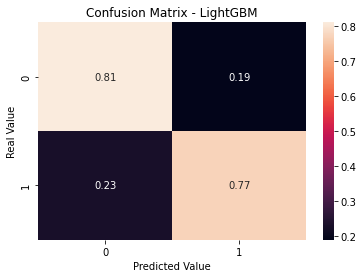

In [736]:
# final LightGBM model
lgb = LGBMClassifier(num_leaves=70, max_depth=5, learning_rate=0.1, min_data_in_leaf=800, scale_pos_weight = 13)
lgb.fit(X_train, y_train)

# prediction
#X_test_lgb = sc.fit_transform(X_test)
y_pred_lgb = lgb.predict(X_test)

# classification report
print(classification_report(y_test, y_pred_lgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_lgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - LightGBM')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

# Threshold-setting to Maximise Performance Metric

Since we are dealing with an imbalanced dataset, we can go further to maximise roc_auc by changing the probability threshold for a case to be considered as positive. 

In [737]:
# Here I check various probability thresholds to identify the one that maximises roc_auc

from numpy import arange
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
 
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds_list = []

# predict probabilities
yhat = lgb.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
recall = [recall_score(y_test, to_labels(probs, t)) for t in thresholds]
precision = [precision_score(y_test, to_labels(probs, t)) for t in thresholds]
roc = [roc_auc_score(y_test, to_labels(probs, t)) for t in thresholds]

for t in thresholds:thresholds_list.append(thresholds)
# get best threshold
ix = argmax(roc)
print('Threshold=%.3f, roc=%.5f' % (thresholds[ix], roc[ix]))

Threshold=0.485, roc=0.79181


In [738]:
# the P and R of the fully adjusted model follows

# predict probabilities
yhat = lgb.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
t = 0.485

y_pred_xgb = to_labels(probs, t)

report = classification_report(y_test, y_pred_xgb, output_dict= True )
report

{'0.0': {'precision': 0.9809603011336281,
  'recall': 0.8005715306304697,
  'f1-score': 0.8816332953070296,
  'support': 27995},
 '1.0': {'precision': 0.21948832657626172,
  'recall': 0.7830423940149626,
  'f1-score': 0.34286962218825073,
  'support': 2005},
 'accuracy': 0.7994,
 'macro avg': {'precision': 0.6002243138549449,
  'recall': 0.7918069623227162,
  'f1-score': 0.6122514587476402,
  'support': 30000},
 'weighted avg': {'precision': 0.9300685908340441,
  'recall': 0.7994,
  'f1-score': 0.8456259231535912,
  'support': 30000}}

In [ ]:
# Prediction on EXTERNAL Test Set

Now that we have fully developed our model, we proceed to predict on the given Kaggle test set, and submit scores to the Kaggle page

This model produced a private AUC of 0.86663 and public AUC of 0.85988. For the private leaderboard, this put me in 137th place, while for the public board, this put me in 226th place. 

In [739]:
kaggle_test_probability = lgb.predict_proba(kaggle_X_test3)[0:,1]

In [740]:
len(kaggle_test_probability)

101503

In [488]:
index =  list(range(1, 101504))

In [741]:
submission = pd.DataFrame({'Id': index,
              'Probability': kaggle_test_probability})

In [742]:
submission['Probability'] = test_submission['Probability']

In [743]:
submission.to_csv('results/fifth_results.csv')

In [466]:
submission

Id  Probability
0            0     0.496814
1            1     0.404538
2            2     0.141777
3            3     0.502503
4            4     0.698580
...        ...          ...
101498  101498     0.337756
101499  101499     0.885995
101500  101500     0.044233
101501  101501     0.530042
101502  101502     0.334713

[101503 rows x 2 columns]

As a 'bonus' attempt. I also built a deep learning model, and submitted it for testing on Kaggle. However, it only hit a private score of 0.85616 and a public score of 0.84962, which are considerably lower than other attempts

In [50]:
# Deep Learning

In [493]:
features_train=np.array(X_train)
target_train=np.array(y_train)
features_test=np.array(X_test)
target_test=np.array(y_test)

In [494]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)

In [498]:
model = Sequential()
model.add(Dense(80, input_dim=14, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [501]:
model.compile(optimizer=tf.optimizers.Adam(), 
              loss='binary_crossentropy',
              metrics=['AUC'])

In [503]:
model.fit(features_train, target_train, epochs=300)

Epoch 1/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1877 - auc: 0.8315
Epoch 2/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1879 - auc: 0.8313
Epoch 3/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1878 - auc: 0.8308
Epoch 4/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1871 - auc: 0.8319
Epoch 5/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1877 - auc: 0.8320
Epoch 6/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1869 - auc: 0.8320
Epoch 7/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1869 - auc: 0.8334
Epoch 8/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1868 - auc: 0.8340
Epoch 9/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1871 - auc: 0.8326
Epoch 10/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1869 - auc: 0.8333
Epoch 11/300
3749/3

3749/3749 [==============================] - 8s 2ms/step - loss: 0.1814 - auc: 0.8515
Epoch 84/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1816 - auc: 0.8519
Epoch 85/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1812 - auc: 0.8536
Epoch 86/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1813 - auc: 0.8533
Epoch 87/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1812 - auc: 0.8517
Epoch 88/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1811 - auc: 0.8515
Epoch 89/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1815 - auc: 0.8517
Epoch 90/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1810 - auc: 0.8526A: 0s - loss: 0.1818
Epoch 91/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1809 - auc: 0.8527
Epoch 92/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1821 - auc: 0.8513
Epo

3749/3749 [==============================] - 8s 2ms/step - loss: 0.1789 - auc: 0.8569
Epoch 165/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1791 - auc: 0.8565
Epoch 166/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1788 - auc: 0.8585
Epoch 167/300
3749/3749 [==============================] - 7s 2ms/step - loss: 0.1783 - auc: 0.8585
Epoch 168/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1784 - auc: 0.8584
Epoch 169/300
3749/3749 [==============================] - 7s 2ms/step - loss: 0.1786 - auc: 0.8590
Epoch 170/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1796 - auc: 0.8573
Epoch 171/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1782 - auc: 0.8592
Epoch 172/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1789 - auc: 0.8570
Epoch 173/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1789 - auc: 0.8567
Epoch 174/300


3749/3749 [==============================] - 8s 2ms/step - loss: 0.1778 - auc: 0.8605
Epoch 246/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1776 - auc: 0.8603
Epoch 247/300
3749/3749 [==============================] - 7s 2ms/step - loss: 0.1772 - auc: 0.8614
Epoch 248/300
3749/3749 [==============================] - 7s 2ms/step - loss: 0.1773 - auc: 0.8606
Epoch 249/300
3749/3749 [==============================] - 7s 2ms/step - loss: 0.1779 - auc: 0.8609
Epoch 250/300
3749/3749 [==============================] - 7s 2ms/step - loss: 0.1778 - auc: 0.8598
Epoch 251/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1787 - auc: 0.8601
Epoch 252/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1768 - auc: 0.8627
Epoch 253/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1773 - auc: 0.8601
Epoch 254/300
3749/3749 [==============================] - 8s 2ms/step - loss: 0.1775 - auc: 0.8599
Epoch 255/300


In [514]:
# deep learning results
predictions = model.predict(kaggle_X_test3)


In [524]:
dl_predictions = predictions.tolist()

In [529]:
dl_predictions = [i[0] for i in dl_predictions]

In [530]:
dl_predictions

[0.08304533362388611,
 0.09249129891395569,
 0.01616770029067993,
 0.10270556807518005,
 0.1082460880279541,
 0.01827991008758545,
 0.00850263237953186,
 0.061293959617614746,
 0.00719645619392395,
 0.5602905750274658,
 0.015984714031219482,
 0.03077036142349243,
 0.013147890567779541,
 0.06397050619125366,
 0.03959992527961731,
 0.02283039689064026,
 0.015005022287368774,
 0.015273422002792358,
 0.29158926010131836,
 0.07572609186172485,
 0.019925087690353394,
 0.013096421957015991,
 0.002440929412841797,
 0.16211938858032227,
 0.05909523367881775,
 0.02935349941253662,
 0.1041392982006073,
 0.0033634305000305176,
 0.08262693881988525,
 0.07657158374786377,
 0.050822317600250244,
 0.006698250770568848,
 0.012334376573562622,
 0.06578084826469421,
 0.3002210259437561,
 0.0384027361869812,
 0.04635077714920044,
 0.031718552112579346,
 0.007186830043792725,
 0.13165852427482605,
 0.16770240664482117,
 0.27611732482910156,
 0.08047953248023987,
 0.01139172911643982,
 0.05788469314575195,


In [508]:
from sklearn.metrics import confusion_matrix
cnf_matrix=confusion_matrix(target_test, predictions)
cnf_matrix

array([[20930,  7053],
       [  592,  1413]], dtype=int64)

In [511]:
dl_report = classification_report(target_test, predictions, output_dict= True )
dl_report

{'0.0': {'precision': 0.9724932627079268,
  'recall': 0.7479541149983919,
  'f1-score': 0.8455711544288456,
  'support': 27983},
 '1.0': {'precision': 0.1669029057406095,
  'recall': 0.7047381546134663,
  'f1-score': 0.26988826282112505,
  'support': 2005},
 'accuracy': 0.7450646925436841,
 'macro avg': {'precision': 0.5696980842242682,
  'recall': 0.7263461348059291,
  'f1-score': 0.5577297086249853,
  'support': 29988},
 'weighted avg': {'precision': 0.9186314291171747,
  'recall': 0.7450646925436841,
  'f1-score': 0.8070809517586616,
  'support': 29988}}